## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


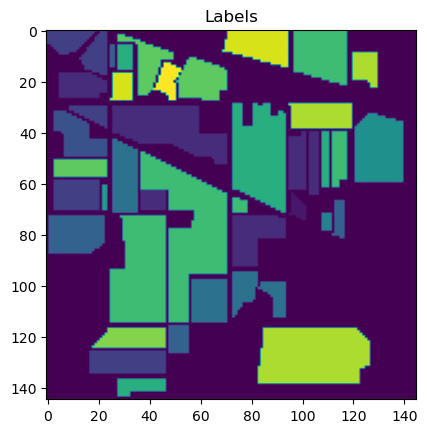

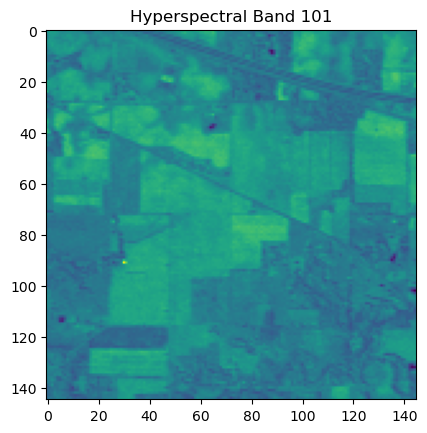

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(320, 5, 5, 200)
(75, 5, 5, 200)
(9854, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0799, PSNR: 10.7535


Epoch [1/50] Training Loss: 0.0651, PSNR: 11.4279
	[Val]   Batch [1/33] Loss: 0.0496, PSNR: 12.7060
	[Val]   Batch [10/33] Loss: 0.0491, PSNR: 12.3553
	[Val]   Batch [20/33] Loss: 0.0488, PSNR: 11.9489
	[Val]   Batch [30/33] Loss: 0.0473, PSNR: 12.3278
Epoch [1/50] Validation Loss: 0.0494, PSNR: 12.5220

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0497, PSNR: 12.3030


Epoch [2/50] Training Loss: 0.0396, PSNR: 13.6068
	[Val]   Batch [1/33] Loss: 0.0292, PSNR: 15.0061
	[Val]   Batch [10/33] Loss: 0.0287, PSNR: 14.6864
	[Val]   Batch [20/33] Loss: 0.0284, PSNR: 14.2929
	[Val]   Batch [30/33] Loss: 0.0277, PSNR: 14.6555
Epoch [2/50] Validation Loss: 0.0291, PSNR: 14.8211

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0288, PSNR: 14.6789


Epoch [3/50] Training Loss: 0.0229, PSNR: 16.0065
	[Val]   Batch [1/33] Loss: 0.0172, PSNR: 17.3177
	[Val]   Batch [10/33] Loss: 0.0167, PSNR: 17.0423
	[Val]   Batch [20/33] Loss: 0.0164, PSNR: 16.6772
	[Val]   Batch [30/33] Loss: 0.0159, PSNR: 17.0593
Epoch [3/50] Validation Loss: 0.0171, PSNR: 17.1297

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0170, PSNR: 16.9914


Epoch [4/50] Training Loss: 0.0139, PSNR: 18.1571
	[Val]   Batch [1/33] Loss: 0.0112, PSNR: 19.1566
	[Val]   Batch [10/33] Loss: 0.0108, PSNR: 18.9388
	[Val]   Batch [20/33] Loss: 0.0105, PSNR: 18.6141
	[Val]   Batch [30/33] Loss: 0.0101, PSNR: 19.0126
Epoch [4/50] Validation Loss: 0.0112, PSNR: 18.9736

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0114, PSNR: 19.2078


Epoch [5/50] Training Loss: 0.0093, PSNR: 19.8624
	[Val]   Batch [1/33] Loss: 0.0079, PSNR: 20.6698
	[Val]   Batch [10/33] Loss: 0.0075, PSNR: 20.5207
	[Val]   Batch [20/33] Loss: 0.0072, PSNR: 20.2442
	[Val]   Batch [30/33] Loss: 0.0070, PSNR: 20.6461
Epoch [5/50] Validation Loss: 0.0079, PSNR: 20.4902

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0072, PSNR: 21.1876


Epoch [6/50] Training Loss: 0.0069, PSNR: 21.1704
	[Val]   Batch [1/33] Loss: 0.0062, PSNR: 21.7188
	[Val]   Batch [10/33] Loss: 0.0058, PSNR: 21.6367
	[Val]   Batch [20/33] Loss: 0.0055, PSNR: 21.3995
	[Val]   Batch [30/33] Loss: 0.0053, PSNR: 21.8043
Epoch [6/50] Validation Loss: 0.0062, PSNR: 21.5443

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0062, PSNR: 21.6684


Epoch [7/50] Training Loss: 0.0055, PSNR: 22.1680
	[Val]   Batch [1/33] Loss: 0.0051, PSNR: 22.5934
	[Val]   Batch [10/33] Loss: 0.0047, PSNR: 22.5801
	[Val]   Batch [20/33] Loss: 0.0044, PSNR: 22.3769
	[Val]   Batch [30/33] Loss: 0.0043, PSNR: 22.7875
Epoch [7/50] Validation Loss: 0.0051, PSNR: 22.4259

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0056, PSNR: 21.7158


Epoch [8/50] Training Loss: 0.0046, PSNR: 22.9443
	[Val]   Batch [1/33] Loss: 0.0043, PSNR: 23.3455
	[Val]   Batch [10/33] Loss: 0.0039, PSNR: 23.4077
	[Val]   Batch [20/33] Loss: 0.0036, PSNR: 23.2375
	[Val]   Batch [30/33] Loss: 0.0035, PSNR: 23.6797
Epoch [8/50] Validation Loss: 0.0043, PSNR: 23.2006

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0037, PSNR: 24.2959


Epoch [9/50] Training Loss: 0.0039, PSNR: 23.6999
	[Val]   Batch [1/33] Loss: 0.0036, PSNR: 24.0557
	[Val]   Batch [10/33] Loss: 0.0032, PSNR: 24.2106
	[Val]   Batch [20/33] Loss: 0.0030, PSNR: 24.0634
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.5181
Epoch [9/50] Validation Loss: 0.0036, PSNR: 23.9435

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0033, PSNR: 24.3357


Epoch [10/50] Training Loss: 0.0034, PSNR: 24.3246
	[Val]   Batch [1/33] Loss: 0.0032, PSNR: 24.6443
	[Val]   Batch [10/33] Loss: 0.0027, PSNR: 24.9146
	[Val]   Batch [20/33] Loss: 0.0025, PSNR: 24.7995
	[Val]   Batch [30/33] Loss: 0.0024, PSNR: 25.2955
Epoch [10/50] Validation Loss: 0.0031, PSNR: 24.6048

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 25.1124


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.8369
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.0357
	[Val]   Batch [10/33] Loss: 0.0024, PSNR: 25.3794
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.2877
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.8301
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.0557

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 26.2280


Epoch [12/50] Training Loss: 0.0026, PSNR: 25.4182
	[Val]   Batch [1/33] Loss: 0.0025, PSNR: 25.6673
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 26.1026
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 26.0399
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.5946
Epoch [12/50] Validation Loss: 0.0024, PSNR: 25.7237

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 24.9006


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.8396
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.1711
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.6555
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.6102
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.1948
Epoch [13/50] Validation Loss: 0.0021, PSNR: 26.2558

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.4542


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.2387
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.4930
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.9853
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 26.9531
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.5760
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.5895

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0025, PSNR: 26.0728


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.5985
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.9470
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.4200
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.3823
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 28.0049
Epoch [15/50] Validation Loss: 0.0018, PSNR: 27.0243

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.8529


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9609
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.4925
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.9090
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 27.8869
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.5632
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.5320

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 26.6545


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2853
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.7393
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.1404
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.1627
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.8575
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.8119

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.5477


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6784
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.4058
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7443
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7576
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.4382
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.4235

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.1812


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9769
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.6209
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.9322
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.9489
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.6287
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.6370

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.7663


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2690
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 29.0344
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3201
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.3664
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.0617
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.0466

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 26.7534


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.5139
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5135
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7911
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.8789
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5859
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.5214

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.2006


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7824
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7445
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 29.9974
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.1101
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8502
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.7556

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.5012


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.9553
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6379
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8464
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9638
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7432
Epoch [23/50] Validation Loss: 0.0010, PSNR: 29.6481

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.7284


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1149
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2742
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4428
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6590
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3980
Epoch [24/50] Validation Loss: 0.0008, PSNR: 30.2767

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.8427


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2991
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3387
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4974
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6959
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4738
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3456

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.8909


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4646
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4775
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6069
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8295
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5980
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.4814

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.2192


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5560
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6833
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8482
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.1066
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.9220
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.7199
Early stopping triggered at epoch 27. No improvement for 3 epochs.


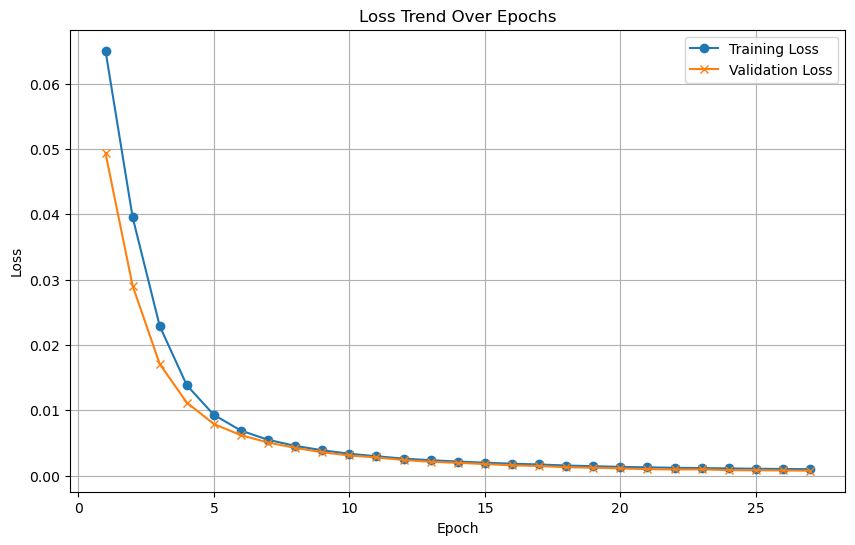

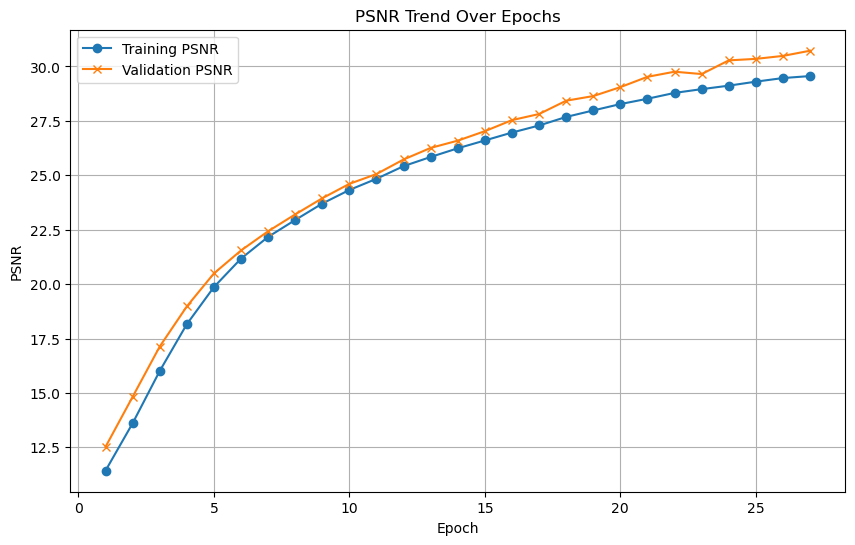

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/39 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7913
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.67%
Validation loss improved from inf to 2.7791. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7551
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7202
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7100
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

    Validation Batch [1/1], Loss: 2.7792
Validation Loss: 2.7792, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6511
    Validation Batch [1/1], Loss: 2.7792
Validation Loss: 2.7792, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6388
    Validation Batch [1/1], Loss: 2.7793
Validation Loss: 2.7793, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6368
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6167
    Validation Batch [1/1], Loss: 2.7794
Validation Loss: 2.7794, Validation

    Validation Batch [1/1], Loss: 2.7800
Validation Loss: 2.7800, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5574
    Validation Batch [1/1], Loss: 2.7797
Validation Loss: 2.7797, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5586
    Validation Batch [1/1], Loss: 2.7795
Validation Loss: 2.7795, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5391
    Validation Batch [1/1], Loss: 2.7791
Validation Loss: 2.7791, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5332
    Validation Batch [1/1], Loss: 2.7786
Validation Loss: 2.7786, Va

Epoch [30/1000] completed, Average Training Loss: 2.4504
    Validation Batch [1/1], Loss: 2.7677
Validation Loss: 2.7677, Validation Accuracy: 6.67%
Validation loss improved from 2.7694 to 2.7677. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.4314
    Validation Batch [1/1], Loss: 2.7650
Validation Loss: 2.7650, Validation Accuracy: 6.67%
Validation loss improved from 2.7677 to 2.7650. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4318
    Validation Batch [1/1], Loss: 2.7610
Validation Loss: 2.7610, Validation Accuracy: 6.67%
Validation loss improved from 2.7650 to 2.7610. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4306
    Validation Batch [1/1], Loss: 2.7560
Validation Loss: 2.7560, Validation Accuracy: 6.67%
Validation loss improved from 2.7610 to 2.7560. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/10

Epoch [40/1000] completed, Average Training Loss: 2.3571
    Validation Batch [1/1], Loss: 2.7140
Validation Loss: 2.7140, Validation Accuracy: 16.00%
Validation loss improved from 2.7229 to 2.7140. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3547
    Validation Batch [1/1], Loss: 2.7031
Validation Loss: 2.7031, Validation Accuracy: 16.00%
Validation loss improved from 2.7140 to 2.7031. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3472
    Validation Batch [1/1], Loss: 2.6906
Validation Loss: 2.6906, Validation Accuracy: 16.00%
Validation loss improved from 2.7031 to 2.6906. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3468
    Validation Batch [1/1], Loss: 2.6794
Validation Loss: 2.6794, Validation Accuracy: 17.33%
Validation loss improved from 2.6906 to 2.6794. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [4

Epoch [53/1000] completed, Average Training Loss: 2.2579
    Validation Batch [1/1], Loss: 2.5605
Validation Loss: 2.5605, Validation Accuracy: 36.00%
Validation loss improved from 2.5703 to 2.5605. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2650
    Validation Batch [1/1], Loss: 2.5557
Validation Loss: 2.5557, Validation Accuracy: 34.67%
Validation loss improved from 2.5605 to 2.5557. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.2518
    Validation Batch [1/1], Loss: 2.5512
Validation Loss: 2.5512, Validation Accuracy: 36.00%
Validation loss improved from 2.5557 to 2.5512. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.2370
    Validation Batch [1/1], Loss: 2.5306
Validation Loss: 2.5306, Validation Accuracy: 33.33%
Validation loss improved from 2.5512 to 2.5306. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [5

Epoch [63/1000] completed, Average Training Loss: 2.1969
    Validation Batch [1/1], Loss: 2.4208
Validation Loss: 2.4208, Validation Accuracy: 42.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.1719
    Validation Batch [1/1], Loss: 2.4062
Validation Loss: 2.4062, Validation Accuracy: 41.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.1632
    Validation Batch [1/1], Loss: 2.3904
Validation Loss: 2.3904, Validation Accuracy: 41.33%
Validation loss improved from 2.4035 to 2.3904. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.1641
    Validation Batch [1/1], Loss: 2.3736
Validation Loss: 2.3736, Validation Accuracy: 42.67%
Validation loss improved from 2.3904 to 2.3736. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Tra

Epoch [76/1000] completed, Average Training Loss: 2.0789
    Validation Batch [1/1], Loss: 2.2248
Validation Loss: 2.2248, Validation Accuracy: 46.67%
Validation loss improved from 2.2466 to 2.2248. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.0810
    Validation Batch [1/1], Loss: 2.2327
Validation Loss: 2.2327, Validation Accuracy: 46.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0845
    Validation Batch [1/1], Loss: 2.2483
Validation Loss: 2.2483, Validation Accuracy: 46.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.0668
    Validation Batch [1/1], Loss: 2.2331
Validation Loss: 2.2331, Validation Accuracy: 46.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 2.0

Epoch [86/1000] completed, Average Training Loss: 2.0124
    Validation Batch [1/1], Loss: 2.1272
Validation Loss: 2.1272, Validation Accuracy: 48.00%
Validation loss improved from 2.1708 to 2.1272. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.9960
    Validation Batch [1/1], Loss: 2.1290
Validation Loss: 2.1290, Validation Accuracy: 46.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.9723
    Validation Batch [1/1], Loss: 2.1133
Validation Loss: 2.1133, Validation Accuracy: 46.67%
Validation loss improved from 2.1272 to 2.1133. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.9579
    Validation Batch [1/1], Loss: 2.1141
Validation Loss: 2.1141, Validation Accuracy: 48.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Tra

    Validation Batch [1/1], Loss: 2.0118
Validation Loss: 2.0118, Validation Accuracy: 54.67%
Validation loss improved from 2.0185 to 2.0118. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8885
    Validation Batch [1/1], Loss: 1.9932
Validation Loss: 1.9932, Validation Accuracy: 52.00%
Validation loss improved from 2.0118 to 1.9932. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.8922
    Validation Batch [1/1], Loss: 2.0124
Validation Loss: 2.0124, Validation Accuracy: 49.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8790
    Validation Batch [1/1], Loss: 2.0527
Validation Loss: 2.0527, Validation Accuracy: 50.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.8702
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.9417
Validation Loss: 1.9417, Validation Accuracy: 50.67%
Validation loss improved from 1.9509 to 1.9417. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.8250
    Validation Batch [1/1], Loss: 1.9524
Validation Loss: 1.9524, Validation Accuracy: 49.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.8015
    Validation Batch [1/1], Loss: 1.9504
Validation Loss: 1.9504, Validation Accuracy: 54.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.8026
    Validation Batch [1/1], Loss: 1.9467
Validation Loss: 1.9467, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7632
    Validation Batch [1/1], Loss: 1.9690
Vali

Epoch [122/1000] completed, Average Training Loss: 1.7032
    Validation Batch [1/1], Loss: 1.9012
Validation Loss: 1.9012, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6848
    Validation Batch [1/1], Loss: 1.8596
Validation Loss: 1.8596, Validation Accuracy: 60.00%
Validation loss improved from 1.8661 to 1.8596. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6650
    Validation Batch [1/1], Loss: 1.8600
Validation Loss: 1.8600, Validation Accuracy: 54.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6877
    Validation Batch [1/1], Loss: 1.8415
Validation Loss: 1.8415, Validation Accuracy: 58.67%
Validation loss improved from 1.8596 to 1.8415. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Av

Epoch [130/1000] completed, Average Training Loss: 1.6543
    Validation Batch [1/1], Loss: 1.8326
Validation Loss: 1.8326, Validation Accuracy: 57.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.6445
    Validation Batch [1/1], Loss: 1.8216
Validation Loss: 1.8216, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.6136
    Validation Batch [1/1], Loss: 1.7575
Validation Loss: 1.7575, Validation Accuracy: 62.67%
Validation loss improved from 1.8027 to 1.7575. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.6102
    Validation Batch [1/1], Loss: 1.7597
Validation Loss: 1.7597, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.7007
Validation Loss: 1.7007, Validation Accuracy: 65.33%
Validation loss improved from 1.7173 to 1.7007. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.5082
    Validation Batch [1/1], Loss: 1.7430
Validation Loss: 1.7430, Validation Accuracy: 62.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.5137
    Validation Batch [1/1], Loss: 1.7716
Validation Loss: 1.7716, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.4880
    Validation Batch [1/1], Loss: 1.7508
Validation Loss: 1.7508, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4591
    Validation Batch [1/1], Loss: 1.6703
Vali

Epoch [153/1000] completed, Average Training Loss: 1.4367
    Validation Batch [1/1], Loss: 1.6891
Validation Loss: 1.6891, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.4209
    Validation Batch [1/1], Loss: 1.6537
Validation Loss: 1.6537, Validation Accuracy: 64.00%
Validation loss improved from 1.6703 to 1.6537. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.4248
    Validation Batch [1/1], Loss: 1.6055
Validation Loss: 1.6055, Validation Accuracy: 69.33%
Validation loss improved from 1.6537 to 1.6055. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.3932
    Validation Batch [1/1], Loss: 1.6582
Validation Loss: 1.6582, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Av

Epoch [167/1000] completed, Average Training Loss: 1.2671
    Validation Batch [1/1], Loss: 1.5668
Validation Loss: 1.5668, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.2856
    Validation Batch [1/1], Loss: 1.5832
Validation Loss: 1.5832, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.2645
    Validation Batch [1/1], Loss: 1.5770
Validation Loss: 1.5770, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.2791
    Validation Batch [1/1], Loss: 1.5242
Validation Loss: 1.5242, Validation Accuracy: 70.67%
Validation loss improved from 1.5658 to 1.5242. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.5626
Validation Loss: 1.5626, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.2370
    Validation Batch [1/1], Loss: 1.5009
Validation Loss: 1.5009, Validation Accuracy: 70.67%
Validation loss improved from 1.5151 to 1.5009. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.2049
    Validation Batch [1/1], Loss: 1.4933
Validation Loss: 1.4933, Validation Accuracy: 72.00%
Validation loss improved from 1.5009 to 1.4933. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.2169
    Validation Batch [1/1], Loss: 1.4829
Validation Loss: 1.4829, Validation Accuracy: 80.00%
Validation loss improved from 1.4933 to 1.4829. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1983
    Validation 

    Validation Batch [1/1], Loss: 1.3953
Validation Loss: 1.3953, Validation Accuracy: 81.33%
Validation loss improved from 1.4123 to 1.3953. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.1101
    Validation Batch [1/1], Loss: 1.4172
Validation Loss: 1.4172, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.0767
    Validation Batch [1/1], Loss: 1.4034
Validation Loss: 1.4034, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 1.0863
    Validation Batch [1/1], Loss: 1.3987
Validation Loss: 1.3987, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 1.0766
    Validation Batch [1/1], Loss: 1.4068
Vali

Epoch [200/1000] completed, Average Training Loss: 1.0160
    Validation Batch [1/1], Loss: 1.3226
Validation Loss: 1.3226, Validation Accuracy: 84.00%
Validation loss improved from 1.3454 to 1.3226. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 1.0096
    Validation Batch [1/1], Loss: 1.3696
Validation Loss: 1.3696, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.9797
    Validation Batch [1/1], Loss: 1.3232
Validation Loss: 1.3232, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.9916
    Validation Batch [1/1], Loss: 1.3291
Validation Loss: 1.3291, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.2587
Validation Loss: 1.2587, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.8909
    Validation Batch [1/1], Loss: 1.3036
Validation Loss: 1.3036, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.9309
    Validation Batch [1/1], Loss: 1.3597
Validation Loss: 1.3597, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.8985
    Validation Batch [1/1], Loss: 1.2153
Validation Loss: 1.2153, Validation Accuracy: 84.00%
Validation loss improved from 1.2392 to 1.2153. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.9004
    Validation Batch [1/1], Loss: 1.2237
Vali

    Validation Batch [1/1], Loss: 1.2244
Validation Loss: 1.2244, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.8175
    Validation Batch [1/1], Loss: 1.2901
Validation Loss: 1.2901, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.8313
    Validation Batch [1/1], Loss: 1.2060
Validation Loss: 1.2060, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.8254
    Validation Batch [1/1], Loss: 1.2151
Validation Loss: 1.2151, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.7969
    Validation Batch [1/1], Loss: 1.1373
Validation Loss: 1.

Epoch [235/1000] completed, Average Training Loss: 0.7781
    Validation Batch [1/1], Loss: 1.2349
Validation Loss: 1.2349, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7617
    Validation Batch [1/1], Loss: 1.1738
Validation Loss: 1.1738, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7698
    Validation Batch [1/1], Loss: 1.1543
Validation Loss: 1.1543, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.7166
    Validation Batch [1/1], Loss: 1.2405
Validation Loss: 1.2405, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.7119


Epoch [246/1000] completed, Average Training Loss: 0.6737
    Validation Batch [1/1], Loss: 1.0877
Validation Loss: 1.0877, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.6782
    Validation Batch [1/1], Loss: 1.1232
Validation Loss: 1.1232, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.6845
    Validation Batch [1/1], Loss: 1.1048
Validation Loss: 1.1048, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.6786
    Validation Batch [1/1], Loss: 1.0714
Validation Loss: 1.0714, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.6547
  

    Validation Batch [1/1], Loss: 1.0551
Validation Loss: 1.0551, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.6056
    Validation Batch [1/1], Loss: 1.0332
Validation Loss: 1.0332, Validation Accuracy: 80.00%
Validation loss improved from 1.0439 to 1.0332. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.6166
    Validation Batch [1/1], Loss: 1.0211
Validation Loss: 1.0211, Validation Accuracy: 81.33%
Validation loss improved from 1.0332 to 1.0211. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.5984
    Validation Batch [1/1], Loss: 1.0215
Validation Loss: 1.0215, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.6052
    Validation Batch [1/1], Lo

Epoch [271/1000] completed, Average Training Loss: 0.5203
    Validation Batch [1/1], Loss: 0.9417
Validation Loss: 0.9417, Validation Accuracy: 86.67%
Validation loss improved from 0.9581 to 0.9417. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.5241
    Validation Batch [1/1], Loss: 0.9741
Validation Loss: 0.9741, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.5235
    Validation Batch [1/1], Loss: 0.9867
Validation Loss: 0.9867, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.5174
    Validation Batch [1/1], Loss: 1.0190
Validation Loss: 1.0190, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training 

Epoch [280/1000] completed, Average Training Loss: 0.5143
    Validation Batch [1/1], Loss: 0.9250
Validation Loss: 0.9250, Validation Accuracy: 84.00%
Validation loss improved from 0.9264 to 0.9250. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4939
    Validation Batch [1/1], Loss: 1.0073
Validation Loss: 1.0073, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4810
    Validation Batch [1/1], Loss: 0.9508
Validation Loss: 0.9508, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.5204
    Validation Batch [1/1], Loss: 0.9154
Validation Loss: 0.9154, Validation Accuracy: 82.67%
Validation loss improved from 0.9250 to 0.9154. Saving model...

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Av

    Validation Batch [1/1], Loss: 0.8989
Validation Loss: 0.8989, Validation Accuracy: 81.33%
Validation loss improved from 0.8990 to 0.8989. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4459
    Validation Batch [1/1], Loss: 0.9139
Validation Loss: 0.9139, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.4163
    Validation Batch [1/1], Loss: 0.8840
Validation Loss: 0.8840, Validation Accuracy: 85.33%
Validation loss improved from 0.8989 to 0.8840. Saving model...

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.4269
    Validation Batch [1/1], Loss: 0.8671
Validation Loss: 0.8671, Validation Accuracy: 82.67%
Validation loss improved from 0.8840 to 0.8671. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.4192
    Validation 

Epoch [303/1000] completed, Average Training Loss: 0.4102
    Validation Batch [1/1], Loss: 0.8772
Validation Loss: 0.8772, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3904
    Validation Batch [1/1], Loss: 0.8147
Validation Loss: 0.8147, Validation Accuracy: 84.00%
Validation loss improved from 0.8671 to 0.8147. Saving model...

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3893
    Validation Batch [1/1], Loss: 0.8885
Validation Loss: 0.8885, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3907


    Validation Batch [1/1], Loss: 0.9273
Validation Loss: 0.9273, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3706
    Validation Batch [1/1], Loss: 0.8185
Validation Loss: 0.8185, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.3699
    Validation Batch [1/1], Loss: 0.8178
Validation Loss: 0.8178, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.3596
    Validation Batch [1/1], Loss: 0.8942
Validation Loss: 0.8942, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.3630
    Validation Batch [1/1], Loss: 0.8490
Validation Loss: 0.

Epoch [316/1000] completed, Average Training Loss: 0.3471
    Validation Batch [1/1], Loss: 0.8370
Validation Loss: 0.8370, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.3579
    Validation Batch [1/1], Loss: 0.8198
Validation Loss: 0.8198, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3339
    Validation Batch [1/1], Loss: 0.8000
Validation Loss: 0.8000, Validation Accuracy: 84.00%
Validation loss improved from 0.8137 to 0.8000. Saving model...

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.3611
    Validation Batch [1/1], Loss: 0.8170
Validation Loss: 0.8170, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training 

Epoch [329/1000] completed, Average Training Loss: 0.3237
    Validation Batch [1/1], Loss: 0.8712
Validation Loss: 0.8712, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3334
    Validation Batch [1/1], Loss: 0.8168
Validation Loss: 0.8168, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.3249
    Validation Batch [1/1], Loss: 0.8953
Validation Loss: 0.8953, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.3117
    Validation Batch [1/1], Loss: 0.7951
Validation Loss: 0.7951, Validation Accuracy: 82.67%
Validation loss improved from 0.8000 to 0.7951. Saving model...

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Traini

Epoch [341/1000] completed, Average Training Loss: 0.2815
    Validation Batch [1/1], Loss: 0.8651
Validation Loss: 0.8651, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2963
    Validation Batch [1/1], Loss: 0.8258
Validation Loss: 0.8258, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2992
    Validation Batch [1/1], Loss: 0.8189
Validation Loss: 0.8189, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2668
    Validation Batch [1/1], Loss: 0.7854
Validation Loss: 0.7854, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2705
  

Epoch [352/1000] completed, Average Training Loss: 0.2653
    Validation Batch [1/1], Loss: 0.8128
Validation Loss: 0.8128, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2475
    Validation Batch [1/1], Loss: 0.7944
Validation Loss: 0.7944, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2351
    Validation Batch [1/1], Loss: 0.7634
Validation Loss: 0.7634, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2566
    Validation Batch [1/1], Loss: 0.8225
Validation Loss: 0.8225, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2556
  

Epoch [363/1000] completed, Average Training Loss: 0.2507
    Validation Batch [1/1], Loss: 0.8288
Validation Loss: 0.8288, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2427
    Validation Batch [1/1], Loss: 0.8197
Validation Loss: 0.8197, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2361
    Validation Batch [1/1], Loss: 0.8662
Validation Loss: 0.8662, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2494
    Validation Batch [1/1], Loss: 0.8600
Validation Loss: 0.8600, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2394
  

Epoch [374/1000] completed, Average Training Loss: 0.2270
    Validation Batch [1/1], Loss: 0.7907
Validation Loss: 0.7907, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.2251
    Validation Batch [1/1], Loss: 0.7423
Validation Loss: 0.7423, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2345
    Validation Batch [1/1], Loss: 0.6898
Validation Loss: 0.6898, Validation Accuracy: 85.33%
Validation loss improved from 0.7187 to 0.6898. Saving model...

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2212
    Validation Batch [1/1], Loss: 0.7032
Validation Loss: 0.7032, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Trainin

Epoch [387/1000] completed, Average Training Loss: 0.2104
    Validation Batch [1/1], Loss: 0.8536
Validation Loss: 0.8536, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.2074
    Validation Batch [1/1], Loss: 0.8247
Validation Loss: 0.8247, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.2127
    Validation Batch [1/1], Loss: 0.7756
Validation Loss: 0.7756, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1754
    Validation Batch [1/1], Loss: 0.7605
Validation Loss: 0.7605, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.206

    Validation Batch [1/1], Loss: 0.7233
Validation Loss: 0.7233, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.2090
    Validation Batch [1/1], Loss: 0.7625
Validation Loss: 0.7625, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1867
    Validation Batch [1/1], Loss: 0.8873
Validation Loss: 0.8873, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.2031
    Validation Batch [1/1], Loss: 0.7599
Validation Loss: 0.7599, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1768
    Validation Batch [1/1], Loss: 0.7769
Validation Loss: 0.

    Validation Batch [1/1], Loss: 1.0270
Validation Loss: 1.0270, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1725
    Validation Batch [1/1], Loss: 0.7520
Validation Loss: 0.7520, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1723
    Validation Batch [1/1], Loss: 0.7086
Validation Loss: 0.7086, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1778
    Validation Batch [1/1], Loss: 0.7859
Validation Loss: 0.7859, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1648
    Validation Batch [1/1], Loss: 0.9680
Validation Loss

Epoch [418/1000] completed, Average Training Loss: 0.1697
    Validation Batch [1/1], Loss: 0.7080
Validation Loss: 0.7080, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1585
    Validation Batch [1/1], Loss: 0.8289
Validation Loss: 0.8289, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1623
    Validation Batch [1/1], Loss: 0.7527
Validation Loss: 0.7527, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1649
    Validation Batch [1/1], Loss: 0.7462
Validation Loss: 0.7462, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.163

    Validation Batch [1/1], Loss: 0.7233
Validation Loss: 0.7233, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1489
    Validation Batch [1/1], Loss: 0.8003
Validation Loss: 0.8003, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1582
    Validation Batch [1/1], Loss: 0.7641
Validation Loss: 0.7641, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1503
    Validation Batch [1/1], Loss: 0.7142
Validation Loss: 0.7142, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1490
    Validation Batch [1/1], Loss: 0.7071
Validation Loss

Epoch [441/1000] completed, Average Training Loss: 0.1463
    Validation Batch [1/1], Loss: 0.7648
Validation Loss: 0.7648, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1426
    Validation Batch [1/1], Loss: 0.8181
Validation Loss: 0.8181, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1290
    Validation Batch [1/1], Loss: 0.7594
Validation Loss: 0.7594, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1378
    Validation Batch [1/1], Loss: 0.7128
Validation Loss: 0.7128, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.132

    Validation Batch [1/1], Loss: 0.7357
Validation Loss: 0.7357, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1178
    Validation Batch [1/1], Loss: 0.8142
Validation Loss: 0.8142, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1311
    Validation Batch [1/1], Loss: 0.6922
Validation Loss: 0.6922, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1207
    Validation Batch [1/1], Loss: 0.6717
Validation Loss: 0.6717, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1295
    Validation Batch [1/1], Loss: 0.7639
Validation Loss: 0.

Epoch [464/1000] completed, Average Training Loss: 0.1226
    Validation Batch [1/1], Loss: 0.6855
Validation Loss: 0.6855, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1244
    Validation Batch [1/1], Loss: 0.6370
Validation Loss: 0.6370, Validation Accuracy: 85.33%
Validation loss improved from 0.6387 to 0.6370. Saving model...

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1094
    Validation Batch [1/1], Loss: 0.6824
Validation Loss: 0.6824, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1218
    Validation Batch [1/1], Loss: 0.7519
Validation Loss: 0.7519, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training

Epoch [475/1000] completed, Average Training Loss: 0.1132
    Validation Batch [1/1], Loss: 0.6490
Validation Loss: 0.6490, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1240
    Validation Batch [1/1], Loss: 0.7909
Validation Loss: 0.7909, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1149
    Validation Batch [1/1], Loss: 0.7730
Validation Loss: 0.7730, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 0.6731
Validation Loss: 0.6731, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.123

Epoch [486/1000] completed, Average Training Loss: 0.1056
    Validation Batch [1/1], Loss: 0.7501
Validation Loss: 0.7501, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0977
    Validation Batch [1/1], Loss: 0.6800
Validation Loss: 0.6800, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.1125
    Validation Batch [1/1], Loss: 0.6852
Validation Loss: 0.6852, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.1019
    Validation Batch [1/1], Loss: 0.7866
Validation Loss: 0.7866, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.094

Epoch [500/1000] completed, Average Training Loss: 0.0980
    Validation Batch [1/1], Loss: 0.8472
Validation Loss: 0.8472, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0995
    Validation Batch [1/1], Loss: 0.7772
Validation Loss: 0.7772, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1098
    Validation Batch [1/1], Loss: 0.8466
Validation Loss: 0.8466, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.7750
Validation Loss: 0.7750, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.099

    Validation Batch [1/1], Loss: 0.8231
Validation Loss: 0.8231, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.1024
    Validation Batch [1/1], Loss: 0.7465
Validation Loss: 0.7465, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0950
    Validation Batch [1/1], Loss: 0.7257
Validation Loss: 0.7257, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0940
    Validation Batch [1/1], Loss: 0.7913
Validation Loss: 0.7913, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.1008
    Validation Batch [1/1], Loss: 0.6917
Validation Loss

Epoch [525/1000] completed, Average Training Loss: 0.0890
    Validation Batch [1/1], Loss: 0.7341
Validation Loss: 0.7341, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0943
    Validation Batch [1/1], Loss: 0.6943
Validation Loss: 0.6943, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0835
    Validation Batch [1/1], Loss: 0.6738
Validation Loss: 0.6738, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.6931
Validation Loss: 0.6931, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.090

    Validation Batch [1/1], Loss: 0.6629
Validation Loss: 0.6629, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0863
    Validation Batch [1/1], Loss: 0.6571
Validation Loss: 0.6571, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0798
    Validation Batch [1/1], Loss: 0.7032
Validation Loss: 0.7032, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0911
    Validation Batch [1/1], Loss: 0.7179
Validation Loss: 0.7179, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0810
    Validation Batch [1/1], Loss: 0.7059
Validation Loss

Epoch [548/1000] completed, Average Training Loss: 0.0837
    Validation Batch [1/1], Loss: 0.7077
Validation Loss: 0.7077, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.7144
Validation Loss: 0.7144, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.6891
Validation Loss: 0.6891, Validation Accuracy: 85.33%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0693
    Validation Batch [1/1], Loss: 0.7176
Validation Loss: 0.7176, Validation Accuracy: 84.00%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.081

Epoch [555/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.7901
Validation Loss: 0.7901, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0837
    Validation Batch [1/1], Loss: 0.8300
Validation Loss: 0.8300, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.7521
Validation Loss: 0.7521, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.7391
Validation Loss: 0.7391, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.067

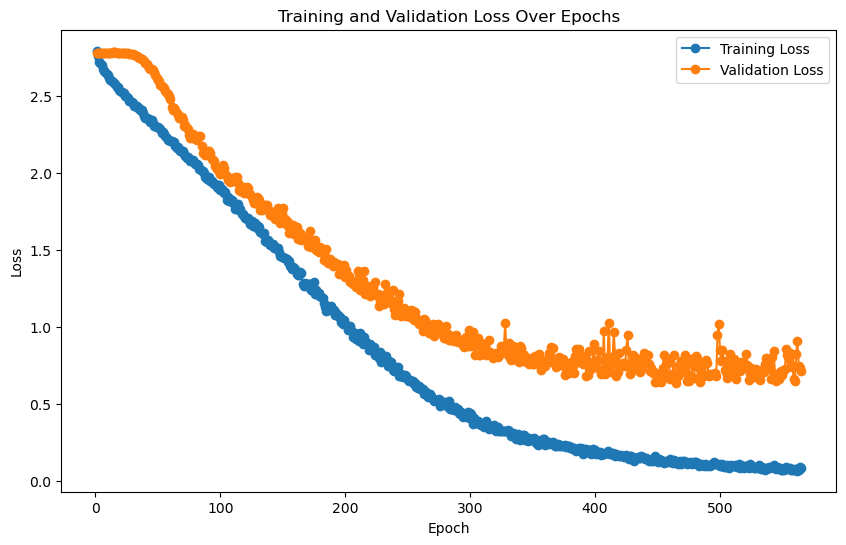

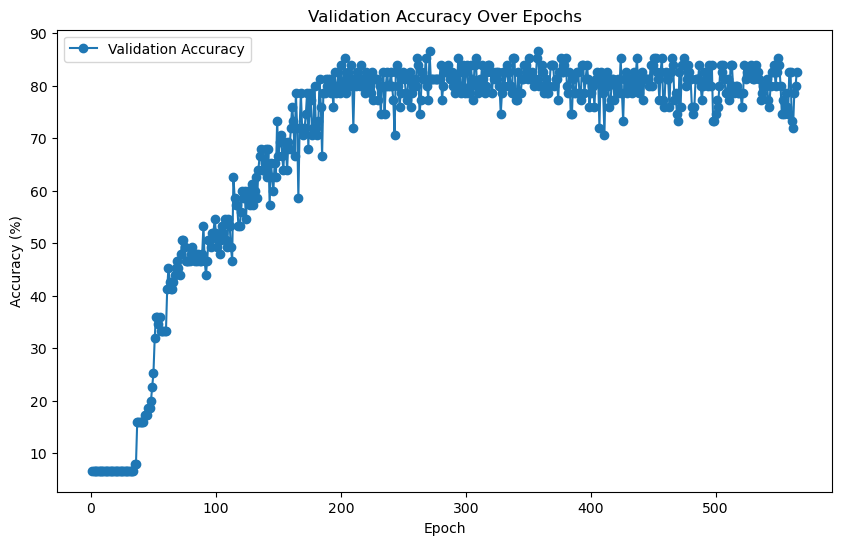


Evaluating on the test set...
    Test Batch [1/39], Loss: 1.6504

Final Test Loss: 1.0651, Test Accuracy: 68.27%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/39 for test dataset.
  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (75, 64), Validation labels shape: (75,)
LOG: Test features shape: (9854, 64), Test labels shape: (9854,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.50      0.40      0.44         5
           2       0.40      0.40      0.40         5
           3       0.25      0.20      0.22         5
           4       1.00      0.40      0.57         5
           5       0.40      0.40      0.40         5
           6       1.00      0.60      0.75         5
           7       0.71      1.00      0.83         5
           8       0.00      0.00  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (75, 64)
Val labels shape: (75,)
Test reps shape: (9854, 64)
Test labels shape: (9854,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8465  |  Val Loss: 2.7269
Validation loss improved from inf to 2.7269.
[Epoch 2/1000] Train Loss: 2.7103  |  Val Loss: 2.6500
Validation loss improved from 2.7269 to 2.6500.
[Epoch 3/1000] Train Loss: 2.6231  |  Val Loss: 2.5900
Validation loss improved from 2.6500 to 2.5900.
[Epoch 4/1000] Train Loss: 2.5564  |  Val Loss: 2.5292
Validation loss improved from 2.5900 to 2.5292.
[Epoch 5/1000] Train Loss: 2.4786  |  Val Loss: 2.4610
Validation loss improved from 2.5292 to 2.4610.
[Epoch 6/1000] Train Loss: 2.3986  |  Val Loss: 2.3860
Validation loss improved from 2.4610 to 2.3860.
[Epoch 7/1000] Train Loss: 2.3229  |  Val Loss: 2.3131
Validation loss improved from 2.3860 to 2.3131.
[Epoch 8/1000] Train Loss: 2.2383  |  Val Loss: 2.2202
Validation loss improved from 2.3131 to 2.2202.
[Epoch 9/1000] Train Loss: 2.1529  |  Val Loss: 2.1572
Validation loss improved from 2.2202 to 2.1572.
[Epoch 10/1000] Train Loss: 2.0669  |  Val Loss: 2.0845
Validation loss impr

[Epoch 13/1000] Train Loss: 1.8131  |  Val Loss: 1.8781
Validation loss improved from 1.9506 to 1.8781.
[Epoch 14/1000] Train Loss: 1.7368  |  Val Loss: 1.8181
Validation loss improved from 1.8781 to 1.8181.
[Epoch 15/1000] Train Loss: 1.6675  |  Val Loss: 1.7845
Validation loss improved from 1.8181 to 1.7845.
[Epoch 16/1000] Train Loss: 1.6064  |  Val Loss: 1.7125
Validation loss improved from 1.7845 to 1.7125.
[Epoch 17/1000] Train Loss: 1.5566  |  Val Loss: 1.6814
Validation loss improved from 1.7125 to 1.6814.
[Epoch 18/1000] Train Loss: 1.5103  |  Val Loss: 1.6259
Validation loss improved from 1.6814 to 1.6259.
[Epoch 19/1000] Train Loss: 1.4606  |  Val Loss: 1.6124
Validation loss improved from 1.6259 to 1.6124.


[Epoch 20/1000] Train Loss: 1.4174  |  Val Loss: 1.5475
Validation loss improved from 1.6124 to 1.5475.
[Epoch 21/1000] Train Loss: 1.3947  |  Val Loss: 1.5401
Validation loss improved from 1.5475 to 1.5401.
[Epoch 22/1000] Train Loss: 1.3653  |  Val Loss: 1.5330
Validation loss improved from 1.5401 to 1.5330.
[Epoch 23/1000] Train Loss: 1.3366  |  Val Loss: 1.4844
Validation loss improved from 1.5330 to 1.4844.
[Epoch 24/1000] Train Loss: 1.3149  |  Val Loss: 1.4746
Validation loss improved from 1.4844 to 1.4746.
[Epoch 25/1000] Train Loss: 1.2838  |  Val Loss: 1.4464
Validation loss improved from 1.4746 to 1.4464.
[Epoch 26/1000] Train Loss: 1.2492  |  Val Loss: 1.4236
Validation loss improved from 1.4464 to 1.4236.
[Epoch 27/1000] Train Loss: 1.2223  |  Val Loss: 1.3879
Validation loss improved from 1.4236 to 1.3879.
[Epoch 28/1000] Train Loss: 1.2061  |  Val Loss: 1.3904
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 1.1928  |  Val Loss: 1.3464
Va

[Epoch 32/1000] Train Loss: 1.1363  |  Val Loss: 1.3015
Validation loss improved from 1.3327 to 1.3015.
[Epoch 33/1000] Train Loss: 1.1197  |  Val Loss: 1.3282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 1.1100  |  Val Loss: 1.3140
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 35/1000] Train Loss: 1.1002  |  Val Loss: 1.2908
Validation loss improved from 1.3015 to 1.2908.
[Epoch 36/1000] Train Loss: 1.0731  |  Val Loss: 1.2799
Validation loss improved from 1.2908 to 1.2799.
[Epoch 37/1000] Train Loss: 1.0422  |  Val Loss: 1.2708
Validation loss improved from 1.2799 to 1.2708.


[Epoch 38/1000] Train Loss: 1.0364  |  Val Loss: 1.2451
Validation loss improved from 1.2708 to 1.2451.
[Epoch 39/1000] Train Loss: 1.0115  |  Val Loss: 1.2596
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 1.0037  |  Val Loss: 1.2234
Validation loss improved from 1.2451 to 1.2234.
[Epoch 41/1000] Train Loss: 1.0010  |  Val Loss: 1.2145
Validation loss improved from 1.2234 to 1.2145.
[Epoch 42/1000] Train Loss: 0.9745  |  Val Loss: 1.2309
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.9633  |  Val Loss: 1.1889
Validation loss improved from 1.2145 to 1.1889.
[Epoch 44/1000] Train Loss: 0.9518  |  Val Loss: 1.1956
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.9473  |  Val Loss: 1.2025
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 46/1000] Train Loss: 0.9318  |  Val Loss: 1.1863
Validation loss improved from 1.1889 to 1.1863.
[Epoch 47/1000] Train Loss: 0.9228  |  V

[Epoch 49/1000] Train Loss: 0.8974  |  Val Loss: 1.1616
Validation loss improved from 1.1671 to 1.1616.
[Epoch 50/1000] Train Loss: 0.9016  |  Val Loss: 1.1624
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.8837  |  Val Loss: 1.1787
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.8715  |  Val Loss: 1.1331
Validation loss improved from 1.1616 to 1.1331.
[Epoch 53/1000] Train Loss: 0.8668  |  Val Loss: 1.1318
Validation loss improved from 1.1331 to 1.1318.
[Epoch 54/1000] Train Loss: 0.8620  |  Val Loss: 1.1525
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.8681  |  Val Loss: 1.1507
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 56/1000] Train Loss: 0.8586  |  Val Loss: 1.1171
Validation loss improved from 1.1318 to 1.1171.
[Epoch 57/1000] Train Loss: 0.8376  |  Val Loss: 1.1404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.8341  |  Val Loss: 1.1123
Validation loss improved from 1.1171 to 1.1123.
[Epoch 59/1000] Train Loss: 0.8173  |  Val Loss: 1.1324
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.8118  |  Val Loss: 1.1166
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.8171  |  Val Loss: 1.1039
Validation loss improved from 1.1123 to 1.1039.
[Epoch 62/1000] Train Loss: 0.7826  |  Val Loss: 1.1058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 0.7837  |  Val Loss: 1.1059
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 64/1000] Train Loss: 0.7694  |  Val Loss: 1.0740
Validation loss improved from 1.1039 to 1.0740.
[Epoch 65/1000] Train Loss: 0.7572

[Epoch 69/1000] Train Loss: 0.7265  |  Val Loss: 1.0730
Validation loss improved from 1.0740 to 1.0730.
[Epoch 70/1000] Train Loss: 0.7221  |  Val Loss: 1.0871
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 71/1000] Train Loss: 0.7185  |  Val Loss: 1.0527
Validation loss improved from 1.0730 to 1.0527.
[Epoch 72/1000] Train Loss: 0.7189  |  Val Loss: 1.0672
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.7089  |  Val Loss: 1.0649
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 74/1000] Train Loss: 0.7253  |  Val Loss: 1.0701
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 0.7274  |  Val Loss: 1.0505
Validation loss improved from 1.0527 to 1.0505.
[Epoch 76/1000] Train Loss: 0.6982  |  Val Loss: 1.0527
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 77/1000] Train Loss: 0.6865  |  Val Loss: 1.0421
Validation loss improved from 1.0505 to 1.0421.
[Epoch 78/1000] Train Loss: 0.6711  |  Val Loss: 1.0502
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.6742  |  Val Loss: 1.0273
Validation loss improved from 1.0421 to 1.0273.
[Epoch 80/1000] Train Loss: 0.6582  |  Val Loss: 1.0432
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 81/1000] Train Loss: 0.6476  |  Val Loss: 1.0324
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 82/1000] Train Loss: 0.6535  |  Val Loss: 1.0389
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 83/1000] Train Loss: 

[Epoch 86/1000] Train Loss: 0.6219  |  Val Loss: 1.0169
Validation loss improved from 1.0187 to 1.0169.
[Epoch 87/1000] Train Loss: 0.6262  |  Val Loss: 1.0162
Validation loss improved from 1.0169 to 1.0162.
[Epoch 88/1000] Train Loss: 0.6288  |  Val Loss: 1.0222
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 89/1000] Train Loss: 0.6335  |  Val Loss: 1.0258
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 90/1000] Train Loss: 0.6353  |  Val Loss: 1.0131
Validation loss improved from 1.0162 to 1.0131.
[Epoch 91/1000] Train Loss: 0.6181  |  Val Loss: 0.9978
Validation loss improved from 1.0131 to 0.9978.
[Epoch 92/1000] Train Loss: 0.6153  |  Val Loss: 1.0340
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 93/1000] Train Loss: 0.6053  |  Val Loss: 1.0127
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 0.5818  |  Val Loss: 1.0055
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 0.5808  |  Val Loss: 1.0159
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 96/1000] Train Loss: 0.5916  |  Val Loss: 0.9937
Validation loss improved from 0.9978 to 0.9937.
[Epoch 97/1000] Train Loss: 0.5881  |  Val Loss: 0.9796
Validation loss improved from 0.9937 to 0.9796.
[Epoch 98/1000] Train Loss: 0.5837  |  Val Loss: 1.0037
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 0.5723  |  Val Loss: 0.9691
Validation loss improved from 0.9796 to 0.9691.
[Epoch 100/1000] Train Loss: 0.5607  |  Val Loss: 0.9830
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss: 0.5789  |  Val Loss: 1.0305
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 102/1000] Train Los

[Epoch 107/1000] Train Loss: 0.5359  |  Val Loss: 0.9791
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 108/1000] Train Loss: 0.5232  |  Val Loss: 1.0020
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 109/1000] Train Loss: 0.5229  |  Val Loss: 0.9781
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 110/1000] Train Loss: 0.5144  |  Val Loss: 0.9532
Validation loss improved from 0.9691 to 0.9532.
[Epoch 111/1000] Train Loss: 0.5138  |  Val Loss: 0.9813
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.5000  |  Val Loss: 1.0020
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 0.5063  |  Val Loss: 0.9797
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 0.4938  |  Val Loss: 0.9720
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 115/1000] Train Loss: 0.4902  |  Val Loss: 0.9514
Validation loss improved from 0.9532 to 0.9514.
[Epoch 116/1000] Train Loss: 0.4820  |  Val Loss: 0.9833
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 0.4882  |  Val Loss: 0.9471
Validation loss improved from 0.9514 to 0.9471.
[Epoch 118/1000] Train Loss: 0.4939  |  Val Loss: 0.9796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Tr

[Epoch 126/1000] Train Loss: 0.4433  |  Val Loss: 0.9466
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 127/1000] Train Loss: 0.4450  |  Val Loss: 0.9530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 128/1000] Train Loss: 0.4338  |  Val Loss: 0.9490
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 129/1000] Train Loss: 0.4328  |  Val Loss: 0.9321
Validation loss improved from 0.9451 to 0.9321.
[Epoch 130/1000] Train Loss: 0.4267  |  Val Loss: 0.9536
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 0.4345  |  Val Loss: 0.9530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 132/1000] Train Loss: 0.4213  |  Val Loss: 0.9288
Validation loss improved from 0.9321 to 0.9288.
[Epoch 133/1000] Train Loss: 0.4224  |  Val Loss: 0.9485
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 0.4110  |  Val Loss: 0.9450
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/10

[Epoch 144/1000] Train Loss: 0.3749  |  Val Loss: 0.9342
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 145/1000] Train Loss: 0.3831  |  Val Loss: 0.9556
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 146/1000] Train Loss: 0.3776  |  Val Loss: 0.9146
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 147/1000] Train Loss: 0.3796  |  Val Loss: 0.9381
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 148/1000] Train Loss: 0.3794  |  Val Loss: 0.9297
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 149/1000] Train Loss: 0.3834  |  Val Loss: 0.9422
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 150/1000] Train Loss: 0.3676  |  Val Loss: 0.9256
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 151/1000] Train Loss: 0.3650  |  Val Loss: 0.9273
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 152/1000] Train Loss: 0.3660  |  Val Loss: 0.9413
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 162/1000] Train Loss: 0.3410  |  Val Loss: 0.9656
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 163/1000] Train Loss: 0.3534  |  Val Loss: 0.9216
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 164/1000] Train Loss: 0.3549  |  Val Loss: 0.9333
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 165/1000] Train Loss: 0.3251  |  Val Loss: 0.9519
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 166/1000] Train Loss: 0.3221  |  Val Loss: 0.9166
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 167/1000] Train Loss: 0.3205  |  Val Loss: 0.9303
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 168/1000] Train Loss: 0.3300  |  Val Loss: 0.9412
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 169/1000] Train Loss: 0.3297  |  Val Loss: 0.9166
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 170/1000] Train Loss: 0.3142  |  Val Loss: 0.9538
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 181/1000] Train Loss: 0.3016  |  Val Loss: 0.9470
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 182/1000] Train Loss: 0.2854  |  Val Loss: 0.9468
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 183/1000] Train Loss: 0.2918  |  Val Loss: 0.9080
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 184/1000] Train Loss: 0.2852  |  Val Loss: 0.9568
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 185/1000] Train Loss: 0.2923  |  Val Loss: 0.9212
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 186/1000] Train Loss: 0.2850  |  Val Loss: 0.9213
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 187/1000] Train Loss: 0.2793  |  Val Loss: 0.9660
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 188/1000] Train Loss: 0.2753  |  Val Loss: 0.9284
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 189/1000] Train Loss: 0.2726  |  Val Loss: 0.9396
!! Validation loss did NOT improve !! Patience:

[Epoch 199/1000] Train Loss: 0.2532  |  Val Loss: 0.9682
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 200/1000] Train Loss: 0.2559  |  Val Loss: 0.9534
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 201/1000] Train Loss: 0.2641  |  Val Loss: 0.9871
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 202/1000] Train Loss: 0.2509  |  Val Loss: 0.9378
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 203/1000] Train Loss: 0.2509  |  Val Loss: 0.9785
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 204/1000] Train Loss: 0.2437  |  Val Loss: 0.9632
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 205/1000] Train Loss: 0.2438  |  Val Loss: 0.9428
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 206/1000] Train Loss: 0.2451  |  Val Loss: 0.9882
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 207/1000] Train Loss: 0.2489  |  Val Loss: 0.9248
!! Validation loss did NOT improve !! Patience:

[Epoch 218/1000] Train Loss: 0.2273  |  Val Loss: 0.9886
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 219/1000] Train Loss: 0.2186  |  Val Loss: 0.9786
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 220/1000] Train Loss: 0.2152  |  Val Loss: 0.9877
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 221/1000] Train Loss: 0.2292  |  Val Loss: 0.9842
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 222/1000] Train Loss: 0.2145  |  Val Loss: 0.9883
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 223/1000] Train Loss: 0.2081  |  Val Loss: 0.9785
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 224/1000] Train Loss: 0.2177  |  Val Loss: 0.9748
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 225/1000] Train Loss: 0.2179  |  Val Loss: 0.9806
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 226/1000] Train Loss: 0.2168  |  Val Loss: 1.0135
!! Validation loss did NOT improve !! Patience:

[Epoch 238/1000] Train Loss: 0.1992  |  Val Loss: 1.0332
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 239/1000] Train Loss: 0.1931  |  Val Loss: 0.9897
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 240/1000] Train Loss: 0.2045  |  Val Loss: 1.0255
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 241/1000] Train Loss: 0.1996  |  Val Loss: 1.0356
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 242/1000] Train Loss: 0.1987  |  Val Loss: 1.0259
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 243/1000] Train Loss: 0.1935  |  Val Loss: 1.0300
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 244/1000] Train Loss: 0.1934  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 245/1000] Train Loss: 0.1906  |  Val Loss: 1.0113
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 246/1000] Train Loss: 0.1838  |  Val Loss: 1.0549
!! Validation loss did NOT improve !! Patience:

[Epoch 254/1000] Train Loss: 0.1802  |  Val Loss: 1.0766
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 255/1000] Train Loss: 0.1766  |  Val Loss: 1.0315
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 256/1000] Train Loss: 0.1809  |  Val Loss: 1.0439
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 257/1000] Train Loss: 0.1742  |  Val Loss: 1.0497
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 258/1000] Train Loss: 0.1662  |  Val Loss: 1.0412
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 258 !!
No improvement for 100 epochs.


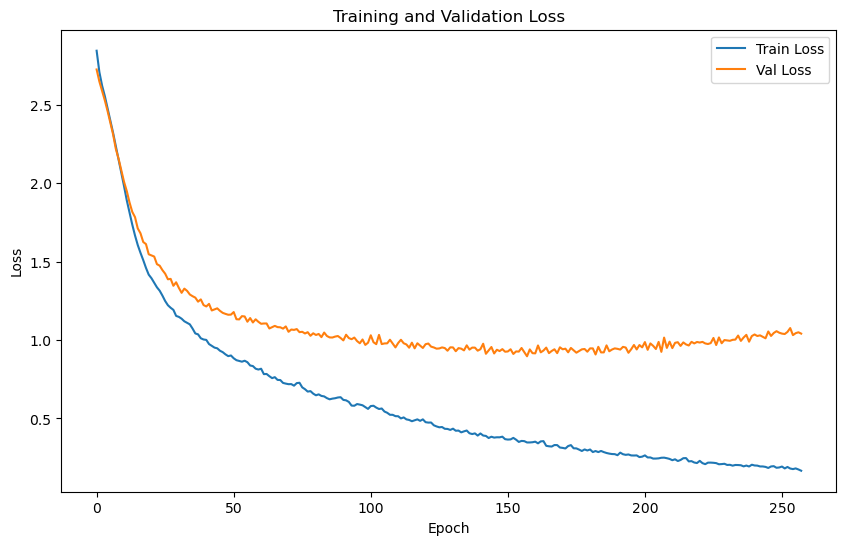

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8996 | Test Accuracy: 58.01%


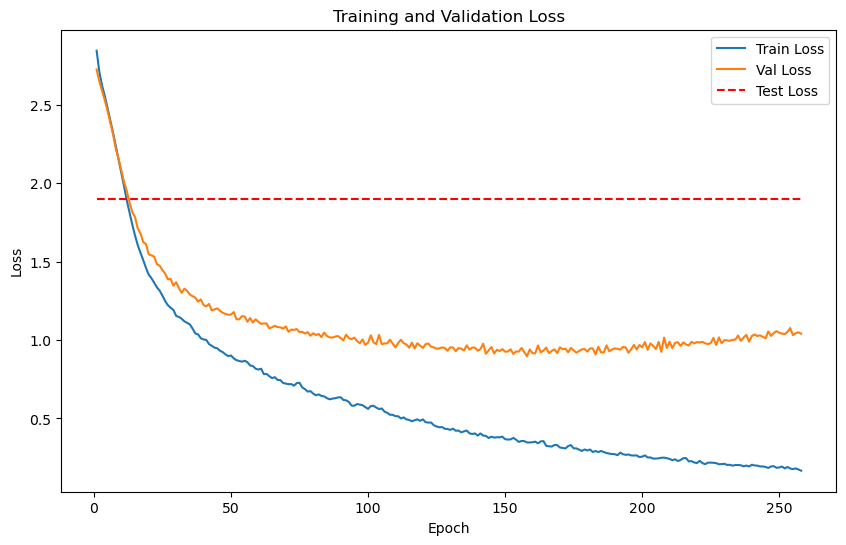

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.0235
Epoch [1/2000], Avg Train Loss: 9.0235
Epoch [1/2000], Avg Val Loss: 5.2850
Validation loss improved from inf to 5.2850. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.9730
Epoch [2/2000], Avg Train Loss: 8.9730
Epoch [2/2000], Avg Val Loss: 5.2190
Validation loss improved from 5.2850 to 5.2190. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.9328
Epoch [3/2000], Avg Train Loss: 8.9328
Epoch [3/2000], Avg Val Loss: 5.1548
Validation loss improved from 5.2190 to 5.1548. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.9233
Epoch [4/2000], Avg Train Loss: 8.9233
Epoch [4/2000], Avg Val Loss: 5.0926
Validation loss improved from 5.1548 to 5.0926. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.8326
Epoch [5/2000], Avg Train Loss: 8.8326
Epoch [5/2000], Avg Val Loss: 5.0322
Validation loss improved from 5.0926 to 5.0322. Saving mode

Epoch [12/2000], Avg Val Loss: 4.6564


Validation loss improved from 4.7052 to 4.6564. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.2109
Epoch [13/2000], Avg Train Loss: 8.2109
Epoch [13/2000], Avg Val Loss: 4.6092
Validation loss improved from 4.6564 to 4.6092. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.0354
Epoch [14/2000], Avg Train Loss: 8.0354
Epoch [14/2000], Avg Val Loss: 4.5636
Validation loss improved from 4.6092 to 4.5636. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.9536
Epoch [15/2000], Avg Train Loss: 7.9536
Epoch [15/2000], Avg Val Loss: 4.5195
Validation loss improved from 4.5636 to 4.5195. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.9209
Epoch [16/2000], Avg Train Loss: 7.9209
Epoch [16/2000], Avg Val Loss: 4.4769
Validation loss improved from 4.5195 to 4.4769. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.8203
Epoch [17/2000], Avg T

    Batch [1/1], Train Loss: 7.7339
Epoch [20/2000], Avg Train Loss: 7.7339
Epoch [20/2000], Avg Val Loss: 4.3211
Validation loss improved from 4.3580 to 4.3211. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.6812
Epoch [21/2000], Avg Train Loss: 7.6812
Epoch [21/2000], Avg Val Loss: 4.2855
Validation loss improved from 4.3211 to 4.2855. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.5156
Epoch [22/2000], Avg Train Loss: 7.5156
Epoch [22/2000], Avg Val Loss: 4.2514
Validation loss improved from 4.2855 to 4.2514. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.4855
Epoch [23/2000], Avg Train Loss: 7.4855
Epoch [23/2000], Avg Val Loss: 4.2184
Validation loss improved from 4.2514 to 4.2184. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.3646
Epoch [24/2000], Avg Train Loss: 7.3646
Epoch [24/2000], Avg Val Loss: 4.1867
Validation loss improved from 4.2184 to 4.

    Batch [1/1], Train Loss: 6.8573
Epoch [35/2000], Avg Train Loss: 6.8573
Epoch [35/2000], Avg Val Loss: 3.9107
Validation loss improved from 3.9308 to 3.9107. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.8226
Epoch [36/2000], Avg Train Loss: 6.8226
Epoch [36/2000], Avg Val Loss: 3.8913
Validation loss improved from 3.9107 to 3.8913. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.8021
Epoch [37/2000], Avg Train Loss: 6.8021
Epoch [37/2000], Avg Val Loss: 3.8728
Validation loss improved from 3.8913 to 3.8728. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.7113
Epoch [38/2000], Avg Train Loss: 6.7113
Epoch [38/2000], Avg Val Loss: 3.8551
Validation loss improved from 3.8728 to 3.8551. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.6213
Epoch [39/2000], Avg Train Loss: 6.6213
Epoch [39/2000], Avg Val Loss: 3.8382
Validation loss improved from 3.8551 to 3.

Epoch [47/2000], Avg Val Loss: 3.7279


Validation loss improved from 3.7396 to 3.7279. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.3545
Epoch [48/2000], Avg Train Loss: 6.3545
Epoch [48/2000], Avg Val Loss: 3.7166
Validation loss improved from 3.7279 to 3.7166. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.3041
Epoch [49/2000], Avg Train Loss: 6.3041
Epoch [49/2000], Avg Val Loss: 3.7059
Validation loss improved from 3.7166 to 3.7059. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2457
Epoch [50/2000], Avg Train Loss: 6.2457
Epoch [50/2000], Avg Val Loss: 3.6955
Validation loss improved from 3.7059 to 3.6955. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.2443
Epoch [51/2000], Avg Train Loss: 6.2443
Epoch [51/2000], Avg Val Loss: 3.6856
Validation loss improved from 3.6955 to 3.6856. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.2085
Epoch [52/2000], Avg T

    Batch [1/1], Train Loss: 6.1634
Epoch [55/2000], Avg Train Loss: 6.1634
Epoch [55/2000], Avg Val Loss: 3.6501
Validation loss improved from 3.6585 to 3.6501. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.0559
Epoch [56/2000], Avg Train Loss: 6.0559
Epoch [56/2000], Avg Val Loss: 3.6422
Validation loss improved from 3.6501 to 3.6422. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 6.1437
Epoch [57/2000], Avg Train Loss: 6.1437
Epoch [57/2000], Avg Val Loss: 3.6346
Validation loss improved from 3.6422 to 3.6346. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.9896
Epoch [58/2000], Avg Train Loss: 5.9896
Epoch [58/2000], Avg Val Loss: 3.6273
Validation loss improved from 3.6346 to 3.6273. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 6.0462
Epoch [59/2000], Avg Train Loss: 6.0462
Epoch [59/2000], Avg Val Loss: 3.6204
Validation loss improved from 3.6273 to 3.

    Batch [1/1], Train Loss: 5.8075
Epoch [70/2000], Avg Train Loss: 5.8075
Epoch [70/2000], Avg Val Loss: 3.5601
Validation loss improved from 3.5646 to 3.5601. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.8375
Epoch [71/2000], Avg Train Loss: 5.8375
Epoch [71/2000], Avg Val Loss: 3.5559
Validation loss improved from 3.5601 to 3.5559. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.8080
Epoch [72/2000], Avg Train Loss: 5.8080
Epoch [72/2000], Avg Val Loss: 3.5518
Validation loss improved from 3.5559 to 3.5518. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.7712
Epoch [73/2000], Avg Train Loss: 5.7712
Epoch [73/2000], Avg Val Loss: 3.5478
Validation loss improved from 3.5518 to 3.5478. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.7601
Epoch [74/2000], Avg Train Loss: 5.7601
Epoch [74/2000], Avg Val Loss: 3.5439
Validation loss improved from 3.5478 to 3.

Epoch [81/2000], Avg Val Loss: 3.5206
Validation loss improved from 3.5236 to 3.5206. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.6089
Epoch [82/2000], Avg Train Loss: 5.6089
Epoch [82/2000], Avg Val Loss: 3.5177
Validation loss improved from 3.5206 to 3.5177. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.6936
Epoch [83/2000], Avg Train Loss: 5.6936
Epoch [83/2000], Avg Val Loss: 3.5149
Validation loss improved from 3.5177 to 3.5149. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.5996
Epoch [84/2000], Avg Train Loss: 5.5996
Epoch [84/2000], Avg Val Loss: 3.5122
Validation loss improved from 3.5149 to 3.5122. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.6760
Epoch [85/2000], Avg Train Loss: 5.6760
Epoch [85/2000], Avg Val Loss: 3.5096
Validation loss improved from 3.5122 to 3.5096. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5149
Epoch [92/2000], Avg Train Loss: 5.5149
Epoch [92/2000], Avg Val Loss: 3.4928
Validation loss improved from 3.4951 to 3.4928. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.5805
Epoch [93/2000], Avg Train Loss: 5.5805
Epoch [93/2000], Avg Val Loss: 3.4907
Validation loss improved from 3.4928 to 3.4907. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.5276
Epoch [94/2000], Avg Train Loss: 5.5276
Epoch [94/2000], Avg Val Loss: 3.4885
Validation loss improved from 3.4907 to 3.4885. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.5122
Epoch [95/2000], Avg Train Loss: 5.5122
Epoch [95/2000], Avg Val Loss: 3.4864
Validation loss improved from 3.4885 to 3.4864. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.5468
Epoch [96/2000], Avg Train Loss: 5.5468
Epoch [96/2000], Avg Val Loss: 3.4844
Validation loss improved from 3.4864 to 3.

    Batch [1/1], Train Loss: 5.4551
Epoch [105/2000], Avg Train Loss: 5.4551
Epoch [105/2000], Avg Val Loss: 3.4679
Validation loss improved from 3.4696 to 3.4679. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.4182
Epoch [106/2000], Avg Train Loss: 5.4182
Epoch [106/2000], Avg Val Loss: 3.4662
Validation loss improved from 3.4679 to 3.4662. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.4220
Epoch [107/2000], Avg Train Loss: 5.4220
Epoch [107/2000], Avg Val Loss: 3.4645
Validation loss improved from 3.4662 to 3.4645. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.4306
Epoch [108/2000], Avg Train Loss: 5.4306
Epoch [108/2000], Avg Val Loss: 3.4628
Validation loss improved from 3.4645 to 3.4628. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4238
Epoch [109/2000], Avg Train Loss: 5.4238
Epoch [109/2000], Avg Val Loss: 3.4611
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3641
Epoch [117/2000], Avg Train Loss: 5.3641
Epoch [117/2000], Avg Val Loss: 3.4484
Validation loss improved from 3.4500 to 3.4484. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.4161
Epoch [118/2000], Avg Train Loss: 5.4161
Epoch [118/2000], Avg Val Loss: 3.4469
Validation loss improved from 3.4484 to 3.4469. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 5.3972
Epoch [119/2000], Avg Train Loss: 5.3972
Epoch [119/2000], Avg Val Loss: 3.4455
Validation loss improved from 3.4469 to 3.4455. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 5.3700
Epoch [120/2000], Avg Train Loss: 5.3700
Epoch [120/2000], Avg Val Loss: 3.4440
Validation loss improved from 3.4455 to 3.4440. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 5.3617
Epoch [121/2000], Avg Train Loss: 5.3617
Epoch [121/2000], Avg Val Loss: 3.4426
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3154
Epoch [127/2000], Avg Train Loss: 5.3154
Epoch [127/2000], Avg Val Loss: 3.4345
Validation loss improved from 3.4358 to 3.4345. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 5.3624
Epoch [128/2000], Avg Train Loss: 5.3624
Epoch [128/2000], Avg Val Loss: 3.4331
Validation loss improved from 3.4345 to 3.4331. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 5.3394
Epoch [129/2000], Avg Train Loss: 5.3394
Epoch [129/2000], Avg Val Loss: 3.4318
Validation loss improved from 3.4331 to 3.4318. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.3351
Epoch [130/2000], Avg Train Loss: 5.3351
Epoch [130/2000], Avg Val Loss: 3.4305
Validation loss improved from 3.4318 to 3.4305. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.3678
Epoch [131/2000], Avg Train Loss: 5.3678
Epoch [131/2000], Avg Val Loss: 3.4292
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2665
Epoch [143/2000], Avg Train Loss: 5.2665
Epoch [143/2000], Avg Val Loss: 3.4142
Validation loss improved from 3.4155 to 3.4142. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.2895
Epoch [144/2000], Avg Train Loss: 5.2895
Epoch [144/2000], Avg Val Loss: 3.4130
Validation loss improved from 3.4142 to 3.4130. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.2831
Epoch [145/2000], Avg Train Loss: 5.2831
Epoch [145/2000], Avg Val Loss: 3.4119
Validation loss improved from 3.4130 to 3.4119. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2368
Epoch [146/2000], Avg Train Loss: 5.2368
Epoch [146/2000], Avg Val Loss: 3.4107
Validation loss improved from 3.4119 to 3.4107. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2356
Epoch [147/2000], Avg Train Loss: 5.2356
Epoch [147/2000], Avg Val Loss: 3.4095
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2658
Epoch [154/2000], Avg Train Loss: 5.2658
Epoch [154/2000], Avg Val Loss: 3.4015
Validation loss improved from 3.4027 to 3.4015. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 5.2567
Epoch [155/2000], Avg Train Loss: 5.2567
Epoch [155/2000], Avg Val Loss: 3.4004
Validation loss improved from 3.4015 to 3.4004. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 5.2379
Epoch [156/2000], Avg Train Loss: 5.2379
Epoch [156/2000], Avg Val Loss: 3.3992
Validation loss improved from 3.4004 to 3.3992. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 5.2012
Epoch [157/2000], Avg Train Loss: 5.2012
Epoch [157/2000], Avg Val Loss: 3.3981
Validation loss improved from 3.3992 to 3.3981. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 5.2307
Epoch [158/2000], Avg Train Loss: 5.2307
Epoch [158/2000], Avg Val Loss: 3.3970
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1871
Epoch [165/2000], Avg Train Loss: 5.1871
Epoch [165/2000], Avg Val Loss: 3.3891
Validation loss improved from 3.3902 to 3.3891. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 5.1945
Epoch [166/2000], Avg Train Loss: 5.1945
Epoch [166/2000], Avg Val Loss: 3.3880
Validation loss improved from 3.3891 to 3.3880. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.2309
Epoch [167/2000], Avg Train Loss: 5.2309
Epoch [167/2000], Avg Val Loss: 3.3869
Validation loss improved from 3.3880 to 3.3869. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.2166
Epoch [168/2000], Avg Train Loss: 5.2166
Epoch [168/2000], Avg Val Loss: 3.3858
Validation loss improved from 3.3869 to 3.3858. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.1664
Epoch [169/2000], Avg Train Loss: 5.1664
Epoch [169/2000], Avg Val Loss: 3.3847
Validation loss improved fro

Epoch [180/2000], Avg Val Loss: 3.3732
Validation loss improved from 3.3742 to 3.3732. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.1329
Epoch [181/2000], Avg Train Loss: 5.1329
Epoch [181/2000], Avg Val Loss: 3.3722
Validation loss improved from 3.3732 to 3.3722. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.1275
Epoch [182/2000], Avg Train Loss: 5.1275
Epoch [182/2000], Avg Val Loss: 3.3712
Validation loss improved from 3.3722 to 3.3712. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.1671
Epoch [183/2000], Avg Train Loss: 5.1671
Epoch [183/2000], Avg Val Loss: 3.3702
Validation loss improved from 3.3712 to 3.3702. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.1906
Epoch [184/2000], Avg Train Loss: 5.1906
Epoch [184/2000], Avg Val Loss: 3.3692
Validation loss improved from 3.3702 to 3.3692. Saving model...

LOG: Epoch [185/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1529
Epoch [191/2000], Avg Train Loss: 5.1529
Epoch [191/2000], Avg Val Loss: 3.3627
Validation loss improved from 3.3636 to 3.3627. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 5.1215
Epoch [192/2000], Avg Train Loss: 5.1215
Epoch [192/2000], Avg Val Loss: 3.3618
Validation loss improved from 3.3627 to 3.3618. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 5.1550
Epoch [193/2000], Avg Train Loss: 5.1550
Epoch [193/2000], Avg Val Loss: 3.3610
Validation loss improved from 3.3618 to 3.3610. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 5.1157
Epoch [194/2000], Avg Train Loss: 5.1157
Epoch [194/2000], Avg Val Loss: 3.3601
Validation loss improved from 3.3610 to 3.3601. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 5.1319
Epoch [195/2000], Avg Train Loss: 5.1319
Epoch [195/2000], Avg Val Loss: 3.3593
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1282
Epoch [199/2000], Avg Train Loss: 5.1282
Epoch [199/2000], Avg Val Loss: 3.3557
Validation loss improved from 3.3566 to 3.3557. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 5.1575
Epoch [200/2000], Avg Train Loss: 5.1575
Epoch [200/2000], Avg Val Loss: 3.3549
Validation loss improved from 3.3557 to 3.3549. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.1071
Epoch [201/2000], Avg Train Loss: 5.1071
Epoch [201/2000], Avg Val Loss: 3.3540
Validation loss improved from 3.3549 to 3.3540. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.0954
Epoch [202/2000], Avg Train Loss: 5.0954
Epoch [202/2000], Avg Val Loss: 3.3531
Validation loss improved from 3.3540 to 3.3531. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.0467
Epoch [203/2000], Avg Train Loss: 5.0467
Epoch [203/2000], Avg Val Loss: 3.3522
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0690
Epoch [218/2000], Avg Train Loss: 5.0690
Epoch [218/2000], Avg Val Loss: 3.3396
Validation loss improved from 3.3404 to 3.3396. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 5.0570
Epoch [219/2000], Avg Train Loss: 5.0570
Epoch [219/2000], Avg Val Loss: 3.3387
Validation loss improved from 3.3396 to 3.3387. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 5.0793
Epoch [220/2000], Avg Train Loss: 5.0793
Epoch [220/2000], Avg Val Loss: 3.3379
Validation loss improved from 3.3387 to 3.3379. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 5.0283
Epoch [221/2000], Avg Train Loss: 5.0283
Epoch [221/2000], Avg Val Loss: 3.3371
Validation loss improved from 3.3379 to 3.3371. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 5.0476
Epoch [222/2000], Avg Train Loss: 5.0476
Epoch [222/2000], Avg Val Loss: 3.3363
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0361
Epoch [228/2000], Avg Train Loss: 5.0361
Epoch [228/2000], Avg Val Loss: 3.3315
Validation loss improved from 3.3322 to 3.3315. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 5.0864
Epoch [229/2000], Avg Train Loss: 5.0864
Epoch [229/2000], Avg Val Loss: 3.3307
Validation loss improved from 3.3315 to 3.3307. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 5.0447
Epoch [230/2000], Avg Train Loss: 5.0447
Epoch [230/2000], Avg Val Loss: 3.3299
Validation loss improved from 3.3307 to 3.3299. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 5.0345
Epoch [231/2000], Avg Train Loss: 5.0345
Epoch [231/2000], Avg Val Loss: 3.3291
Validation loss improved from 3.3299 to 3.3291. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 5.0378
Epoch [232/2000], Avg Train Loss: 5.0378
Epoch [232/2000], Avg Val Loss: 3.3283
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0285
Epoch [235/2000], Avg Train Loss: 5.0285
Epoch [235/2000], Avg Val Loss: 3.3261
Validation loss improved from 3.3268 to 3.3261. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 5.0179
Epoch [236/2000], Avg Train Loss: 5.0179
Epoch [236/2000], Avg Val Loss: 3.3253
Validation loss improved from 3.3261 to 3.3253. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 5.0090
Epoch [237/2000], Avg Train Loss: 5.0090
Epoch [237/2000], Avg Val Loss: 3.3245
Validation loss improved from 3.3253 to 3.3245. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 5.0406
Epoch [238/2000], Avg Train Loss: 5.0406
Epoch [238/2000], Avg Val Loss: 3.3238
Validation loss improved from 3.3245 to 3.3238. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 5.0373
Epoch [239/2000], Avg Train Loss: 5.0373
Epoch [239/2000], Avg Val Loss: 3.3230
Validation loss improved fro

Epoch [253/2000], Avg Val Loss: 3.3124
Validation loss improved from 3.3132 to 3.3124. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 5.0062
Epoch [254/2000], Avg Train Loss: 5.0062
Epoch [254/2000], Avg Val Loss: 3.3117
Validation loss improved from 3.3124 to 3.3117. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.9593
Epoch [255/2000], Avg Train Loss: 4.9593
Epoch [255/2000], Avg Val Loss: 3.3110
Validation loss improved from 3.3117 to 3.3110. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.9878
Epoch [256/2000], Avg Train Loss: 4.9878
Epoch [256/2000], Avg Val Loss: 3.3103
Validation loss improved from 3.3110 to 3.3103. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.9949
Epoch [257/2000], Avg Train Loss: 4.9949
Epoch [257/2000], Avg Val Loss: 3.3095
Validation loss improved from 3.3103 to 3.3095. Saving model...

LOG: Epoch [258/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9898
Epoch [263/2000], Avg Train Loss: 4.9898
Epoch [263/2000], Avg Val Loss: 3.3052
Validation loss improved from 3.3059 to 3.3052. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 5.0173
Epoch [264/2000], Avg Train Loss: 5.0173
Epoch [264/2000], Avg Val Loss: 3.3045
Validation loss improved from 3.3052 to 3.3045. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.9987
Epoch [265/2000], Avg Train Loss: 4.9987
Epoch [265/2000], Avg Val Loss: 3.3038
Validation loss improved from 3.3045 to 3.3038. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.9619
Epoch [266/2000], Avg Train Loss: 4.9619
Epoch [266/2000], Avg Val Loss: 3.3031
Validation loss improved from 3.3038 to 3.3031. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 5.0222
Epoch [267/2000], Avg Train Loss: 5.0222
Epoch [267/2000], Avg Val Loss: 3.3025
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9333
Epoch [271/2000], Avg Train Loss: 4.9333
Epoch [271/2000], Avg Val Loss: 3.2999
Validation loss improved from 3.3005 to 3.2999. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.9334
Epoch [272/2000], Avg Train Loss: 4.9334
Epoch [272/2000], Avg Val Loss: 3.2993
Validation loss improved from 3.2999 to 3.2993. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.9942
Epoch [273/2000], Avg Train Loss: 4.9942
Epoch [273/2000], Avg Val Loss: 3.2986
Validation loss improved from 3.2993 to 3.2986. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.9348
Epoch [274/2000], Avg Train Loss: 4.9348
Epoch [274/2000], Avg Val Loss: 3.2980
Validation loss improved from 3.2986 to 3.2980. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.9790
Epoch [275/2000], Avg Train Loss: 4.9790
Epoch [275/2000], Avg Val Loss: 3.2974
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9143
Epoch [290/2000], Avg Train Loss: 4.9143
Epoch [290/2000], Avg Val Loss: 3.2877
Validation loss improved from 3.2884 to 3.2877. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.8990
Epoch [291/2000], Avg Train Loss: 4.8990
Epoch [291/2000], Avg Val Loss: 3.2871
Validation loss improved from 3.2877 to 3.2871. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.9033
Epoch [292/2000], Avg Train Loss: 4.9033
Epoch [292/2000], Avg Val Loss: 3.2865
Validation loss improved from 3.2871 to 3.2865. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.8987
Epoch [293/2000], Avg Train Loss: 4.8987
Epoch [293/2000], Avg Val Loss: 3.2858
Validation loss improved from 3.2865 to 3.2858. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.9232
Epoch [294/2000], Avg Train Loss: 4.9232
Epoch [294/2000], Avg Val Loss: 3.2852
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8983
Epoch [298/2000], Avg Train Loss: 4.8983
Epoch [298/2000], Avg Val Loss: 3.2827
Validation loss improved from 3.2834 to 3.2827. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.9434
Epoch [299/2000], Avg Train Loss: 4.9434
Epoch [299/2000], Avg Val Loss: 3.2821
Validation loss improved from 3.2827 to 3.2821. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.9385
Epoch [300/2000], Avg Train Loss: 4.9385
Epoch [300/2000], Avg Val Loss: 3.2814
Validation loss improved from 3.2821 to 3.2814. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.9302
Epoch [301/2000], Avg Train Loss: 4.9302
Epoch [301/2000], Avg Val Loss: 3.2808
Validation loss improved from 3.2814 to 3.2808. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.9013
Epoch [302/2000], Avg Train Loss: 4.9013
Epoch [302/2000], Avg Val Loss: 3.2803
Validation loss improved fro

Epoch [306/2000], Avg Val Loss: 3.2781
Validation loss improved from 3.2786 to 3.2781. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.9251
Epoch [307/2000], Avg Train Loss: 4.9251
Epoch [307/2000], Avg Val Loss: 3.2775
Validation loss improved from 3.2781 to 3.2775. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.9265
Epoch [308/2000], Avg Train Loss: 4.9265
Epoch [308/2000], Avg Val Loss: 3.2770
Validation loss improved from 3.2775 to 3.2770. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.9169
Epoch [309/2000], Avg Train Loss: 4.9169
Epoch [309/2000], Avg Val Loss: 3.2765
Validation loss improved from 3.2770 to 3.2765. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 4.9259
Epoch [310/2000], Avg Train Loss: 4.9259
Epoch [310/2000], Avg Val Loss: 3.2760
Validation loss improved from 3.2765 to 3.2760. Saving model...

LOG: Epoch [311/2000] - Training
    Bat

Epoch [327/2000], Avg Val Loss: 3.2664
Validation loss improved from 3.2670 to 3.2664. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8936
Epoch [328/2000], Avg Train Loss: 4.8936
Epoch [328/2000], Avg Val Loss: 3.2659
Validation loss improved from 3.2664 to 3.2659. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.8652
Epoch [329/2000], Avg Train Loss: 4.8652
Epoch [329/2000], Avg Val Loss: 3.2654
Validation loss improved from 3.2659 to 3.2654. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.8479
Epoch [330/2000], Avg Train Loss: 4.8479
Epoch [330/2000], Avg Val Loss: 3.2648
Validation loss improved from 3.2654 to 3.2648. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.8616
Epoch [331/2000], Avg Train Loss: 4.8616
Epoch [331/2000], Avg Val Loss: 3.2643
Validation loss improved from 3.2648 to 3.2643. Saving model...

LOG: Epoch [332/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8825
Epoch [336/2000], Avg Train Loss: 4.8825
Epoch [336/2000], Avg Val Loss: 3.2617
Validation loss improved from 3.2623 to 3.2617. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.8751
Epoch [337/2000], Avg Train Loss: 4.8751
Epoch [337/2000], Avg Val Loss: 3.2612
Validation loss improved from 3.2617 to 3.2612. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.8684
Epoch [338/2000], Avg Train Loss: 4.8684
Epoch [338/2000], Avg Val Loss: 3.2607
Validation loss improved from 3.2612 to 3.2607. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.8526
Epoch [339/2000], Avg Train Loss: 4.8526
Epoch [339/2000], Avg Val Loss: 3.2602
Validation loss improved from 3.2607 to 3.2602. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.8457
Epoch [340/2000], Avg Train Loss: 4.8457
Epoch [340/2000], Avg Val Loss: 3.2597
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8339
Epoch [344/2000], Avg Train Loss: 4.8339
Epoch [344/2000], Avg Val Loss: 3.2577
Validation loss improved from 3.2582 to 3.2577. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.8645
Epoch [345/2000], Avg Train Loss: 4.8645
Epoch [345/2000], Avg Val Loss: 3.2572
Validation loss improved from 3.2577 to 3.2572. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.8035
Epoch [346/2000], Avg Train Loss: 4.8035
Epoch [346/2000], Avg Val Loss: 3.2567
Validation loss improved from 3.2572 to 3.2567. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.8525
Epoch [347/2000], Avg Train Loss: 4.8525
Epoch [347/2000], Avg Val Loss: 3.2562
Validation loss improved from 3.2567 to 3.2562. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.8313
Epoch [348/2000], Avg Train Loss: 4.8313
Epoch [348/2000], Avg Val Loss: 3.2557
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8284
Epoch [364/2000], Avg Train Loss: 4.8284
Epoch [364/2000], Avg Val Loss: 3.2479
Validation loss improved from 3.2484 to 3.2479. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 4.8329
Epoch [365/2000], Avg Train Loss: 4.8329
Epoch [365/2000], Avg Val Loss: 3.2474
Validation loss improved from 3.2479 to 3.2474. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.8269
Epoch [366/2000], Avg Train Loss: 4.8269
Epoch [366/2000], Avg Val Loss: 3.2469
Validation loss improved from 3.2474 to 3.2469. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.8506
Epoch [367/2000], Avg Train Loss: 4.8506
Epoch [367/2000], Avg Val Loss: 3.2465
Validation loss improved from 3.2469 to 3.2465. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.8072
Epoch [368/2000], Avg Train Loss: 4.8072
Epoch [368/2000], Avg Val Loss: 3.2460
Validation loss improved fro

Epoch [371/2000], Avg Val Loss: 3.2446
Validation loss improved from 3.2451 to 3.2446. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.8180
Epoch [372/2000], Avg Train Loss: 4.8180
Epoch [372/2000], Avg Val Loss: 3.2441
Validation loss improved from 3.2446 to 3.2441. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.8276
Epoch [373/2000], Avg Train Loss: 4.8276
Epoch [373/2000], Avg Val Loss: 3.2436
Validation loss improved from 3.2441 to 3.2436. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.7912
Epoch [374/2000], Avg Train Loss: 4.7912
Epoch [374/2000], Avg Val Loss: 3.2432
Validation loss improved from 3.2436 to 3.2432. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.7770
Epoch [375/2000], Avg Train Loss: 4.7770
Epoch [375/2000], Avg Val Loss: 3.2427
Validation loss improved from 3.2432 to 3.2427. Saving model...

LOG: Epoch [376/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8073
Epoch [379/2000], Avg Train Loss: 4.8073
Epoch [379/2000], Avg Val Loss: 3.2408
Validation loss improved from 3.2413 to 3.2408. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.7883
Epoch [380/2000], Avg Train Loss: 4.7883
Epoch [380/2000], Avg Val Loss: 3.2404
Validation loss improved from 3.2408 to 3.2404. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.8051
Epoch [381/2000], Avg Train Loss: 4.8051
Epoch [381/2000], Avg Val Loss: 3.2399
Validation loss improved from 3.2404 to 3.2399. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.7740
Epoch [382/2000], Avg Train Loss: 4.7740
Epoch [382/2000], Avg Val Loss: 3.2395
Validation loss improved from 3.2399 to 3.2395. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.7875
Epoch [383/2000], Avg Train Loss: 4.7875
Epoch [383/2000], Avg Val Loss: 3.2391
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7976
Epoch [400/2000], Avg Train Loss: 4.7976
Epoch [400/2000], Avg Val Loss: 3.2314
Validation loss improved from 3.2319 to 3.2314. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.7526
Epoch [401/2000], Avg Train Loss: 4.7526
Epoch [401/2000], Avg Val Loss: 3.2309
Validation loss improved from 3.2314 to 3.2309. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 4.7816
Epoch [402/2000], Avg Train Loss: 4.7816
Epoch [402/2000], Avg Val Loss: 3.2305
Validation loss improved from 3.2309 to 3.2305. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.7961
Epoch [403/2000], Avg Train Loss: 4.7961
Epoch [403/2000], Avg Val Loss: 3.2300
Validation loss improved from 3.2305 to 3.2300. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.7702
Epoch [404/2000], Avg Train Loss: 4.7702
Epoch [404/2000], Avg Val Loss: 3.2295
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7554
Epoch [408/2000], Avg Train Loss: 4.7554
Epoch [408/2000], Avg Val Loss: 3.2276
Validation loss improved from 3.2281 to 3.2276. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.7602
Epoch [409/2000], Avg Train Loss: 4.7602
Epoch [409/2000], Avg Val Loss: 3.2271
Validation loss improved from 3.2276 to 3.2271. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.7662
Epoch [410/2000], Avg Train Loss: 4.7662
Epoch [410/2000], Avg Val Loss: 3.2266
Validation loss improved from 3.2271 to 3.2266. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.7813
Epoch [411/2000], Avg Train Loss: 4.7813
Epoch [411/2000], Avg Val Loss: 3.2262
Validation loss improved from 3.2266 to 3.2262. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.7538
Epoch [412/2000], Avg Train Loss: 4.7538
Epoch [412/2000], Avg Val Loss: 3.2257
Validation loss improved fro

Epoch [418/2000], Avg Val Loss: 3.2228
Validation loss improved from 3.2233 to 3.2228. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.7421
Epoch [419/2000], Avg Train Loss: 4.7421
Epoch [419/2000], Avg Val Loss: 3.2224
Validation loss improved from 3.2228 to 3.2224. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.7471
Epoch [420/2000], Avg Train Loss: 4.7471
Epoch [420/2000], Avg Val Loss: 3.2219
Validation loss improved from 3.2224 to 3.2219. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.7677
Epoch [421/2000], Avg Train Loss: 4.7677
Epoch [421/2000], Avg Val Loss: 3.2215
Validation loss improved from 3.2219 to 3.2215. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.7621
Epoch [422/2000], Avg Train Loss: 4.7621
Epoch [422/2000], Avg Val Loss: 3.2211
Validation loss improved from 3.2215 to 3.2211. Saving model...

LOG: Epoch [423/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7495
Epoch [438/2000], Avg Train Loss: 4.7495
Epoch [438/2000], Avg Val Loss: 3.2144
Validation loss improved from 3.2148 to 3.2144. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.7405
Epoch [439/2000], Avg Train Loss: 4.7405
Epoch [439/2000], Avg Val Loss: 3.2140
Validation loss improved from 3.2144 to 3.2140. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.7296
Epoch [440/2000], Avg Train Loss: 4.7296
Epoch [440/2000], Avg Val Loss: 3.2136
Validation loss improved from 3.2140 to 3.2136. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.7750
Epoch [441/2000], Avg Train Loss: 4.7750
Epoch [441/2000], Avg Val Loss: 3.2131
Validation loss improved from 3.2136 to 3.2131. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.7590
Epoch [442/2000], Avg Train Loss: 4.7590
Epoch [442/2000], Avg Val Loss: 3.2127
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7231
Epoch [445/2000], Avg Train Loss: 4.7231
Epoch [445/2000], Avg Val Loss: 3.2114
Validation loss improved from 3.2119 to 3.2114. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.7483
Epoch [446/2000], Avg Train Loss: 4.7483
Epoch [446/2000], Avg Val Loss: 3.2110
Validation loss improved from 3.2114 to 3.2110. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.7350
Epoch [447/2000], Avg Train Loss: 4.7350
Epoch [447/2000], Avg Val Loss: 3.2105
Validation loss improved from 3.2110 to 3.2105. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.7605
Epoch [448/2000], Avg Train Loss: 4.7605
Epoch [448/2000], Avg Val Loss: 3.2101
Validation loss improved from 3.2105 to 3.2101. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.7304
Epoch [449/2000], Avg Train Loss: 4.7304
Epoch [449/2000], Avg Val Loss: 3.2097
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7123
Epoch [453/2000], Avg Train Loss: 4.7123
Epoch [453/2000], Avg Val Loss: 3.2082
Validation loss improved from 3.2086 to 3.2082. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 4.7112
Epoch [454/2000], Avg Train Loss: 4.7112
Epoch [454/2000], Avg Val Loss: 3.2078
Validation loss improved from 3.2082 to 3.2078. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.7267
Epoch [455/2000], Avg Train Loss: 4.7267
Epoch [455/2000], Avg Val Loss: 3.2074
Validation loss improved from 3.2078 to 3.2074. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 4.7095
Epoch [456/2000], Avg Train Loss: 4.7095
Epoch [456/2000], Avg Val Loss: 3.2070
Validation loss improved from 3.2074 to 3.2070. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.7211
Epoch [457/2000], Avg Train Loss: 4.7211
Epoch [457/2000], Avg Val Loss: 3.2066
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7416
Epoch [473/2000], Avg Train Loss: 4.7416
Epoch [473/2000], Avg Val Loss: 3.1999
Validation loss improved from 3.2003 to 3.1999. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.6937
Epoch [474/2000], Avg Train Loss: 4.6937
Epoch [474/2000], Avg Val Loss: 3.1995
Validation loss improved from 3.1999 to 3.1995. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.7048
Epoch [475/2000], Avg Train Loss: 4.7048
Epoch [475/2000], Avg Val Loss: 3.1991
Validation loss improved from 3.1995 to 3.1991. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.6573
Epoch [476/2000], Avg Train Loss: 4.6573
Epoch [476/2000], Avg Val Loss: 3.1987
Validation loss improved from 3.1991 to 3.1987. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.7305
Epoch [477/2000], Avg Train Loss: 4.7305
Epoch [477/2000], Avg Val Loss: 3.1983
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6915
Epoch [484/2000], Avg Train Loss: 4.6915
Epoch [484/2000], Avg Val Loss: 3.1952
Validation loss improved from 3.1956 to 3.1952. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 4.7062
Epoch [485/2000], Avg Train Loss: 4.7062
Epoch [485/2000], Avg Val Loss: 3.1947
Validation loss improved from 3.1952 to 3.1947. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.6989
Epoch [486/2000], Avg Train Loss: 4.6989
Epoch [486/2000], Avg Val Loss: 3.1943
Validation loss improved from 3.1947 to 3.1943. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.6671
Epoch [487/2000], Avg Train Loss: 4.6671
Epoch [487/2000], Avg Val Loss: 3.1938
Validation loss improved from 3.1943 to 3.1938. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.7081
Epoch [488/2000], Avg Train Loss: 4.7081
Epoch [488/2000], Avg Val Loss: 3.1934
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7043
Epoch [492/2000], Avg Train Loss: 4.7043
Epoch [492/2000], Avg Val Loss: 3.1916
Validation loss improved from 3.1921 to 3.1916. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.6631
Epoch [493/2000], Avg Train Loss: 4.6631
Epoch [493/2000], Avg Val Loss: 3.1912
Validation loss improved from 3.1916 to 3.1912. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.7117
Epoch [494/2000], Avg Train Loss: 4.7117
Epoch [494/2000], Avg Val Loss: 3.1908
Validation loss improved from 3.1912 to 3.1908. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.6755
Epoch [495/2000], Avg Train Loss: 4.6755
Epoch [495/2000], Avg Val Loss: 3.1904
Validation loss improved from 3.1908 to 3.1904. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.7177
Epoch [496/2000], Avg Train Loss: 4.7177
Epoch [496/2000], Avg Val Loss: 3.1900
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6759
Epoch [511/2000], Avg Train Loss: 4.6759
Epoch [511/2000], Avg Val Loss: 3.1843
Validation loss improved from 3.1847 to 3.1843. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.6552
Epoch [512/2000], Avg Train Loss: 4.6552
Epoch [512/2000], Avg Val Loss: 3.1840
Validation loss improved from 3.1843 to 3.1840. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.6506
Epoch [513/2000], Avg Train Loss: 4.6506
Epoch [513/2000], Avg Val Loss: 3.1836
Validation loss improved from 3.1840 to 3.1836. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.6572
Epoch [514/2000], Avg Train Loss: 4.6572
Epoch [514/2000], Avg Val Loss: 3.1832
Validation loss improved from 3.1836 to 3.1832. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.6805
Epoch [515/2000], Avg Train Loss: 4.6805
Epoch [515/2000], Avg Val Loss: 3.1828
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6531
Epoch [520/2000], Avg Train Loss: 4.6531
Epoch [520/2000], Avg Val Loss: 3.1809
Validation loss improved from 3.1813 to 3.1809. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.6613
Epoch [521/2000], Avg Train Loss: 4.6613
Epoch [521/2000], Avg Val Loss: 3.1805
Validation loss improved from 3.1809 to 3.1805. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.6746
Epoch [522/2000], Avg Train Loss: 4.6746
Epoch [522/2000], Avg Val Loss: 3.1801
Validation loss improved from 3.1805 to 3.1801. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.6490
Epoch [523/2000], Avg Train Loss: 4.6490
Epoch [523/2000], Avg Val Loss: 3.1797
Validation loss improved from 3.1801 to 3.1797. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.6503
Epoch [524/2000], Avg Train Loss: 4.6503
Epoch [524/2000], Avg Val Loss: 3.1793
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6386
Epoch [531/2000], Avg Train Loss: 4.6386
Epoch [531/2000], Avg Val Loss: 3.1764
Validation loss improved from 3.1768 to 3.1764. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.6660
Epoch [532/2000], Avg Train Loss: 4.6660
Epoch [532/2000], Avg Val Loss: 3.1760
Validation loss improved from 3.1764 to 3.1760. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 4.6237
Epoch [533/2000], Avg Train Loss: 4.6237
Epoch [533/2000], Avg Val Loss: 3.1756
Validation loss improved from 3.1760 to 3.1756. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.6461
Epoch [534/2000], Avg Train Loss: 4.6461
Epoch [534/2000], Avg Val Loss: 3.1753
Validation loss improved from 3.1756 to 3.1753. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.6615
Epoch [535/2000], Avg Train Loss: 4.6615
Epoch [535/2000], Avg Val Loss: 3.1750
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6673
Epoch [549/2000], Avg Train Loss: 4.6673
Epoch [549/2000], Avg Val Loss: 3.1713
Validation loss improved from 3.1716 to 3.1713. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.6422
Epoch [550/2000], Avg Train Loss: 4.6422
Epoch [550/2000], Avg Val Loss: 3.1711
Validation loss improved from 3.1713 to 3.1711. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.6458
Epoch [551/2000], Avg Train Loss: 4.6458
Epoch [551/2000], Avg Val Loss: 3.1707
Validation loss improved from 3.1711 to 3.1707. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.6341
Epoch [552/2000], Avg Train Loss: 4.6341
Epoch [552/2000], Avg Val Loss: 3.1704
Validation loss improved from 3.1707 to 3.1704. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.6150
Epoch [553/2000], Avg Train Loss: 4.6150
Epoch [553/2000], Avg Val Loss: 3.1701
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6671
Epoch [556/2000], Avg Train Loss: 4.6671
Epoch [556/2000], Avg Val Loss: 3.1690
Validation loss improved from 3.1693 to 3.1690. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.6475
Epoch [557/2000], Avg Train Loss: 4.6475
Epoch [557/2000], Avg Val Loss: 3.1686
Validation loss improved from 3.1690 to 3.1686. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 4.6375
Epoch [558/2000], Avg Train Loss: 4.6375
Epoch [558/2000], Avg Val Loss: 3.1682
Validation loss improved from 3.1686 to 3.1682. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.6164
Epoch [559/2000], Avg Train Loss: 4.6164
Epoch [559/2000], Avg Val Loss: 3.1678
Validation loss improved from 3.1682 to 3.1678. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 4.6261
Epoch [560/2000], Avg Train Loss: 4.6261
Epoch [560/2000], Avg Val Loss: 3.1675
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6339
Epoch [565/2000], Avg Train Loss: 4.6339
Epoch [565/2000], Avg Val Loss: 3.1659
Validation loss improved from 3.1662 to 3.1659. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.6162
Epoch [566/2000], Avg Train Loss: 4.6162
Epoch [566/2000], Avg Val Loss: 3.1656
Validation loss improved from 3.1659 to 3.1656. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.6139
Epoch [567/2000], Avg Train Loss: 4.6139
Epoch [567/2000], Avg Val Loss: 3.1653
Validation loss improved from 3.1656 to 3.1653. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.6270
Epoch [568/2000], Avg Train Loss: 4.6270
Epoch [568/2000], Avg Val Loss: 3.1650
Validation loss improved from 3.1653 to 3.1650. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.6243
Epoch [569/2000], Avg Train Loss: 4.6243
Epoch [569/2000], Avg Val Loss: 3.1647
Validation loss improved fro

Epoch [581/2000], Avg Val Loss: 3.1609
Validation loss improved from 3.1612 to 3.1609. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.5563
Epoch [582/2000], Avg Train Loss: 4.5563
Epoch [582/2000], Avg Val Loss: 3.1606
Validation loss improved from 3.1609 to 3.1606. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.6114
Epoch [583/2000], Avg Train Loss: 4.6114
Epoch [583/2000], Avg Val Loss: 3.1603
Validation loss improved from 3.1606 to 3.1603. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.6064
Epoch [584/2000], Avg Train Loss: 4.6064
Epoch [584/2000], Avg Val Loss: 3.1600
Validation loss improved from 3.1603 to 3.1600. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 4.5832
Epoch [585/2000], Avg Train Loss: 4.5832
Epoch [585/2000], Avg Val Loss: 3.1597
Validation loss improved from 3.1600 to 3.1597. Saving model...

LOG: Epoch [586/2000] - Training
    Bat

Epoch [591/2000], Avg Val Loss: 3.1577
Validation loss improved from 3.1581 to 3.1577. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.6003
Epoch [592/2000], Avg Train Loss: 4.6003
Epoch [592/2000], Avg Val Loss: 3.1574
Validation loss improved from 3.1577 to 3.1574. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.6240
Epoch [593/2000], Avg Train Loss: 4.6240
Epoch [593/2000], Avg Val Loss: 3.1571
Validation loss improved from 3.1574 to 3.1571. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 4.5973
Epoch [594/2000], Avg Train Loss: 4.5973
Epoch [594/2000], Avg Val Loss: 3.1568
Validation loss improved from 3.1571 to 3.1568. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.5764
Epoch [595/2000], Avg Train Loss: 4.5764
Epoch [595/2000], Avg Val Loss: 3.1564
Validation loss improved from 3.1568 to 3.1564. Saving model...

LOG: Epoch [596/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5912
Epoch [602/2000], Avg Train Loss: 4.5912
Epoch [602/2000], Avg Val Loss: 3.1541
Validation loss improved from 3.1544 to 3.1541. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 4.5879
Epoch [603/2000], Avg Train Loss: 4.5879
Epoch [603/2000], Avg Val Loss: 3.1539
Validation loss improved from 3.1541 to 3.1539. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 4.5481
Epoch [604/2000], Avg Train Loss: 4.5481
Epoch [604/2000], Avg Val Loss: 3.1536
Validation loss improved from 3.1539 to 3.1536. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.5534
Epoch [605/2000], Avg Train Loss: 4.5534
Epoch [605/2000], Avg Val Loss: 3.1534
Validation loss improved from 3.1536 to 3.1534. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 4.6175
Epoch [606/2000], Avg Train Loss: 4.6175
Epoch [606/2000], Avg Val Loss: 3.1532
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5281
Epoch [617/2000], Avg Train Loss: 4.5281
Epoch [617/2000], Avg Val Loss: 3.1504
Validation loss improved from 3.1507 to 3.1504. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.5869
Epoch [618/2000], Avg Train Loss: 4.5869
Epoch [618/2000], Avg Val Loss: 3.1501
Validation loss improved from 3.1504 to 3.1501. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.5819
Epoch [619/2000], Avg Train Loss: 4.5819
Epoch [619/2000], Avg Val Loss: 3.1498
Validation loss improved from 3.1501 to 3.1498. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.6091
Epoch [620/2000], Avg Train Loss: 4.6091
Epoch [620/2000], Avg Val Loss: 3.1494
Validation loss improved from 3.1498 to 3.1494. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.5878
Epoch [621/2000], Avg Train Loss: 4.5878
Epoch [621/2000], Avg Val Loss: 3.1491
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5765
Epoch [629/2000], Avg Train Loss: 4.5765
Epoch [629/2000], Avg Val Loss: 3.1459
Validation loss improved from 3.1463 to 3.1459. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 4.5846
Epoch [630/2000], Avg Train Loss: 4.5846
Epoch [630/2000], Avg Val Loss: 3.1456
Validation loss improved from 3.1459 to 3.1456. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.5469
Epoch [631/2000], Avg Train Loss: 4.5469
Epoch [631/2000], Avg Val Loss: 3.1452
Validation loss improved from 3.1456 to 3.1452. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.5842
Epoch [632/2000], Avg Train Loss: 4.5842
Epoch [632/2000], Avg Val Loss: 3.1447
Validation loss improved from 3.1452 to 3.1447. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.5718
Epoch [633/2000], Avg Train Loss: 4.5718
Epoch [633/2000], Avg Val Loss: 3.1444
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5730
Epoch [638/2000], Avg Train Loss: 4.5730
Epoch [638/2000], Avg Val Loss: 3.1426
Validation loss improved from 3.1429 to 3.1426. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 4.5612
Epoch [639/2000], Avg Train Loss: 4.5612
Epoch [639/2000], Avg Val Loss: 3.1424
Validation loss improved from 3.1426 to 3.1424. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 4.5578
Epoch [640/2000], Avg Train Loss: 4.5578
Epoch [640/2000], Avg Val Loss: 3.1422
Validation loss improved from 3.1424 to 3.1422. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 4.5721
Epoch [641/2000], Avg Train Loss: 4.5721
Epoch [641/2000], Avg Val Loss: 3.1419
Validation loss improved from 3.1422 to 3.1419. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 4.5444
Epoch [642/2000], Avg Train Loss: 4.5444
Epoch [642/2000], Avg Val Loss: 3.1417
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5820
Epoch [655/2000], Avg Train Loss: 4.5820
Epoch [655/2000], Avg Val Loss: 3.1386
Validation loss improved from 3.1388 to 3.1386. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.5791
Epoch [656/2000], Avg Train Loss: 4.5791
Epoch [656/2000], Avg Val Loss: 3.1384
Validation loss improved from 3.1386 to 3.1384. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.5723
Epoch [657/2000], Avg Train Loss: 4.5723
Epoch [657/2000], Avg Val Loss: 3.1381
Validation loss improved from 3.1384 to 3.1381. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.5776
Epoch [658/2000], Avg Train Loss: 4.5776
Epoch [658/2000], Avg Val Loss: 3.1380
Validation loss improved from 3.1381 to 3.1380. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 4.5645
Epoch [659/2000], Avg Train Loss: 4.5645
Epoch [659/2000], Avg Val Loss: 3.1378
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5459
Epoch [667/2000], Avg Train Loss: 4.5459
Epoch [667/2000], Avg Val Loss: 3.1359
Validation loss improved from 3.1362 to 3.1359. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 4.5668
Epoch [668/2000], Avg Train Loss: 4.5668
Epoch [668/2000], Avg Val Loss: 3.1356
Validation loss improved from 3.1359 to 3.1356. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 4.5938
Epoch [669/2000], Avg Train Loss: 4.5938
Epoch [669/2000], Avg Val Loss: 3.1353
Validation loss improved from 3.1356 to 3.1353. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 4.5601
Epoch [670/2000], Avg Train Loss: 4.5601
Epoch [670/2000], Avg Val Loss: 3.1350
Validation loss improved from 3.1353 to 3.1350. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 4.5399
Epoch [671/2000], Avg Train Loss: 4.5399
Epoch [671/2000], Avg Val Loss: 3.1347
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5609
Epoch [676/2000], Avg Train Loss: 4.5609
Epoch [676/2000], Avg Val Loss: 3.1332
Validation loss improved from 3.1335 to 3.1332. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 4.5423
Epoch [677/2000], Avg Train Loss: 4.5423
Epoch [677/2000], Avg Val Loss: 3.1329
Validation loss improved from 3.1332 to 3.1329. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 4.5477
Epoch [678/2000], Avg Train Loss: 4.5477
Epoch [678/2000], Avg Val Loss: 3.1326
Validation loss improved from 3.1329 to 3.1326. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 4.5434
Epoch [679/2000], Avg Train Loss: 4.5434
Epoch [679/2000], Avg Val Loss: 3.1322
Validation loss improved from 3.1326 to 3.1322. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 4.5400
Epoch [680/2000], Avg Train Loss: 4.5400
Epoch [680/2000], Avg Val Loss: 3.1318
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5548
Epoch [693/2000], Avg Train Loss: 4.5548
Epoch [693/2000], Avg Val Loss: 3.1269
Validation loss improved from 3.1273 to 3.1269. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 4.5144
Epoch [694/2000], Avg Train Loss: 4.5144
Epoch [694/2000], Avg Val Loss: 3.1266
Validation loss improved from 3.1269 to 3.1266. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 4.5433
Epoch [695/2000], Avg Train Loss: 4.5433
Epoch [695/2000], Avg Val Loss: 3.1262
Validation loss improved from 3.1266 to 3.1262. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.5377
Epoch [696/2000], Avg Train Loss: 4.5377
Epoch [696/2000], Avg Val Loss: 3.1259
Validation loss improved from 3.1262 to 3.1259. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.5271
Epoch [697/2000], Avg Train Loss: 4.5271
Epoch [697/2000], Avg Val Loss: 3.1256
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5244
Epoch [706/2000], Avg Train Loss: 4.5244
Epoch [706/2000], Avg Val Loss: 3.1232
Validation loss improved from 3.1234 to 3.1232. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.5048
Epoch [707/2000], Avg Train Loss: 4.5048
Epoch [707/2000], Avg Val Loss: 3.1230
Validation loss improved from 3.1232 to 3.1230. Saving model...

LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 4.5463
Epoch [708/2000], Avg Train Loss: 4.5463
Epoch [708/2000], Avg Val Loss: 3.1228
Validation loss improved from 3.1230 to 3.1228. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 4.5412
Epoch [709/2000], Avg Train Loss: 4.5412
Epoch [709/2000], Avg Val Loss: 3.1226
Validation loss improved from 3.1228 to 3.1226. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 4.5002
Epoch [710/2000], Avg Train Loss: 4.5002
Epoch [710/2000], Avg Val Loss: 3.1224
Validation loss improved fro

Epoch [711/2000], Avg Val Loss: 3.1222
Validation loss improved from 3.1224 to 3.1222. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 4.5140
Epoch [712/2000], Avg Train Loss: 4.5140
Epoch [712/2000], Avg Val Loss: 3.1220
Validation loss improved from 3.1222 to 3.1220. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 4.5164
Epoch [713/2000], Avg Train Loss: 4.5164
Epoch [713/2000], Avg Val Loss: 3.1218
Validation loss improved from 3.1220 to 3.1218. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 4.4968
Epoch [714/2000], Avg Train Loss: 4.4968
Epoch [714/2000], Avg Val Loss: 3.1216
Validation loss improved from 3.1218 to 3.1216. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 4.5314
Epoch [715/2000], Avg Train Loss: 4.5314
Epoch [715/2000], Avg Val Loss: 3.1214
Validation loss improved from 3.1216 to 3.1214. Saving model...

LOG: Epoch [716/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4908
Epoch [730/2000], Avg Train Loss: 4.4908
Epoch [730/2000], Avg Val Loss: 3.1177
Validation loss improved from 3.1180 to 3.1177. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 4.5039
Epoch [731/2000], Avg Train Loss: 4.5039
Epoch [731/2000], Avg Val Loss: 3.1175
Validation loss improved from 3.1177 to 3.1175. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.4961
Epoch [732/2000], Avg Train Loss: 4.4961
Epoch [732/2000], Avg Val Loss: 3.1172
Validation loss improved from 3.1175 to 3.1172. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 4.4939
Epoch [733/2000], Avg Train Loss: 4.4939
Epoch [733/2000], Avg Val Loss: 3.1169
Validation loss improved from 3.1172 to 3.1169. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 4.5019
Epoch [734/2000], Avg Train Loss: 4.5019
Epoch [734/2000], Avg Val Loss: 3.1165
Validation loss improved fro

Epoch [743/2000], Avg Val Loss: 3.1126


Validation loss improved from 3.1129 to 3.1126. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 4.4965
Epoch [744/2000], Avg Train Loss: 4.4965
Epoch [744/2000], Avg Val Loss: 3.1122
Validation loss improved from 3.1126 to 3.1122. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 4.5448
Epoch [745/2000], Avg Train Loss: 4.5448
Epoch [745/2000], Avg Val Loss: 3.1119
Validation loss improved from 3.1122 to 3.1119. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 4.5100
Epoch [746/2000], Avg Train Loss: 4.5100
Epoch [746/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1119 to 3.1115. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 4.5306
Epoch [747/2000], Avg Train Loss: 4.5306
Epoch [747/2000], Avg Val Loss: 3.1111
Validation loss improved from 3.1115 to 3.1111. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 4.4735
Epoch [74

    Batch [1/1], Train Loss: 4.4775
Epoch [767/2000], Avg Train Loss: 4.4775
Epoch [767/2000], Avg Val Loss: 3.1056
Validation loss improved from 3.1059 to 3.1056. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 4.4722
Epoch [768/2000], Avg Train Loss: 4.4722
Epoch [768/2000], Avg Val Loss: 3.1054
Validation loss improved from 3.1056 to 3.1054. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 4.5245
Epoch [769/2000], Avg Train Loss: 4.5245
Epoch [769/2000], Avg Val Loss: 3.1051
Validation loss improved from 3.1054 to 3.1051. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 4.5044
Epoch [770/2000], Avg Train Loss: 4.5044
Epoch [770/2000], Avg Val Loss: 3.1049
Validation loss improved from 3.1051 to 3.1049. Saving model...

LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 4.5142
Epoch [771/2000], Avg Train Loss: 4.5142
Epoch [771/2000], Avg Val Loss: 3.1046
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4665
Epoch [780/2000], Avg Train Loss: 4.4665
Epoch [780/2000], Avg Val Loss: 3.1012
Validation loss improved from 3.1015 to 3.1012. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 4.4708
Epoch [781/2000], Avg Train Loss: 4.4708
Epoch [781/2000], Avg Val Loss: 3.1008
Validation loss improved from 3.1012 to 3.1008. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 4.4852
Epoch [782/2000], Avg Train Loss: 4.4852
Epoch [782/2000], Avg Val Loss: 3.1005
Validation loss improved from 3.1008 to 3.1005. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 4.4906
Epoch [783/2000], Avg Train Loss: 4.4906
Epoch [783/2000], Avg Val Loss: 3.1002
Validation loss improved from 3.1005 to 3.1002. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 4.4662
Epoch [784/2000], Avg Train Loss: 4.4662
Epoch [784/2000], Avg Val Loss: 3.0998
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4952
Epoch [803/2000], Avg Train Loss: 4.4952
Epoch [803/2000], Avg Val Loss: 3.0902
Validation loss improved from 3.0905 to 3.0902. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 4.4685
Epoch [804/2000], Avg Train Loss: 4.4685
Epoch [804/2000], Avg Val Loss: 3.0898
Validation loss improved from 3.0902 to 3.0898. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 4.4762
Epoch [805/2000], Avg Train Loss: 4.4762
Epoch [805/2000], Avg Val Loss: 3.0895
Validation loss improved from 3.0898 to 3.0895. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 4.4443
Epoch [806/2000], Avg Train Loss: 4.4443
Epoch [806/2000], Avg Val Loss: 3.0892
Validation loss improved from 3.0895 to 3.0892. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 4.4824
Epoch [807/2000], Avg Train Loss: 4.4824
Epoch [807/2000], Avg Val Loss: 3.0888
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4716
Epoch [818/2000], Avg Train Loss: 4.4716
Epoch [818/2000], Avg Val Loss: 3.0860
Validation loss improved from 3.0863 to 3.0860. Saving model...

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 4.4714
Epoch [819/2000], Avg Train Loss: 4.4714
Epoch [819/2000], Avg Val Loss: 3.0858
Validation loss improved from 3.0860 to 3.0858. Saving model...

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 4.4721
Epoch [820/2000], Avg Train Loss: 4.4721
Epoch [820/2000], Avg Val Loss: 3.0855
Validation loss improved from 3.0858 to 3.0855. Saving model...

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 4.4619
Epoch [821/2000], Avg Train Loss: 4.4619
Epoch [821/2000], Avg Val Loss: 3.0853
Validation loss improved from 3.0855 to 3.0853. Saving model...

LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 4.4459
Epoch [822/2000], Avg Train Loss: 4.4459
Epoch [822/2000], Avg Val Loss: 3.0850
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4185
Epoch [837/2000], Avg Train Loss: 4.4185
Epoch [837/2000], Avg Val Loss: 3.0811
Validation loss improved from 3.0814 to 3.0811. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 4.4301
Epoch [838/2000], Avg Train Loss: 4.4301
Epoch [838/2000], Avg Val Loss: 3.0808
Validation loss improved from 3.0811 to 3.0808. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 4.4335
Epoch [839/2000], Avg Train Loss: 4.4335
Epoch [839/2000], Avg Val Loss: 3.0804
Validation loss improved from 3.0808 to 3.0804. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 4.4711
Epoch [840/2000], Avg Train Loss: 4.4711
Epoch [840/2000], Avg Val Loss: 3.0801
Validation loss improved from 3.0804 to 3.0801. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 4.4357
Epoch [841/2000], Avg Train Loss: 4.4357
Epoch [841/2000], Avg Val Loss: 3.0797
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4371
Epoch [851/2000], Avg Train Loss: 4.4371
Epoch [851/2000], Avg Val Loss: 3.0763
Validation loss improved from 3.0766 to 3.0763. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 4.4286
Epoch [852/2000], Avg Train Loss: 4.4286
Epoch [852/2000], Avg Val Loss: 3.0760
Validation loss improved from 3.0763 to 3.0760. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 4.4559
Epoch [853/2000], Avg Train Loss: 4.4559
Epoch [853/2000], Avg Val Loss: 3.0756
Validation loss improved from 3.0760 to 3.0756. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 4.4206
Epoch [854/2000], Avg Train Loss: 4.4206
Epoch [854/2000], Avg Val Loss: 3.0752
Validation loss improved from 3.0756 to 3.0752. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 4.4311
Epoch [855/2000], Avg Train Loss: 4.4311
Epoch [855/2000], Avg Val Loss: 3.0749
Validation loss improved fro

Epoch [871/2000], Avg Val Loss: 3.0697
Validation loss improved from 3.0699 to 3.0697. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 4.4414
Epoch [872/2000], Avg Train Loss: 4.4414
Epoch [872/2000], Avg Val Loss: 3.0695
Validation loss improved from 3.0697 to 3.0695. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 4.4877
Epoch [873/2000], Avg Train Loss: 4.4877
Epoch [873/2000], Avg Val Loss: 3.0693
Validation loss improved from 3.0695 to 3.0693. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 4.4359
Epoch [874/2000], Avg Train Loss: 4.4359
Epoch [874/2000], Avg Val Loss: 3.0691
Validation loss improved from 3.0693 to 3.0691. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 4.4196
Epoch [875/2000], Avg Train Loss: 4.4196
Epoch [875/2000], Avg Val Loss: 3.0690
Validation loss improved from 3.0691 to 3.0690. Saving model...

LOG: Epoch [876/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4092
Epoch [890/2000], Avg Train Loss: 4.4092
Epoch [890/2000], Avg Val Loss: 3.0656
Validation loss improved from 3.0658 to 3.0656. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 4.4317
Epoch [891/2000], Avg Train Loss: 4.4317
Epoch [891/2000], Avg Val Loss: 3.0654
Validation loss improved from 3.0656 to 3.0654. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 4.4170
Epoch [892/2000], Avg Train Loss: 4.4170
Epoch [892/2000], Avg Val Loss: 3.0654
Validation loss improved from 3.0654 to 3.0654. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 4.4240
Epoch [893/2000], Avg Train Loss: 4.4240
Epoch [893/2000], Avg Val Loss: 3.0653
Validation loss improved from 3.0654 to 3.0653. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 4.4266
Epoch [894/2000], Avg Train Loss: 4.4266
Epoch [894/2000], Avg Val Loss: 3.0653
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4017
Epoch [909/2000], Avg Train Loss: 4.4017
Epoch [909/2000], Avg Val Loss: 3.0626
Validation loss improved from 3.0629 to 3.0626. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 4.3770
Epoch [910/2000], Avg Train Loss: 4.3770
Epoch [910/2000], Avg Val Loss: 3.0623
Validation loss improved from 3.0626 to 3.0623. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 4.4499
Epoch [911/2000], Avg Train Loss: 4.4499
Epoch [911/2000], Avg Val Loss: 3.0620
Validation loss improved from 3.0623 to 3.0620. Saving model...

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 4.4117
Epoch [912/2000], Avg Train Loss: 4.4117
Epoch [912/2000], Avg Val Loss: 3.0617
Validation loss improved from 3.0620 to 3.0617. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 4.4196
Epoch [913/2000], Avg Train Loss: 4.4196
Epoch [913/2000], Avg Val Loss: 3.0614
Validation loss improved fro

Epoch [927/2000], Avg Val Loss: 3.0563
Validation loss improved from 3.0566 to 3.0563. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 4.3954
Epoch [928/2000], Avg Train Loss: 4.3954
Epoch [928/2000], Avg Val Loss: 3.0560
Validation loss improved from 3.0563 to 3.0560. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 4.3944
Epoch [929/2000], Avg Train Loss: 4.3944
Epoch [929/2000], Avg Val Loss: 3.0558
Validation loss improved from 3.0560 to 3.0558. Saving model...

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 4.4130
Epoch [930/2000], Avg Train Loss: 4.4130
Epoch [930/2000], Avg Val Loss: 3.0555
Validation loss improved from 3.0558 to 3.0555. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 4.3895
Epoch [931/2000], Avg Train Loss: 4.3895
Epoch [931/2000], Avg Val Loss: 3.0553
Validation loss improved from 3.0555 to 3.0553. Saving model...

LOG: Epoch [932/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4013
Epoch [943/2000], Avg Train Loss: 4.4013
Epoch [943/2000], Avg Val Loss: 3.0504
Validation loss improved from 3.0508 to 3.0504. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 4.4004
Epoch [944/2000], Avg Train Loss: 4.4004
Epoch [944/2000], Avg Val Loss: 3.0500
Validation loss improved from 3.0504 to 3.0500. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 4.4055
Epoch [945/2000], Avg Train Loss: 4.4055
Epoch [945/2000], Avg Val Loss: 3.0496
Validation loss improved from 3.0500 to 3.0496. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 4.4245
Epoch [946/2000], Avg Train Loss: 4.4245
Epoch [946/2000], Avg Val Loss: 3.0491
Validation loss improved from 3.0496 to 3.0491. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 4.4100
Epoch [947/2000], Avg Train Loss: 4.4100
Epoch [947/2000], Avg Val Loss: 3.0487
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4066
Epoch [949/2000], Avg Train Loss: 4.4066
Epoch [949/2000], Avg Val Loss: 3.0478
Validation loss improved from 3.0482 to 3.0478. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 4.3952
Epoch [950/2000], Avg Train Loss: 4.3952
Epoch [950/2000], Avg Val Loss: 3.0473
Validation loss improved from 3.0478 to 3.0473. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 4.4042
Epoch [951/2000], Avg Train Loss: 4.4042
Epoch [951/2000], Avg Val Loss: 3.0469
Validation loss improved from 3.0473 to 3.0469. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 4.4088
Epoch [952/2000], Avg Train Loss: 4.4088
Epoch [952/2000], Avg Val Loss: 3.0465
Validation loss improved from 3.0469 to 3.0465. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 4.4102
Epoch [953/2000], Avg Train Loss: 4.4102
Epoch [953/2000], Avg Val Loss: 3.0460
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3978
Epoch [981/2000], Avg Train Loss: 4.3978
Epoch [981/2000], Avg Val Loss: 3.0360
Validation loss improved from 3.0362 to 3.0360. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 4.3686
Epoch [982/2000], Avg Train Loss: 4.3686
Epoch [982/2000], Avg Val Loss: 3.0357
Validation loss improved from 3.0360 to 3.0357. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 4.3812
Epoch [983/2000], Avg Train Loss: 4.3812
Epoch [983/2000], Avg Val Loss: 3.0353
Validation loss improved from 3.0357 to 3.0353. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 4.4066
Epoch [984/2000], Avg Train Loss: 4.4066
Epoch [984/2000], Avg Val Loss: 3.0350
Validation loss improved from 3.0353 to 3.0350. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 4.3965
Epoch [985/2000], Avg Train Loss: 4.3965
Epoch [985/2000], Avg Val Loss: 3.0347
Validation loss improved fro

Epoch [1018/2000], Avg Val Loss: 3.0257
Validation loss improved from 3.0258 to 3.0257. Saving model...

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 4.3693
Epoch [1019/2000], Avg Train Loss: 4.3693
Epoch [1019/2000], Avg Val Loss: 3.0256
Validation loss improved from 3.0257 to 3.0256. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 4.3597
Epoch [1020/2000], Avg Train Loss: 4.3597
Epoch [1020/2000], Avg Val Loss: 3.0256
Validation loss improved from 3.0256 to 3.0256. Saving model...

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 4.3790
Epoch [1021/2000], Avg Train Loss: 4.3790
Epoch [1021/2000], Avg Val Loss: 3.0256
Validation loss improved from 3.0256 to 3.0256. Saving model...

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 4.3654
Epoch [1022/2000], Avg Train Loss: 4.3654
Epoch [1022/2000], Avg Val Loss: 3.0254
Validation loss improved from 3.0256 to 3.0254. Saving model...

LOG: Epoch [1023/2000] - Tr

Epoch [1058/2000], Avg Val Loss: 3.0180
Validation loss improved from 3.0184 to 3.0180. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 4.3495
Epoch [1059/2000], Avg Train Loss: 4.3495
Epoch [1059/2000], Avg Val Loss: 3.0175
Validation loss improved from 3.0180 to 3.0175. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 4.3261
Epoch [1060/2000], Avg Train Loss: 4.3261
Epoch [1060/2000], Avg Val Loss: 3.0170
Validation loss improved from 3.0175 to 3.0170. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 4.3222
Epoch [1061/2000], Avg Train Loss: 4.3222
Epoch [1061/2000], Avg Val Loss: 3.0165
Validation loss improved from 3.0170 to 3.0165. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 4.3661
Epoch [1062/2000], Avg Train Loss: 4.3661
Epoch [1062/2000], Avg Val Loss: 3.0161
Validation loss improved from 3.0165 to 3.0161. Saving model...

LOG: Epoch [1063/2000] - Tr

    Batch [1/1], Train Loss: 4.3392
Epoch [1093/2000], Avg Train Loss: 4.3392
Epoch [1093/2000], Avg Val Loss: 3.0063
Validation loss improved from 3.0064 to 3.0063. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 4.3435
Epoch [1094/2000], Avg Train Loss: 4.3435
Epoch [1094/2000], Avg Val Loss: 3.0063
Validation loss improved from 3.0063 to 3.0063. Saving model...

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 4.3204
Epoch [1095/2000], Avg Train Loss: 4.3204
Epoch [1095/2000], Avg Val Loss: 3.0062
Validation loss improved from 3.0063 to 3.0062. Saving model...

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 4.3757
Epoch [1096/2000], Avg Train Loss: 4.3757
Epoch [1096/2000], Avg Val Loss: 3.0061
Validation loss improved from 3.0062 to 3.0061. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 4.3034
Epoch [1097/2000], Avg Train Loss: 4.3034
Epoch [1097/2000], Avg Val Loss: 3.0059
Validation los

Epoch [1132/2000], Avg Val Loss: 2.9941
Validation loss improved from 2.9941 to 2.9941. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 4.3084
Epoch [1133/2000], Avg Train Loss: 4.3084
Epoch [1133/2000], Avg Val Loss: 2.9940
Validation loss improved from 2.9941 to 2.9940. Saving model...

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 4.3539
Epoch [1134/2000], Avg Train Loss: 4.3539
Epoch [1134/2000], Avg Val Loss: 2.9939
Validation loss improved from 2.9940 to 2.9939. Saving model...

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 4.3143
Epoch [1135/2000], Avg Train Loss: 4.3143
Epoch [1135/2000], Avg Val Loss: 2.9938
Validation loss improved from 2.9939 to 2.9938. Saving model...

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 4.3347
Epoch [1136/2000], Avg Train Loss: 4.3347
Epoch [1136/2000], Avg Val Loss: 2.9936
Validation loss improved from 2.9938 to 2.9936. Saving model...

LOG: Epoch [1137/2000] - Tr

    Batch [1/1], Train Loss: 4.3041
Epoch [1170/2000], Avg Train Loss: 4.3041
Epoch [1170/2000], Avg Val Loss: 2.9854
Validation loss improved from 2.9859 to 2.9854. Saving model...

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 4.3337
Epoch [1171/2000], Avg Train Loss: 4.3337
Epoch [1171/2000], Avg Val Loss: 2.9850
Validation loss improved from 2.9854 to 2.9850. Saving model...

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 4.3188
Epoch [1172/2000], Avg Train Loss: 4.3188
Epoch [1172/2000], Avg Val Loss: 2.9847
Validation loss improved from 2.9850 to 2.9847. Saving model...

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 4.3204
Epoch [1173/2000], Avg Train Loss: 4.3204
Epoch [1173/2000], Avg Val Loss: 2.9843
Validation loss improved from 2.9847 to 2.9843. Saving model...

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 4.3021
Epoch [1174/2000], Avg Train Loss: 4.3021
Epoch [1174/2000], Avg Val Loss: 2.9841
Validation los

    Batch [1/1], Train Loss: 4.2995
Epoch [1209/2000], Avg Train Loss: 4.2995
Epoch [1209/2000], Avg Val Loss: 2.9722
Validation loss improved from 2.9725 to 2.9722. Saving model...

LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 4.3048
Epoch [1210/2000], Avg Train Loss: 4.3048
Epoch [1210/2000], Avg Val Loss: 2.9719
Validation loss improved from 2.9722 to 2.9719. Saving model...

LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 4.2909
Epoch [1211/2000], Avg Train Loss: 4.2909
Epoch [1211/2000], Avg Val Loss: 2.9717
Validation loss improved from 2.9719 to 2.9717. Saving model...

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 4.2720
Epoch [1212/2000], Avg Train Loss: 4.2720
Epoch [1212/2000], Avg Val Loss: 2.9715
Validation loss improved from 2.9717 to 2.9715. Saving model...

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 4.2835
Epoch [1213/2000], Avg Train Loss: 4.2835
Epoch [1213/2000], Avg Val Loss: 2.9714
Validation los

    Batch [1/1], Train Loss: 4.2749
Epoch [1247/2000], Avg Train Loss: 4.2749
Epoch [1247/2000], Avg Val Loss: 2.9634
Validation loss improved from 2.9638 to 2.9634. Saving model...

LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 4.3175
Epoch [1248/2000], Avg Train Loss: 4.3175
Epoch [1248/2000], Avg Val Loss: 2.9631
Validation loss improved from 2.9634 to 2.9631. Saving model...

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 4.3047
Epoch [1249/2000], Avg Train Loss: 4.3047
Epoch [1249/2000], Avg Val Loss: 2.9627
Validation loss improved from 2.9631 to 2.9627. Saving model...

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 4.2927
Epoch [1250/2000], Avg Train Loss: 4.2927
Epoch [1250/2000], Avg Val Loss: 2.9624
Validation loss improved from 2.9627 to 2.9624. Saving model...

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 4.2835
Epoch [1251/2000], Avg Train Loss: 4.2835
Epoch [1251/2000], Avg Val Loss: 2.9620
Validation los

    Batch [1/1], Train Loss: 4.2687
Epoch [1284/2000], Avg Train Loss: 4.2687
Epoch [1284/2000], Avg Val Loss: 2.9598
Validation loss improved from 2.9600 to 2.9598. Saving model...

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 4.2876
Epoch [1285/2000], Avg Train Loss: 4.2876
Epoch [1285/2000], Avg Val Loss: 2.9595
Validation loss improved from 2.9598 to 2.9595. Saving model...

LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 4.2620
Epoch [1286/2000], Avg Train Loss: 4.2620
Epoch [1286/2000], Avg Val Loss: 2.9593
Validation loss improved from 2.9595 to 2.9593. Saving model...

LOG: Epoch [1287/2000] - Training
    Batch [1/1], Train Loss: 4.2946
Epoch [1287/2000], Avg Train Loss: 4.2946
Epoch [1287/2000], Avg Val Loss: 2.9590
Validation loss improved from 2.9593 to 2.9590. Saving model...

LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 4.2478
Epoch [1288/2000], Avg Train Loss: 4.2478
Epoch [1288/2000], Avg Val Loss: 2.9588
Validation los

Epoch [1323/2000], Avg Val Loss: 2.9469
Validation loss improved from 2.9472 to 2.9469. Saving model...

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 4.2370
Epoch [1324/2000], Avg Train Loss: 4.2370
Epoch [1324/2000], Avg Val Loss: 2.9467
Validation loss improved from 2.9469 to 2.9467. Saving model...

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 4.2507
Epoch [1325/2000], Avg Train Loss: 4.2507
Epoch [1325/2000], Avg Val Loss: 2.9465
Validation loss improved from 2.9467 to 2.9465. Saving model...

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 4.2795
Epoch [1326/2000], Avg Train Loss: 4.2795
Epoch [1326/2000], Avg Val Loss: 2.9463
Validation loss improved from 2.9465 to 2.9463. Saving model...

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 4.2734
Epoch [1327/2000], Avg Train Loss: 4.2734
Epoch [1327/2000], Avg Val Loss: 2.9462
Validation loss improved from 2.9463 to 2.9462. Saving model...

LOG: Epoch [1328/2000] - Tr

    Batch [1/1], Train Loss: 4.2424
Epoch [1360/2000], Avg Train Loss: 4.2424
Epoch [1360/2000], Avg Val Loss: 2.9368
Validation loss improved from 2.9371 to 2.9368. Saving model...

LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 4.2177
Epoch [1361/2000], Avg Train Loss: 4.2177
Epoch [1361/2000], Avg Val Loss: 2.9365
Validation loss improved from 2.9368 to 2.9365. Saving model...

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 4.2153
Epoch [1362/2000], Avg Train Loss: 4.2153
Epoch [1362/2000], Avg Val Loss: 2.9364
Validation loss improved from 2.9365 to 2.9364. Saving model...

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 4.2367
Epoch [1363/2000], Avg Train Loss: 4.2367
Epoch [1363/2000], Avg Val Loss: 2.9362
Validation loss improved from 2.9364 to 2.9362. Saving model...

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 4.2611
Epoch [1364/2000], Avg Train Loss: 4.2611
Epoch [1364/2000], Avg Val Loss: 2.9361
Validation los

    Batch [1/1], Train Loss: 4.1880
Epoch [1397/2000], Avg Train Loss: 4.1880
Epoch [1397/2000], Avg Val Loss: 2.9292
Validation loss improved from 2.9295 to 2.9292. Saving model...

LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 4.2377
Epoch [1398/2000], Avg Train Loss: 4.2377
Epoch [1398/2000], Avg Val Loss: 2.9288
Validation loss improved from 2.9292 to 2.9288. Saving model...

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 4.2556
Epoch [1399/2000], Avg Train Loss: 4.2556
Epoch [1399/2000], Avg Val Loss: 2.9285
Validation loss improved from 2.9288 to 2.9285. Saving model...

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 4.2569
Epoch [1400/2000], Avg Train Loss: 4.2569
Epoch [1400/2000], Avg Val Loss: 2.9282
Validation loss improved from 2.9285 to 2.9282. Saving model...

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 4.2288
Epoch [1401/2000], Avg Train Loss: 4.2288
Epoch [1401/2000], Avg Val Loss: 2.9280
Validation los

    Batch [1/1], Train Loss: 4.1993
Epoch [1434/2000], Avg Train Loss: 4.1993
Epoch [1434/2000], Avg Val Loss: 2.9241
Validation loss improved from 2.9244 to 2.9241. Saving model...

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 4.2049
Epoch [1435/2000], Avg Train Loss: 4.2049
Epoch [1435/2000], Avg Val Loss: 2.9239
Validation loss improved from 2.9241 to 2.9239. Saving model...

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 4.2238
Epoch [1436/2000], Avg Train Loss: 4.2238
Epoch [1436/2000], Avg Val Loss: 2.9235
Validation loss improved from 2.9239 to 2.9235. Saving model...

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 4.2296
Epoch [1437/2000], Avg Train Loss: 4.2296
Epoch [1437/2000], Avg Val Loss: 2.9231
Validation loss improved from 2.9235 to 2.9231. Saving model...

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 4.1685
Epoch [1438/2000], Avg Train Loss: 4.1685
Epoch [1438/2000], Avg Val Loss: 2.9228
Validation los

    Batch [1/1], Train Loss: 4.1752
Epoch [1470/2000], Avg Train Loss: 4.1752
Epoch [1470/2000], Avg Val Loss: 2.9183
Validation loss improved from 2.9184 to 2.9183. Saving model...

LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 4.1917
Epoch [1471/2000], Avg Train Loss: 4.1917
Epoch [1471/2000], Avg Val Loss: 2.9180
Validation loss improved from 2.9183 to 2.9180. Saving model...

LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 4.1940
Epoch [1472/2000], Avg Train Loss: 4.1940
Epoch [1472/2000], Avg Val Loss: 2.9179
Validation loss improved from 2.9180 to 2.9179. Saving model...

LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 4.2116
Epoch [1473/2000], Avg Train Loss: 4.2116
Epoch [1473/2000], Avg Val Loss: 2.9177
Validation loss improved from 2.9179 to 2.9177. Saving model...

LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 4.2427
Epoch [1474/2000], Avg Train Loss: 4.2427
Epoch [1474/2000], Avg Val Loss: 2.9173
Validation los

    Batch [1/1], Train Loss: 4.2096
Epoch [1505/2000], Avg Train Loss: 4.2096
Epoch [1505/2000], Avg Val Loss: 2.9076
Validation loss improved from 2.9079 to 2.9076. Saving model...

LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 4.1727
Epoch [1506/2000], Avg Train Loss: 4.1727
Epoch [1506/2000], Avg Val Loss: 2.9074
Validation loss improved from 2.9076 to 2.9074. Saving model...

LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 4.1897
Epoch [1507/2000], Avg Train Loss: 4.1897
Epoch [1507/2000], Avg Val Loss: 2.9071
Validation loss improved from 2.9074 to 2.9071. Saving model...

LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 4.1861
Epoch [1508/2000], Avg Train Loss: 4.1861
Epoch [1508/2000], Avg Val Loss: 2.9069
Validation loss improved from 2.9071 to 2.9069. Saving model...

LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 4.1761
Epoch [1509/2000], Avg Train Loss: 4.1761
Epoch [1509/2000], Avg Val Loss: 2.9066
Validation los

    Batch [1/1], Train Loss: 4.1548
Epoch [1542/2000], Avg Train Loss: 4.1548
Epoch [1542/2000], Avg Val Loss: 2.9060
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 4.1807
Epoch [1543/2000], Avg Train Loss: 4.1807
Epoch [1543/2000], Avg Val Loss: 2.9062
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 4.1552
Epoch [1544/2000], Avg Train Loss: 4.1552
Epoch [1544/2000], Avg Val Loss: 2.9064
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 4.1518
Epoch [1545/2000], Avg Train Loss: 4.1518
Epoch [1545/2000], Avg Val Loss: 2.9065
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 4.1552
Epoch [1546/2000], Avg Train Loss: 4.1552
Epoch [1546/2000], Avg Val Loss: 2.9065
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1547/20

    Batch [1/1], Train Loss: 4.1586
Epoch [1580/2000], Avg Train Loss: 4.1586
Epoch [1580/2000], Avg Val Loss: 2.8961
Validation loss improved from 2.8964 to 2.8961. Saving model...

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 4.1444
Epoch [1581/2000], Avg Train Loss: 4.1444
Epoch [1581/2000], Avg Val Loss: 2.8959
Validation loss improved from 2.8961 to 2.8959. Saving model...

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 4.1634
Epoch [1582/2000], Avg Train Loss: 4.1634
Epoch [1582/2000], Avg Val Loss: 2.8957
Validation loss improved from 2.8959 to 2.8957. Saving model...

LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 4.1894
Epoch [1583/2000], Avg Train Loss: 4.1894
Epoch [1583/2000], Avg Val Loss: 2.8955
Validation loss improved from 2.8957 to 2.8955. Saving model...

LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 4.1763
Epoch [1584/2000], Avg Train Loss: 4.1763
Epoch [1584/2000], Avg Val Loss: 2.8953
Validation los

    Batch [1/1], Train Loss: 4.1790
Epoch [1619/2000], Avg Train Loss: 4.1790
Epoch [1619/2000], Avg Val Loss: 2.8887
Validation loss improved from 2.8889 to 2.8887. Saving model...

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 4.1903
Epoch [1620/2000], Avg Train Loss: 4.1903
Epoch [1620/2000], Avg Val Loss: 2.8884
Validation loss improved from 2.8887 to 2.8884. Saving model...

LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 4.1751
Epoch [1621/2000], Avg Train Loss: 4.1751
Epoch [1621/2000], Avg Val Loss: 2.8880
Validation loss improved from 2.8884 to 2.8880. Saving model...

LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 4.1588
Epoch [1622/2000], Avg Train Loss: 4.1588
Epoch [1622/2000], Avg Val Loss: 2.8878
Validation loss improved from 2.8880 to 2.8878. Saving model...

LOG: Epoch [1623/2000] - Training
    Batch [1/1], Train Loss: 4.1922
Epoch [1623/2000], Avg Train Loss: 4.1922
Epoch [1623/2000], Avg Val Loss: 2.8874
Validation los

    Batch [1/1], Train Loss: 4.1367
Epoch [1654/2000], Avg Train Loss: 4.1367
Epoch [1654/2000], Avg Val Loss: 2.8856
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 4.1481
Epoch [1655/2000], Avg Train Loss: 4.1481
Epoch [1655/2000], Avg Val Loss: 2.8857
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 4.1525
Epoch [1656/2000], Avg Train Loss: 4.1525
Epoch [1656/2000], Avg Val Loss: 2.8857
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 4.1705
Epoch [1657/2000], Avg Train Loss: 4.1705
Epoch [1657/2000], Avg Val Loss: 2.8857
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 4.1587
Epoch [1658/2000], Avg Train Loss: 4.1587
Epoch [1658/2000], Avg Val Loss: 2.8855
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1659/20

    Batch [1/1], Train Loss: 4.1605
Epoch [1692/2000], Avg Train Loss: 4.1605
Epoch [1692/2000], Avg Val Loss: 2.8789
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 4.1404
Epoch [1693/2000], Avg Train Loss: 4.1404
Epoch [1693/2000], Avg Val Loss: 2.8788
Validation loss improved from 2.8789 to 2.8788. Saving model...

LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 4.1568
Epoch [1694/2000], Avg Train Loss: 4.1568
Epoch [1694/2000], Avg Val Loss: 2.8788
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 4.1287
Epoch [1695/2000], Avg Train Loss: 4.1287
Epoch [1695/2000], Avg Val Loss: 2.8788
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 4.1585
Epoch [1696/2000], Avg Train Loss: 4.1585
Epoch [1696/2000], Avg Val Loss: 2.8788
Validation loss did not improve. Patience: 3/100

LOG: Epoc

    Batch [1/1], Train Loss: 4.0949
Epoch [1727/2000], Avg Train Loss: 4.0949
Epoch [1727/2000], Avg Val Loss: 2.8719
Validation loss improved from 2.8722 to 2.8719. Saving model...

LOG: Epoch [1728/2000] - Training
    Batch [1/1], Train Loss: 4.1417
Epoch [1728/2000], Avg Train Loss: 4.1417
Epoch [1728/2000], Avg Val Loss: 2.8716
Validation loss improved from 2.8719 to 2.8716. Saving model...

LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 4.1573
Epoch [1729/2000], Avg Train Loss: 4.1573
Epoch [1729/2000], Avg Val Loss: 2.8712
Validation loss improved from 2.8716 to 2.8712. Saving model...

LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 4.1113
Epoch [1730/2000], Avg Train Loss: 4.1113
Epoch [1730/2000], Avg Val Loss: 2.8709
Validation loss improved from 2.8712 to 2.8709. Saving model...

LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 4.1512
Epoch [1731/2000], Avg Train Loss: 4.1512
Epoch [1731/2000], Avg Val Loss: 2.8705
Validation los

    Batch [1/1], Train Loss: 4.1452
Epoch [1765/2000], Avg Train Loss: 4.1452
Epoch [1765/2000], Avg Val Loss: 2.8727
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 4.1302
Epoch [1766/2000], Avg Train Loss: 4.1302
Epoch [1766/2000], Avg Val Loss: 2.8724
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1767/2000] - Training
    Batch [1/1], Train Loss: 4.1396
Epoch [1767/2000], Avg Train Loss: 4.1396
Epoch [1767/2000], Avg Val Loss: 2.8722
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 4.1288
Epoch [1768/2000], Avg Train Loss: 4.1288
Epoch [1768/2000], Avg Val Loss: 2.8719
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1769/2000] - Training
    Batch [1/1], Train Loss: 4.1648
Epoch [1769/2000], Avg Train Loss: 4.1648
Epoch [1769/2000], Avg Val Loss: 2.8716
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1770/20

    Batch [1/1], Train Loss: 4.1153
Epoch [1801/2000], Avg Train Loss: 4.1153
Epoch [1801/2000], Avg Val Loss: 2.8651
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 4.0842
Epoch [1802/2000], Avg Train Loss: 4.0842
Epoch [1802/2000], Avg Val Loss: 2.8649
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1803/2000] - Training
    Batch [1/1], Train Loss: 4.0665
Epoch [1803/2000], Avg Train Loss: 4.0665
Epoch [1803/2000], Avg Val Loss: 2.8650
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1804/2000] - Training
    Batch [1/1], Train Loss: 4.1220
Epoch [1804/2000], Avg Train Loss: 4.1220
Epoch [1804/2000], Avg Val Loss: 2.8651
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1805/2000] - Training
    Batch [1/1], Train Loss: 4.1214
Epoch [1805/2000], Avg Train Loss: 4.1214
Epoch [1805/2000], Avg Val Loss: 2.8650
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1806/2000] -

    Batch [1/1], Train Loss: 4.0999
Epoch [1837/2000], Avg Train Loss: 4.0999
Epoch [1837/2000], Avg Val Loss: 2.8534
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1838/2000] - Training
    Batch [1/1], Train Loss: 4.0966
Epoch [1838/2000], Avg Train Loss: 4.0966
Epoch [1838/2000], Avg Val Loss: 2.8533
Validation loss improved from 2.8534 to 2.8533. Saving model...

LOG: Epoch [1839/2000] - Training
    Batch [1/1], Train Loss: 4.0855
Epoch [1839/2000], Avg Train Loss: 4.0855
Epoch [1839/2000], Avg Val Loss: 2.8532
Validation loss improved from 2.8533 to 2.8532. Saving model...

LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 4.1261
Epoch [1840/2000], Avg Train Loss: 4.1261
Epoch [1840/2000], Avg Val Loss: 2.8532
Validation loss improved from 2.8532 to 2.8532. Saving model...

LOG: Epoch [1841/2000] - Training
    Batch [1/1], Train Loss: 4.1039
Epoch [1841/2000], Avg Train Loss: 4.1039
Epoch [1841/2000], Avg Val Loss: 2.8532
Validation loss did not impro

    Batch [1/1], Train Loss: 4.0735
Epoch [1870/2000], Avg Train Loss: 4.0735
Epoch [1870/2000], Avg Val Loss: 2.8529
Validation loss improved from 2.8530 to 2.8529. Saving model...

LOG: Epoch [1871/2000] - Training
    Batch [1/1], Train Loss: 4.1130
Epoch [1871/2000], Avg Train Loss: 4.1130
Epoch [1871/2000], Avg Val Loss: 2.8528
Validation loss improved from 2.8529 to 2.8528. Saving model...

LOG: Epoch [1872/2000] - Training
    Batch [1/1], Train Loss: 4.1045
Epoch [1872/2000], Avg Train Loss: 4.1045
Epoch [1872/2000], Avg Val Loss: 2.8526
Validation loss improved from 2.8528 to 2.8526. Saving model...

LOG: Epoch [1873/2000] - Training
    Batch [1/1], Train Loss: 4.0824
Epoch [1873/2000], Avg Train Loss: 4.0824
Epoch [1873/2000], Avg Val Loss: 2.8523
Validation loss improved from 2.8526 to 2.8523. Saving model...

LOG: Epoch [1874/2000] - Training
    Batch [1/1], Train Loss: 4.1256
Epoch [1874/2000], Avg Train Loss: 4.1256
Epoch [1874/2000], Avg Val Loss: 2.8520
Validation los

    Batch [1/1], Train Loss: 4.0671
Epoch [1906/2000], Avg Train Loss: 4.0671
Epoch [1906/2000], Avg Val Loss: 2.8509
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1907/2000] - Training
    Batch [1/1], Train Loss: 4.1145
Epoch [1907/2000], Avg Train Loss: 4.1145
Epoch [1907/2000], Avg Val Loss: 2.8505
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1908/2000] - Training
    Batch [1/1], Train Loss: 4.1119
Epoch [1908/2000], Avg Train Loss: 4.1119
Epoch [1908/2000], Avg Val Loss: 2.8502
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1909/2000] - Training
    Batch [1/1], Train Loss: 4.0773
Epoch [1909/2000], Avg Train Loss: 4.0773
Epoch [1909/2000], Avg Val Loss: 2.8500
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1910/2000] - Training
    Batch [1/1], Train Loss: 4.1061
Epoch [1910/2000], Avg Train Loss: 4.1061
Epoch [1910/2000], Avg Val Loss: 2.8498
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1911/20

    Batch [1/1], Train Loss: 4.1339
Epoch [1943/2000], Avg Train Loss: 4.1339
Epoch [1943/2000], Avg Val Loss: 2.8471
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1944/2000] - Training
    Batch [1/1], Train Loss: 4.0728
Epoch [1944/2000], Avg Train Loss: 4.0728
Epoch [1944/2000], Avg Val Loss: 2.8472
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1945/2000] - Training
    Batch [1/1], Train Loss: 4.0714
Epoch [1945/2000], Avg Train Loss: 4.0714
Epoch [1945/2000], Avg Val Loss: 2.8471
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1946/2000] - Training
    Batch [1/1], Train Loss: 4.0760
Epoch [1946/2000], Avg Train Loss: 4.0760
Epoch [1946/2000], Avg Val Loss: 2.8469
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1947/2000] - Training
    Batch [1/1], Train Loss: 4.1037
Epoch [1947/2000], Avg Train Loss: 4.1037
Epoch [1947/2000], Avg Val Loss: 2.8467
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1948/20

    Batch [1/1], Train Loss: 4.0549
Epoch [1981/2000], Avg Train Loss: 4.0549
Epoch [1981/2000], Avg Val Loss: 2.8381
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1982/2000] - Training
    Batch [1/1], Train Loss: 4.0832
Epoch [1982/2000], Avg Train Loss: 4.0832
Epoch [1982/2000], Avg Val Loss: 2.8384
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 4.0863
Epoch [1983/2000], Avg Train Loss: 4.0863
Epoch [1983/2000], Avg Val Loss: 2.8386
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1984/2000] - Training
    Batch [1/1], Train Loss: 4.0610
Epoch [1984/2000], Avg Train Loss: 4.0610
Epoch [1984/2000], Avg Val Loss: 2.8389
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1985/2000] - Training
    Batch [1/1], Train Loss: 4.0954
Epoch [1985/2000], Avg Train Loss: 4.0954
Epoch [1985/2000], Avg Val Loss: 2.8392
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1986/2000] -

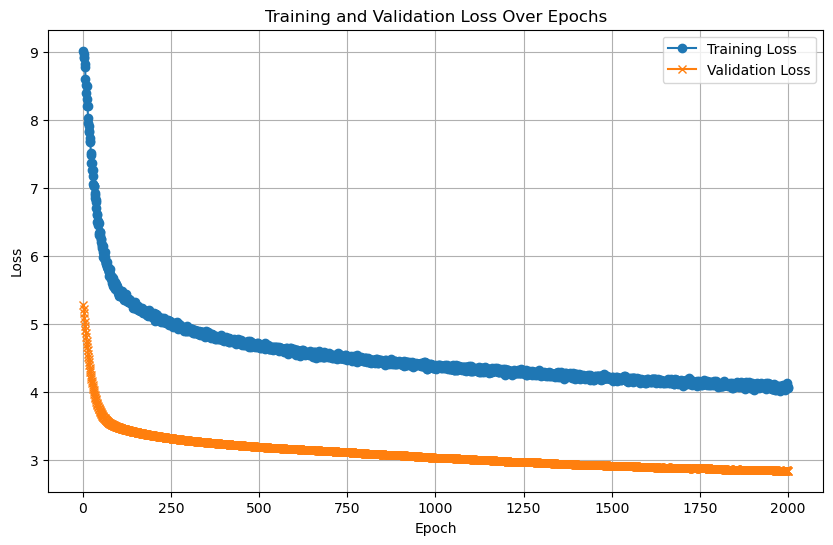

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/39], Loss: 5.0759
Test Batch [20/39], Loss: 5.5262
Test Batch [30/39], Loss: 4.6613

Test Loss: 5.1249


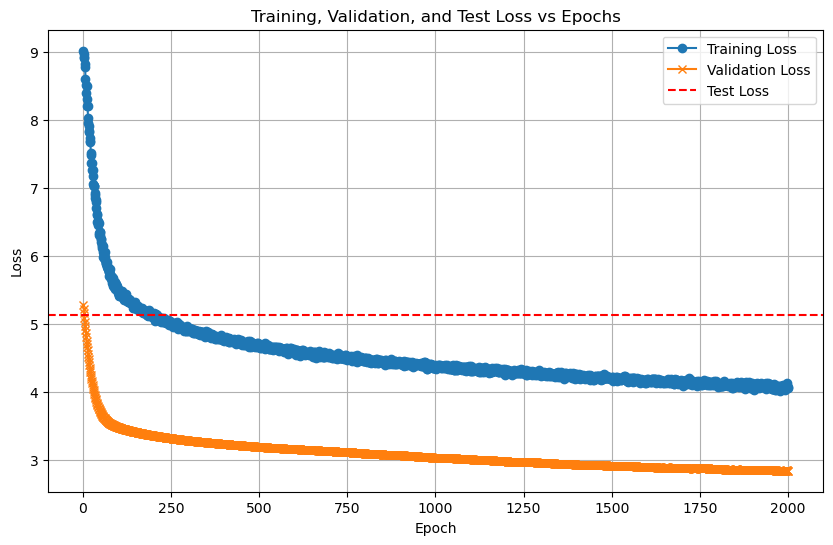

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 65.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.17      0.20      0.18         5
           2       0.40      0.40      0.40         5
           3       0.50      0.20      0.29         5
           4       0.67      0.40      0.50         5
           5       0.57      0.80      0.67         5
           6       0.83      1.00      0.91         5
           7       0.62      1.00      0.77         5
           8       0.00      0.00      0.00         0
           9       0.80      0.80      0.80         5
          10       0.33      0.20      0.25         5
          11       0.40      0.40      0.40         5
          12       1.00      1.00      1.00         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7766  |  Val Loss: 2.7449
Validation loss improved from inf to 2.7449.
[Epoch 2/1000] Train Loss: 2.7414  |  Val Loss: 2.7155
Validation loss improved from 2.7449 to 2.7155.
[Epoch 3/1000] Train Loss: 2.7123  |  Val Loss: 2.6889
Validation loss improved from 2.7155 to 2.6889.
[Epoch 4/1000] Train Loss: 2.6861  |  Val Loss: 2.6657
Validation loss improved from 2.6889 to 2.6657.
[Epoch 5/1000] Train Loss: 2.6630  |  Val Loss: 2.6435
Validation loss improved from 2.6657 to 2.6435.


[Epoch 6/1000] Train Loss: 2.6414  |  Val Loss: 2.6220
Validation loss improved from 2.6435 to 2.6220.
[Epoch 7/1000] Train Loss: 2.6200  |  Val Loss: 2.6018
Validation loss improved from 2.6220 to 2.6018.
[Epoch 8/1000] Train Loss: 2.5998  |  Val Loss: 2.5838
Validation loss improved from 2.6018 to 2.5838.
[Epoch 9/1000] Train Loss: 2.5811  |  Val Loss: 2.5660
Validation loss improved from 2.5838 to 2.5660.
[Epoch 10/1000] Train Loss: 2.5618  |  Val Loss: 2.5488
Validation loss improved from 2.5660 to 2.5488.
[Epoch 11/1000] Train Loss: 2.5443  |  Val Loss: 2.5313
Validation loss improved from 2.5488 to 2.5313.
[Epoch 12/1000] Train Loss: 2.5266  |  Val Loss: 2.5145
Validation loss improved from 2.5313 to 2.5145.
[Epoch 13/1000] Train Loss: 2.5075  |  Val Loss: 2.4983
Validation loss improved from 2.5145 to 2.4983.


[Epoch 14/1000] Train Loss: 2.4905  |  Val Loss: 2.4822
Validation loss improved from 2.4983 to 2.4822.
[Epoch 15/1000] Train Loss: 2.4733  |  Val Loss: 2.4662
Validation loss improved from 2.4822 to 2.4662.
[Epoch 16/1000] Train Loss: 2.4558  |  Val Loss: 2.4504
Validation loss improved from 2.4662 to 2.4504.
[Epoch 17/1000] Train Loss: 2.4389  |  Val Loss: 2.4346
Validation loss improved from 2.4504 to 2.4346.
[Epoch 18/1000] Train Loss: 2.4214  |  Val Loss: 2.4193
Validation loss improved from 2.4346 to 2.4193.
[Epoch 19/1000] Train Loss: 2.4048  |  Val Loss: 2.4041
Validation loss improved from 2.4193 to 2.4041.


[Epoch 20/1000] Train Loss: 2.3881  |  Val Loss: 2.3887
Validation loss improved from 2.4041 to 2.3887.
[Epoch 21/1000] Train Loss: 2.3713  |  Val Loss: 2.3732
Validation loss improved from 2.3887 to 2.3732.
[Epoch 22/1000] Train Loss: 2.3547  |  Val Loss: 2.3575
Validation loss improved from 2.3732 to 2.3575.
[Epoch 23/1000] Train Loss: 2.3383  |  Val Loss: 2.3420
Validation loss improved from 2.3575 to 2.3420.
[Epoch 24/1000] Train Loss: 2.3226  |  Val Loss: 2.3265
Validation loss improved from 2.3420 to 2.3265.
[Epoch 25/1000] Train Loss: 2.3063  |  Val Loss: 2.3119
Validation loss improved from 2.3265 to 2.3119.


[Epoch 26/1000] Train Loss: 2.2912  |  Val Loss: 2.2968
Validation loss improved from 2.3119 to 2.2968.
[Epoch 27/1000] Train Loss: 2.2757  |  Val Loss: 2.2816
Validation loss improved from 2.2968 to 2.2816.
[Epoch 28/1000] Train Loss: 2.2597  |  Val Loss: 2.2670
Validation loss improved from 2.2816 to 2.2670.
[Epoch 29/1000] Train Loss: 2.2448  |  Val Loss: 2.2521
Validation loss improved from 2.2670 to 2.2521.
[Epoch 30/1000] Train Loss: 2.2289  |  Val Loss: 2.2373
Validation loss improved from 2.2521 to 2.2373.
[Epoch 31/1000] Train Loss: 2.2140  |  Val Loss: 2.2220
Validation loss improved from 2.2373 to 2.2220.
[Epoch 32/1000] Train Loss: 2.1981  |  Val Loss: 2.2071
Validation loss improved from 2.2220 to 2.2071.
[Epoch 33/1000] Train Loss: 2.1831  |  Val Loss: 2.1912
Validation loss improved from 2.2071 to 2.1912.
[Epoch 34/1000] Train Loss: 2.1668  |  Val Loss: 2.1761
Validation loss improved from 2.1912 to 2.1761.


[Epoch 35/1000] Train Loss: 2.1509  |  Val Loss: 2.1613
Validation loss improved from 2.1761 to 2.1613.
[Epoch 36/1000] Train Loss: 2.1364  |  Val Loss: 2.1465
Validation loss improved from 2.1613 to 2.1465.
[Epoch 37/1000] Train Loss: 2.1203  |  Val Loss: 2.1326
Validation loss improved from 2.1465 to 2.1326.
[Epoch 38/1000] Train Loss: 2.1057  |  Val Loss: 2.1181
Validation loss improved from 2.1326 to 2.1181.
[Epoch 39/1000] Train Loss: 2.0913  |  Val Loss: 2.1034
Validation loss improved from 2.1181 to 2.1034.
[Epoch 40/1000] Train Loss: 2.0757  |  Val Loss: 2.0895
Validation loss improved from 2.1034 to 2.0895.


[Epoch 41/1000] Train Loss: 2.0614  |  Val Loss: 2.0752
Validation loss improved from 2.0895 to 2.0752.
[Epoch 42/1000] Train Loss: 2.0467  |  Val Loss: 2.0613
Validation loss improved from 2.0752 to 2.0613.
[Epoch 43/1000] Train Loss: 2.0326  |  Val Loss: 2.0473
Validation loss improved from 2.0613 to 2.0473.
[Epoch 44/1000] Train Loss: 2.0184  |  Val Loss: 2.0342
Validation loss improved from 2.0473 to 2.0342.


[Epoch 45/1000] Train Loss: 2.0045  |  Val Loss: 2.0213
Validation loss improved from 2.0342 to 2.0213.
[Epoch 46/1000] Train Loss: 1.9910  |  Val Loss: 2.0080
Validation loss improved from 2.0213 to 2.0080.
[Epoch 47/1000] Train Loss: 1.9781  |  Val Loss: 1.9956
Validation loss improved from 2.0080 to 1.9956.
[Epoch 48/1000] Train Loss: 1.9647  |  Val Loss: 1.9839
Validation loss improved from 1.9956 to 1.9839.
[Epoch 49/1000] Train Loss: 1.9519  |  Val Loss: 1.9723
Validation loss improved from 1.9839 to 1.9723.
[Epoch 50/1000] Train Loss: 1.9396  |  Val Loss: 1.9600
Validation loss improved from 1.9723 to 1.9600.
[Epoch 51/1000] Train Loss: 1.9270  |  Val Loss: 1.9481
Validation loss improved from 1.9600 to 1.9481.
[Epoch 52/1000] Train Loss: 1.9147  |  Val Loss: 1.9364
Validation loss improved from 1.9481 to 1.9364.
[Epoch 53/1000] Train Loss: 1.9024  |  Val Loss: 1.9250
Validation loss improved from 1.9364 to 1.9250.
[Epoch 54/1000] Train Loss: 1.8905  |  Val Loss: 1.9133
Validati

[Epoch 56/1000] Train Loss: 1.8665  |  Val Loss: 1.8915
Validation loss improved from 1.9027 to 1.8915.
[Epoch 57/1000] Train Loss: 1.8553  |  Val Loss: 1.8803
Validation loss improved from 1.8915 to 1.8803.
[Epoch 58/1000] Train Loss: 1.8431  |  Val Loss: 1.8694
Validation loss improved from 1.8803 to 1.8694.
[Epoch 59/1000] Train Loss: 1.8316  |  Val Loss: 1.8586
Validation loss improved from 1.8694 to 1.8586.
[Epoch 60/1000] Train Loss: 1.8201  |  Val Loss: 1.8478
Validation loss improved from 1.8586 to 1.8478.
[Epoch 61/1000] Train Loss: 1.8084  |  Val Loss: 1.8374
Validation loss improved from 1.8478 to 1.8374.
[Epoch 62/1000] Train Loss: 1.7974  |  Val Loss: 1.8268
Validation loss improved from 1.8374 to 1.8268.


[Epoch 63/1000] Train Loss: 1.7857  |  Val Loss: 1.8165
Validation loss improved from 1.8268 to 1.8165.


[Epoch 64/1000] Train Loss: 1.7751  |  Val Loss: 1.8064
Validation loss improved from 1.8165 to 1.8064.
[Epoch 65/1000] Train Loss: 1.7634  |  Val Loss: 1.7959
Validation loss improved from 1.8064 to 1.7959.
[Epoch 66/1000] Train Loss: 1.7521  |  Val Loss: 1.7852
Validation loss improved from 1.7959 to 1.7852.
[Epoch 67/1000] Train Loss: 1.7407  |  Val Loss: 1.7753
Validation loss improved from 1.7852 to 1.7753.
[Epoch 68/1000] Train Loss: 1.7294  |  Val Loss: 1.7654
Validation loss improved from 1.7753 to 1.7654.
[Epoch 69/1000] Train Loss: 1.7184  |  Val Loss: 1.7558
Validation loss improved from 1.7654 to 1.7558.
[Epoch 70/1000] Train Loss: 1.7077  |  Val Loss: 1.7452
Validation loss improved from 1.7558 to 1.7452.
[Epoch 71/1000] Train Loss: 1.6960  |  Val Loss: 1.7350
Validation loss improved from 1.7452 to 1.7350.
[Epoch 72/1000] Train Loss: 1.6844  |  Val Loss: 1.7251
Validation loss improved from 1.7350 to 1.7251.


[Epoch 73/1000] Train Loss: 1.6725  |  Val Loss: 1.7142
Validation loss improved from 1.7251 to 1.7142.
[Epoch 74/1000] Train Loss: 1.6611  |  Val Loss: 1.7033
Validation loss improved from 1.7142 to 1.7033.
[Epoch 75/1000] Train Loss: 1.6492  |  Val Loss: 1.6926
Validation loss improved from 1.7033 to 1.6926.
[Epoch 76/1000] Train Loss: 1.6365  |  Val Loss: 1.6819
Validation loss improved from 1.6926 to 1.6819.
[Epoch 77/1000] Train Loss: 1.6250  |  Val Loss: 1.6715
Validation loss improved from 1.6819 to 1.6715.
[Epoch 78/1000] Train Loss: 1.6144  |  Val Loss: 1.6609
Validation loss improved from 1.6715 to 1.6609.
[Epoch 79/1000] Train Loss: 1.6021  |  Val Loss: 1.6511
Validation loss improved from 1.6609 to 1.6511.


[Epoch 80/1000] Train Loss: 1.5908  |  Val Loss: 1.6412
Validation loss improved from 1.6511 to 1.6412.
[Epoch 81/1000] Train Loss: 1.5799  |  Val Loss: 1.6308
Validation loss improved from 1.6412 to 1.6308.
[Epoch 82/1000] Train Loss: 1.5685  |  Val Loss: 1.6210
Validation loss improved from 1.6308 to 1.6210.
[Epoch 83/1000] Train Loss: 1.5573  |  Val Loss: 1.6117
Validation loss improved from 1.6210 to 1.6117.
[Epoch 84/1000] Train Loss: 1.5464  |  Val Loss: 1.6027
Validation loss improved from 1.6117 to 1.6027.
[Epoch 85/1000] Train Loss: 1.5361  |  Val Loss: 1.5930
Validation loss improved from 1.6027 to 1.5930.
[Epoch 86/1000] Train Loss: 1.5249  |  Val Loss: 1.5830
Validation loss improved from 1.5930 to 1.5830.
[Epoch 87/1000] Train Loss: 1.5142  |  Val Loss: 1.5737
Validation loss improved from 1.5830 to 1.5737.
[Epoch 88/1000] Train Loss: 1.5032  |  Val Loss: 1.5651
Validation loss improved from 1.5737 to 1.5651.
[Epoch 89/1000] Train Loss: 1.4919  |  Val Loss: 1.5557
Validati

[Epoch 93/1000] Train Loss: 1.4479  |  Val Loss: 1.5177
Validation loss improved from 1.5266 to 1.5177.
[Epoch 94/1000] Train Loss: 1.4374  |  Val Loss: 1.5084
Validation loss improved from 1.5177 to 1.5084.
[Epoch 95/1000] Train Loss: 1.4252  |  Val Loss: 1.4991
Validation loss improved from 1.5084 to 1.4991.
[Epoch 96/1000] Train Loss: 1.4144  |  Val Loss: 1.4903
Validation loss improved from 1.4991 to 1.4903.
[Epoch 97/1000] Train Loss: 1.4041  |  Val Loss: 1.4802
Validation loss improved from 1.4903 to 1.4802.
[Epoch 98/1000] Train Loss: 1.3938  |  Val Loss: 1.4712
Validation loss improved from 1.4802 to 1.4712.


[Epoch 99/1000] Train Loss: 1.3833  |  Val Loss: 1.4622
Validation loss improved from 1.4712 to 1.4622.
[Epoch 100/1000] Train Loss: 1.3729  |  Val Loss: 1.4535
Validation loss improved from 1.4622 to 1.4535.
[Epoch 101/1000] Train Loss: 1.3631  |  Val Loss: 1.4458
Validation loss improved from 1.4535 to 1.4458.
[Epoch 102/1000] Train Loss: 1.3534  |  Val Loss: 1.4377
Validation loss improved from 1.4458 to 1.4377.
[Epoch 103/1000] Train Loss: 1.3427  |  Val Loss: 1.4288
Validation loss improved from 1.4377 to 1.4288.
[Epoch 104/1000] Train Loss: 1.3328  |  Val Loss: 1.4205
Validation loss improved from 1.4288 to 1.4205.
[Epoch 105/1000] Train Loss: 1.3240  |  Val Loss: 1.4129
Validation loss improved from 1.4205 to 1.4129.
[Epoch 106/1000] Train Loss: 1.3134  |  Val Loss: 1.4051
Validation loss improved from 1.4129 to 1.4051.
[Epoch 107/1000] Train Loss: 1.3032  |  Val Loss: 1.3973
Validation loss improved from 1.4051 to 1.3973.
[Epoch 108/1000] Train Loss: 1.2947  |  Val Loss: 1.3886

[Epoch 112/1000] Train Loss: 1.2560  |  Val Loss: 1.3610
Validation loss improved from 1.3686 to 1.3610.
[Epoch 113/1000] Train Loss: 1.2466  |  Val Loss: 1.3527
Validation loss improved from 1.3610 to 1.3527.
[Epoch 114/1000] Train Loss: 1.2374  |  Val Loss: 1.3443
Validation loss improved from 1.3527 to 1.3443.
[Epoch 115/1000] Train Loss: 1.2278  |  Val Loss: 1.3377
Validation loss improved from 1.3443 to 1.3377.
[Epoch 116/1000] Train Loss: 1.2185  |  Val Loss: 1.3314
Validation loss improved from 1.3377 to 1.3314.


[Epoch 117/1000] Train Loss: 1.2096  |  Val Loss: 1.3246
Validation loss improved from 1.3314 to 1.3246.
[Epoch 118/1000] Train Loss: 1.2001  |  Val Loss: 1.3175
Validation loss improved from 1.3246 to 1.3175.
[Epoch 119/1000] Train Loss: 1.1916  |  Val Loss: 1.3104
Validation loss improved from 1.3175 to 1.3104.
[Epoch 120/1000] Train Loss: 1.1816  |  Val Loss: 1.3040
Validation loss improved from 1.3104 to 1.3040.
[Epoch 121/1000] Train Loss: 1.1732  |  Val Loss: 1.2975
Validation loss improved from 1.3040 to 1.2975.
[Epoch 122/1000] Train Loss: 1.1644  |  Val Loss: 1.2910
Validation loss improved from 1.2975 to 1.2910.
[Epoch 123/1000] Train Loss: 1.1559  |  Val Loss: 1.2840
Validation loss improved from 1.2910 to 1.2840.
[Epoch 124/1000] Train Loss: 1.1477  |  Val Loss: 1.2781
Validation loss improved from 1.2840 to 1.2781.
[Epoch 125/1000] Train Loss: 1.1379  |  Val Loss: 1.2719
Validation loss improved from 1.2781 to 1.2719.
[Epoch 126/1000] Train Loss: 1.1298  |  Val Loss: 1.265

[Epoch 131/1000] Train Loss: 1.0888  |  Val Loss: 1.2366
Validation loss improved from 1.2419 to 1.2366.
[Epoch 132/1000] Train Loss: 1.0809  |  Val Loss: 1.2309
Validation loss improved from 1.2366 to 1.2309.
[Epoch 133/1000] Train Loss: 1.0727  |  Val Loss: 1.2252
Validation loss improved from 1.2309 to 1.2252.
[Epoch 134/1000] Train Loss: 1.0652  |  Val Loss: 1.2192
Validation loss improved from 1.2252 to 1.2192.
[Epoch 135/1000] Train Loss: 1.0575  |  Val Loss: 1.2144
Validation loss improved from 1.2192 to 1.2144.


[Epoch 136/1000] Train Loss: 1.0502  |  Val Loss: 1.2092
Validation loss improved from 1.2144 to 1.2092.
[Epoch 137/1000] Train Loss: 1.0420  |  Val Loss: 1.2036
Validation loss improved from 1.2092 to 1.2036.
[Epoch 138/1000] Train Loss: 1.0357  |  Val Loss: 1.2000
Validation loss improved from 1.2036 to 1.2000.
[Epoch 139/1000] Train Loss: 1.0280  |  Val Loss: 1.1939
Validation loss improved from 1.2000 to 1.1939.
[Epoch 140/1000] Train Loss: 1.0200  |  Val Loss: 1.1887
Validation loss improved from 1.1939 to 1.1887.
[Epoch 141/1000] Train Loss: 1.0128  |  Val Loss: 1.1830
Validation loss improved from 1.1887 to 1.1830.
[Epoch 142/1000] Train Loss: 1.0059  |  Val Loss: 1.1798
Validation loss improved from 1.1830 to 1.1798.
[Epoch 143/1000] Train Loss: 0.9980  |  Val Loss: 1.1749
Validation loss improved from 1.1798 to 1.1749.
[Epoch 144/1000] Train Loss: 0.9911  |  Val Loss: 1.1701
Validation loss improved from 1.1749 to 1.1701.
[Epoch 145/1000] Train Loss: 0.9839  |  Val Loss: 1.165

[Epoch 149/1000] Train Loss: 0.9578  |  Val Loss: 1.1489
Validation loss improved from 1.1532 to 1.1489.
[Epoch 150/1000] Train Loss: 0.9501  |  Val Loss: 1.1441
Validation loss improved from 1.1489 to 1.1441.
[Epoch 151/1000] Train Loss: 0.9437  |  Val Loss: 1.1393
Validation loss improved from 1.1441 to 1.1393.
[Epoch 152/1000] Train Loss: 0.9373  |  Val Loss: 1.1344
Validation loss improved from 1.1393 to 1.1344.


[Epoch 153/1000] Train Loss: 0.9302  |  Val Loss: 1.1310
Validation loss improved from 1.1344 to 1.1310.
[Epoch 154/1000] Train Loss: 0.9244  |  Val Loss: 1.1269
Validation loss improved from 1.1310 to 1.1269.
[Epoch 155/1000] Train Loss: 0.9184  |  Val Loss: 1.1247
Validation loss improved from 1.1269 to 1.1247.
[Epoch 156/1000] Train Loss: 0.9116  |  Val Loss: 1.1205
Validation loss improved from 1.1247 to 1.1205.
[Epoch 157/1000] Train Loss: 0.9056  |  Val Loss: 1.1165
Validation loss improved from 1.1205 to 1.1165.
[Epoch 158/1000] Train Loss: 0.8996  |  Val Loss: 1.1122
Validation loss improved from 1.1165 to 1.1122.
[Epoch 159/1000] Train Loss: 0.8930  |  Val Loss: 1.1092
Validation loss improved from 1.1122 to 1.1092.
[Epoch 160/1000] Train Loss: 0.8877  |  Val Loss: 1.1071
Validation loss improved from 1.1092 to 1.1071.
[Epoch 161/1000] Train Loss: 0.8814  |  Val Loss: 1.1031
Validation loss improved from 1.1071 to 1.1031.
[Epoch 162/1000] Train Loss: 0.8752  |  Val Loss: 1.099

[Epoch 167/1000] Train Loss: 0.8474  |  Val Loss: 1.0825
Validation loss improved from 1.0861 to 1.0825.
[Epoch 168/1000] Train Loss: 0.8422  |  Val Loss: 1.0784
Validation loss improved from 1.0825 to 1.0784.
[Epoch 169/1000] Train Loss: 0.8372  |  Val Loss: 1.0754
Validation loss improved from 1.0784 to 1.0754.
[Epoch 170/1000] Train Loss: 0.8317  |  Val Loss: 1.0717
Validation loss improved from 1.0754 to 1.0717.


[Epoch 171/1000] Train Loss: 0.8268  |  Val Loss: 1.0686
Validation loss improved from 1.0717 to 1.0686.
[Epoch 172/1000] Train Loss: 0.8212  |  Val Loss: 1.0657
Validation loss improved from 1.0686 to 1.0657.
[Epoch 173/1000] Train Loss: 0.8179  |  Val Loss: 1.0634
Validation loss improved from 1.0657 to 1.0634.
[Epoch 174/1000] Train Loss: 0.8116  |  Val Loss: 1.0601
Validation loss improved from 1.0634 to 1.0601.
[Epoch 175/1000] Train Loss: 0.8068  |  Val Loss: 1.0582
Validation loss improved from 1.0601 to 1.0582.
[Epoch 176/1000] Train Loss: 0.8020  |  Val Loss: 1.0548
Validation loss improved from 1.0582 to 1.0548.
[Epoch 177/1000] Train Loss: 0.7975  |  Val Loss: 1.0533
Validation loss improved from 1.0548 to 1.0533.
[Epoch 178/1000] Train Loss: 0.7923  |  Val Loss: 1.0495
Validation loss improved from 1.0533 to 1.0495.
[Epoch 179/1000] Train Loss: 0.7886  |  Val Loss: 1.0464
Validation loss improved from 1.0495 to 1.0464.
[Epoch 180/1000] Train Loss: 0.7842  |  Val Loss: 1.043

[Epoch 188/1000] Train Loss: 0.7499  |  Val Loss: 1.0221
Validation loss improved from 1.0254 to 1.0221.
[Epoch 189/1000] Train Loss: 0.7473  |  Val Loss: 1.0203
Validation loss improved from 1.0221 to 1.0203.
[Epoch 190/1000] Train Loss: 0.7423  |  Val Loss: 1.0185
Validation loss improved from 1.0203 to 1.0185.
[Epoch 191/1000] Train Loss: 0.7396  |  Val Loss: 1.0172
Validation loss improved from 1.0185 to 1.0172.
[Epoch 192/1000] Train Loss: 0.7348  |  Val Loss: 1.0143
Validation loss improved from 1.0172 to 1.0143.
[Epoch 193/1000] Train Loss: 0.7321  |  Val Loss: 1.0123
Validation loss improved from 1.0143 to 1.0123.
[Epoch 194/1000] Train Loss: 0.7284  |  Val Loss: 1.0098
Validation loss improved from 1.0123 to 1.0098.
[Epoch 195/1000] Train Loss: 0.7255  |  Val Loss: 1.0059
Validation loss improved from 1.0098 to 1.0059.
[Epoch 196/1000] Train Loss: 0.7221  |  Val Loss: 1.0054
Validation loss improved from 1.0059 to 1.0054.
[Epoch 197/1000] Train Loss: 0.7173  |  Val Loss: 1.003

[Epoch 208/1000] Train Loss: 0.6837  |  Val Loss: 0.9830
Validation loss improved from 0.9852 to 0.9830.
[Epoch 209/1000] Train Loss: 0.6799  |  Val Loss: 0.9820
Validation loss improved from 0.9830 to 0.9820.
[Epoch 210/1000] Train Loss: 0.6779  |  Val Loss: 0.9811
Validation loss improved from 0.9820 to 0.9811.
[Epoch 211/1000] Train Loss: 0.6746  |  Val Loss: 0.9799
Validation loss improved from 0.9811 to 0.9799.
[Epoch 212/1000] Train Loss: 0.6720  |  Val Loss: 0.9777
Validation loss improved from 0.9799 to 0.9777.
[Epoch 213/1000] Train Loss: 0.6688  |  Val Loss: 0.9754
Validation loss improved from 0.9777 to 0.9754.
[Epoch 214/1000] Train Loss: 0.6679  |  Val Loss: 0.9727
Validation loss improved from 0.9754 to 0.9727.
[Epoch 215/1000] Train Loss: 0.6642  |  Val Loss: 0.9729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.6618  |  Val Loss: 0.9707
Validation loss improved from 0.9727 to 0.9707.
[Epoch 217/1000] Train Loss: 0.6588  |  Val Loss:

[Epoch 228/1000] Train Loss: 0.6316  |  Val Loss: 0.9550
Validation loss improved from 0.9559 to 0.9550.
[Epoch 229/1000] Train Loss: 0.6302  |  Val Loss: 0.9526
Validation loss improved from 0.9550 to 0.9526.
[Epoch 230/1000] Train Loss: 0.6277  |  Val Loss: 0.9516
Validation loss improved from 0.9526 to 0.9516.
[Epoch 231/1000] Train Loss: 0.6252  |  Val Loss: 0.9514
Validation loss improved from 0.9516 to 0.9514.
[Epoch 232/1000] Train Loss: 0.6230  |  Val Loss: 0.9502
Validation loss improved from 0.9514 to 0.9502.
[Epoch 233/1000] Train Loss: 0.6208  |  Val Loss: 0.9482
Validation loss improved from 0.9502 to 0.9482.
[Epoch 234/1000] Train Loss: 0.6194  |  Val Loss: 0.9460
Validation loss improved from 0.9482 to 0.9460.
[Epoch 235/1000] Train Loss: 0.6175  |  Val Loss: 0.9463
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 0.6156  |  Val Loss: 0.9447
Validation loss improved from 0.9460 to 0.9447.
[Epoch 237/1000] Train Loss: 0.6135  |  Val Loss:

[Epoch 245/1000] Train Loss: 0.5971  |  Val Loss: 0.9361
Validation loss improved from 0.9366 to 0.9361.
[Epoch 246/1000] Train Loss: 0.5953  |  Val Loss: 0.9346
Validation loss improved from 0.9361 to 0.9346.
[Epoch 247/1000] Train Loss: 0.5934  |  Val Loss: 0.9342
Validation loss improved from 0.9346 to 0.9342.
[Epoch 248/1000] Train Loss: 0.5920  |  Val Loss: 0.9336
Validation loss improved from 0.9342 to 0.9336.
[Epoch 249/1000] Train Loss: 0.5901  |  Val Loss: 0.9321
Validation loss improved from 0.9336 to 0.9321.
[Epoch 250/1000] Train Loss: 0.5889  |  Val Loss: 0.9320
Validation loss improved from 0.9321 to 0.9320.
[Epoch 251/1000] Train Loss: 0.5867  |  Val Loss: 0.9310
Validation loss improved from 0.9320 to 0.9310.
[Epoch 252/1000] Train Loss: 0.5864  |  Val Loss: 0.9301
Validation loss improved from 0.9310 to 0.9301.
[Epoch 253/1000] Train Loss: 0.5835  |  Val Loss: 0.9286
Validation loss improved from 0.9301 to 0.9286.
[Epoch 254/1000] Train Loss: 0.5827  |  Val Loss: 0.926

[Epoch 262/1000] Train Loss: 0.5690  |  Val Loss: 0.9216
Validation loss improved from 0.9216 to 0.9216.
[Epoch 263/1000] Train Loss: 0.5681  |  Val Loss: 0.9203
Validation loss improved from 0.9216 to 0.9203.
[Epoch 264/1000] Train Loss: 0.5670  |  Val Loss: 0.9191
Validation loss improved from 0.9203 to 0.9191.
[Epoch 265/1000] Train Loss: 0.5647  |  Val Loss: 0.9204
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.5625  |  Val Loss: 0.9187
Validation loss improved from 0.9191 to 0.9187.
[Epoch 267/1000] Train Loss: 0.5628  |  Val Loss: 0.9187
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Loss: 0.5604  |  Val Loss: 0.9179
Validation loss improved from 0.9187 to 0.9179.
[Epoch 269/1000] Train Loss: 0.5587  |  Val Loss: 0.9176
Validation loss improved from 0.9179 to 0.9176.
[Epoch 270/1000] Train Loss: 0.5574  |  Val Loss: 0.9158
Validation loss improved from 0.9176 to 0.9158.
[Epoch 271/1000] Train Loss: 0.5557  |  Val

[Epoch 282/1000] Train Loss: 0.5416  |  Val Loss: 0.9078
Validation loss improved from 0.9096 to 0.9078.
[Epoch 283/1000] Train Loss: 0.5402  |  Val Loss: 0.9090
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 0.5388  |  Val Loss: 0.9089
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 285/1000] Train Loss: 0.5379  |  Val Loss: 0.9072
Validation loss improved from 0.9078 to 0.9072.
[Epoch 286/1000] Train Loss: 0.5363  |  Val Loss: 0.9069
Validation loss improved from 0.9072 to 0.9069.
[Epoch 287/1000] Train Loss: 0.5343  |  Val Loss: 0.9067
Validation loss improved from 0.9069 to 0.9067.
[Epoch 288/1000] Train Loss: 0.5333  |  Val Loss: 0.9055
Validation loss improved from 0.9067 to 0.9055.
[Epoch 289/1000] Train Loss: 0.5330  |  Val Loss: 0.9048
Validation loss improved from 0.9055 to 0.9048.
[Epoch 290/1000] Train Loss: 0.5313  |  Val Loss: 0.9046
Validation loss improved from 0.9048 to 0.9046.
[Epoch 291/1000] Train Loss: 0.5296  |  Val

[Epoch 301/1000] Train Loss: 0.5190  |  Val Loss: 0.9006
Validation loss improved from 0.9015 to 0.9006.
[Epoch 302/1000] Train Loss: 0.5181  |  Val Loss: 0.8987
Validation loss improved from 0.9006 to 0.8987.
[Epoch 303/1000] Train Loss: 0.5170  |  Val Loss: 0.8980
Validation loss improved from 0.8987 to 0.8980.
[Epoch 304/1000] Train Loss: 0.5170  |  Val Loss: 0.8995
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 305/1000] Train Loss: 0.5145  |  Val Loss: 0.8987
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 306/1000] Train Loss: 0.5138  |  Val Loss: 0.8986
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 307/1000] Train Loss: 0.5124  |  Val Loss: 0.8974
Validation loss improved from 0.8980 to 0.8974.
[Epoch 308/1000] Train Loss: 0.5114  |  Val Loss: 0.8970
Validation loss improved from 0.8974 to 0.8970.
[Epoch 309/1000] Train Loss: 0.5102  |  Val Loss: 0.8964
Validation loss improved from 0.8970 to 0.8964.
[Epoch 310/1000] Train Loss: 0.5106  

[Epoch 322/1000] Train Loss: 0.4987  |  Val Loss: 0.8922
Validation loss improved from 0.8932 to 0.8922.
[Epoch 323/1000] Train Loss: 0.4978  |  Val Loss: 0.8934
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 0.4966  |  Val Loss: 0.8938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/1000] Train Loss: 0.4973  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 326/1000] Train Loss: 0.4952  |  Val Loss: 0.8937
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 327/1000] Train Loss: 0.4944  |  Val Loss: 0.8916
Validation loss improved from 0.8922 to 0.8916.
[Epoch 328/1000] Train Loss: 0.4943  |  Val Loss: 0.8923
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 329/1000] Train Loss: 0.4929  |  Val Loss: 0.8914
Validation loss improved from 0.8916 to 0.8914.
[Epoch 330/1000] Train Loss: 0.4921  |  Val Loss: 0.8933
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 331/1000] Tr

[Epoch 339/1000] Train Loss: 0.4855  |  Val Loss: 0.8903
Validation loss improved from 0.8914 to 0.8903.
[Epoch 340/1000] Train Loss: 0.4841  |  Val Loss: 0.8915
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 341/1000] Train Loss: 0.4829  |  Val Loss: 0.8918
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 342/1000] Train Loss: 0.4824  |  Val Loss: 0.8934
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 343/1000] Train Loss: 0.4818  |  Val Loss: 0.8925
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 344/1000] Train Loss: 0.4807  |  Val Loss: 0.8913
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 345/1000] Train Loss: 0.4803  |  Val Loss: 0.8926
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 346/1000] Train Loss: 0.4798  |  Val Loss: 0.8922
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 347/1000] Train Loss: 0.4785  |  Val Loss: 0.8917
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 357/1000] Train Loss: 0.4717  |  Val Loss: 0.8921
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 358/1000] Train Loss: 0.4711  |  Val Loss: 0.8932
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 359/1000] Train Loss: 0.4711  |  Val Loss: 0.8923
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 360/1000] Train Loss: 0.4699  |  Val Loss: 0.8926
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 361/1000] Train Loss: 0.4689  |  Val Loss: 0.8935
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 362/1000] Train Loss: 0.4691  |  Val Loss: 0.8917
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 363/1000] Train Loss: 0.4678  |  Val Loss: 0.8922
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 364/1000] Train Loss: 0.4680  |  Val Loss: 0.8926
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 365/1000] Train Loss: 0.4667  |  Val Loss: 0.8937
!! Validation loss did NOT improve !! Patience:

[Epoch 376/1000] Train Loss: 0.4610  |  Val Loss: 0.8968
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 377/1000] Train Loss: 0.4595  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 378/1000] Train Loss: 0.4591  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 379/1000] Train Loss: 0.4578  |  Val Loss: 0.8954
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 380/1000] Train Loss: 0.4584  |  Val Loss: 0.8937
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 381/1000] Train Loss: 0.4575  |  Val Loss: 0.8951
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 382/1000] Train Loss: 0.4569  |  Val Loss: 0.8956
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 383/1000] Train Loss: 0.4558  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 384/1000] Train Loss: 0.4563  |  Val Loss: 0.8958
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.4491  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 397/1000] Train Loss: 0.4491  |  Val Loss: 0.8965
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 398/1000] Train Loss: 0.4489  |  Val Loss: 0.8965
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 399/1000] Train Loss: 0.4473  |  Val Loss: 0.8966
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 400/1000] Train Loss: 0.4483  |  Val Loss: 0.8975
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 401/1000] Train Loss: 0.4468  |  Val Loss: 0.8970
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 402/1000] Train Loss: 0.4460  |  Val Loss: 0.8971
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 403/1000] Train Loss: 0.4466  |  Val Loss: 0.8983
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 404/1000] Train Loss: 0.4455  |  Val Loss: 0.8981
!! Validation loss did NOT improve !! Patience:

[Epoch 415/1000] Train Loss: 0.4397  |  Val Loss: 0.9001
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 416/1000] Train Loss: 0.4401  |  Val Loss: 0.9001
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 417/1000] Train Loss: 0.4387  |  Val Loss: 0.9007
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 418/1000] Train Loss: 0.4377  |  Val Loss: 0.8997
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 419/1000] Train Loss: 0.4386  |  Val Loss: 0.8988
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 420/1000] Train Loss: 0.4381  |  Val Loss: 0.9002
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 421/1000] Train Loss: 0.4382  |  Val Loss: 0.9005
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 422/1000] Train Loss: 0.4370  |  Val Loss: 0.9002
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 423/1000] Train Loss: 0.4362  |  Val Loss: 0.9010
!! Validation loss did NOT improve !! Patience:

[Epoch 433/1000] Train Loss: 0.4316  |  Val Loss: 0.9013
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 434/1000] Train Loss: 0.4321  |  Val Loss: 0.9016
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 435/1000] Train Loss: 0.4314  |  Val Loss: 0.9019
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 436/1000] Train Loss: 0.4314  |  Val Loss: 0.9022
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 437/1000] Train Loss: 0.4303  |  Val Loss: 0.9035
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 438/1000] Train Loss: 0.4307  |  Val Loss: 0.9037
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 439/1000] Train Loss: 0.4292  |  Val Loss: 0.9030
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 439 !!
No improvement for 100 epochs.


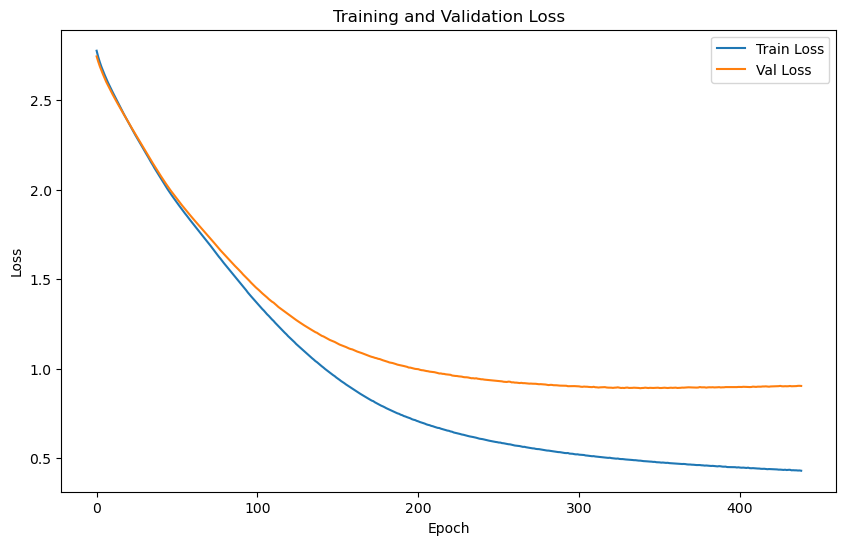

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.5922 | Test Accuracy: 54.65%


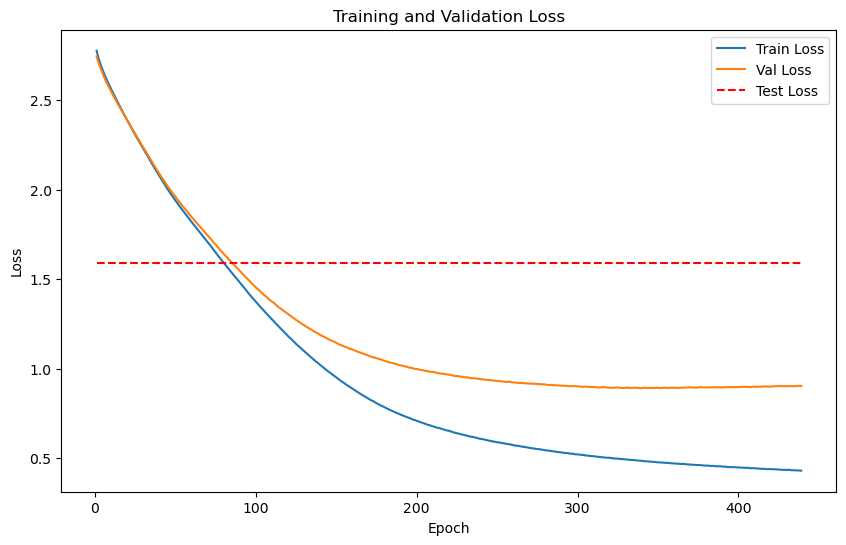

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.3318
Epoch [1/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.4284

Validation loss improved from inf to 0.4284. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.3271
Epoch [2/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.4262

Validation loss improved from 0.4284 to 0.4262. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.3223
Epoch [3/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.4238

Validation loss improved from 0.4262 to 0.4238. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.3178
Epoch [4/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.4214

Validation loss improved from 0.4238 to 0.4214. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.3134
Epoch [5/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4190

Validation loss improved from 0.4214 to 0.4190. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.3092
Epoch [6/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.4164

Validation loss improved from 0.4190 to 0.4164. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5227
    Batch [2/2], Val Loss: 0.3053
Epoch [7/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4140

Validation loss improved from 0.4164 to 0.4140. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.3021
Epoch [8/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4119

Validation loss improved from 0.4140 to 0.4119. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.3001
Epoch [9/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.4102

Validation loss improved from 0.4119 to 0.4102. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.2986
Epoch [10/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.4086

Validation loss improved from 0.4102 to 0.4086. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.2988
Epoch [11/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4078

Validation loss improved from 0.4086 to 0.4078. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.2994
Epoch [12/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4071

Validation loss improved from 0.4078 to 0.4071. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.3003
Epoch [13/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.4066

Validation loss improved from 0.4071 to 0.4066. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.3014
Epoch [14/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4063

Validation loss improved from 0.4066 to 0.4063. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.3028
Epoch [15/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4060

Validation loss improved from 0.4063 to 0.4060. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.3041
Epoch [16/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4055

Validation loss improved from 0.4060 to 0.4055. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.3053
Epoch [17/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4050

Validation loss improved from 0.4055 to 0.4050. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.3068
Epoch [18/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.4046

Validation loss improved from 0.4050 to 0.4046. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.3084
Epoch [19/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4043

Validation loss improved from 0.4046 to 0.4043. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.3099
Epoch [20/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4040

Validation loss improved from 0.4043 to 0.4040. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.3114
Epoch [21/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4039

Validation loss improved from 0.4040 to 0.4039. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.3128
Epoch [22/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4037

Validation loss improved from 0.4039 to 0.4037. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.3143
Epoch [23/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4036

Validation loss improved from 0.4037 to 0.4036. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.3157
Epoch [24/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4035

Validation loss improved from 0.4036 to 0.4035. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.3170
Epoch [25/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4034

Validation loss improved from 0.4035 to 0.4034. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4886
    Batch [2/2], Val Loss: 0.3182
Epoch [26/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4034

Validation loss improved from 0.4034 to 0.4034. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.3193
Epoch [27/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4033

Validation loss improved from 0.4034 to 0.4033. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.3202
Epoch [28/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4032

Validation loss improved from 0.4033 to 0.4032. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.3211
Epoch [29/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4032

Validation loss improved from 0.4032 to 0.4032. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.3219
Epoch [30/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3227
Epoch [31/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4032

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.3234
Epoch [32/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4032

Validation loss improved from 0.4032 to 0.4032. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.3240
Epoch [33/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4031

Validation loss improved from 0.4032 to 0.4031. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.3245
Epoch [34/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4031

Validation loss improved from 0.4031 to 0.4031. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.3250
Epoch [35/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4031

Validation loss improved from 0.4031 to 0.4031. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3254
Epoch [36/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4031

Validation loss improved from 0.4031 to 0.4031. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3257
Epoch [37/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4030

Validation loss improved from 0.4031 to 0.4030. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.3260
Epoch [38/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4029

Validation loss improved from 0.4030 to 0.4029. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3262
Epoch [39/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4029

Validation loss improved from 0.4029 to 0.4029. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.3265
Epoch [40/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4028

Validation loss improved from 0.4029 to 0.4028. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.3266
Epoch [41/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4027

Validation loss improved from 0.4028 to 0.4027. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3266
Epoch [42/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4026

Validation loss improved from 0.4027 to 0.4026. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.3266
Epoch [43/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4024

Validation loss improved from 0.4026 to 0.4024. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.3266
Epoch [44/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4023

Validation loss improved from 0.4024 to 0.4023. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.3265
Epoch [45/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4021

Validation loss improved from 0.4023 to 0.4021. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.3265
Epoch [46/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4019

Validation loss improved from 0.4021 to 0.4019. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.3265
Epoch [47/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4018

Validation loss improved from 0.4019 to 0.4018. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.3265
Epoch [48/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4016

Validation loss improved from 0.4018 to 0.4016. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.3263
Epoch [49/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.4014

Validation loss improved from 0.4016 to 0.4014. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.3262
Epoch [50/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4012

Validation loss improved from 0.4014 to 0.4012. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.3260
Epoch [51/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4010

Validation loss improved from 0.4012 to 0.4010. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.3257
Epoch [52/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4008

Validation loss improved from 0.4010 to 0.4008. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.3255
Epoch [53/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.4006

Validation loss improved from 0.4008 to 0.4006. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.3253
Epoch [54/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.4003

Validation loss improved from 0.4006 to 0.4003. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.3251
Epoch [55/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4001

Validation loss improved from 0.4003 to 0.4001. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.3248
Epoch [56/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.3998

Validation loss improved from 0.4001 to 0.3998. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.3246
Epoch [57/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.3996

Validation loss improved from 0.3998 to 0.3996. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.3243
Epoch [58/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3993

Validation loss improved from 0.3996 to 0.3993. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.3240
Epoch [59/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3990

Validation loss improved from 0.3993 to 0.3990. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.3237
Epoch [60/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.3987

Validation loss improved from 0.3990 to 0.3987. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.3233
Epoch [61/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.3984

Validation loss improved from 0.3987 to 0.3984. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.3230
Epoch [62/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.3981

Validation loss improved from 0.3984 to 0.3981. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.3226
Epoch [63/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.3977

Validation loss improved from 0.3981 to 0.3977. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.3222
Epoch [64/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.3974

Validation loss improved from 0.3977 to 0.3974. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.3218
Epoch [65/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.3970

Validation loss improved from 0.3974 to 0.3970. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.3213
Epoch [66/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.3967

Validation loss improved from 0.3970 to 0.3967. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.3208
Epoch [67/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.3963

Validation loss improved from 0.3967 to 0.3963. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3203
Epoch [68/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.3959

Validation loss improved from 0.3963 to 0.3959. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.3197
Epoch [69/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.3954

Validation loss improved from 0.3959 to 0.3954. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.3191
Epoch [70/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.3950

Validation loss improved from 0.3954 to 0.3950. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.3184
Epoch [71/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.3945

Validation loss improved from 0.3950 to 0.3945. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.3177
Epoch [72/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.3940

Validation loss improved from 0.3945 to 0.3940. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.3169
Epoch [73/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.3935

Validation loss improved from 0.3940 to 0.3935. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.3163
Epoch [74/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3930

Validation loss improved from 0.3935 to 0.3930. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.3155
Epoch [75/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.3925

Validation loss improved from 0.3930 to 0.3925. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.3148
Epoch [76/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3919

Validation loss improved from 0.3925 to 0.3919. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.3139
Epoch [77/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.3914

Validation loss improved from 0.3919 to 0.3914. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.3131
Epoch [78/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.3908

Validation loss improved from 0.3914 to 0.3908. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.3123
Epoch [79/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.3903

Validation loss improved from 0.3908 to 0.3903. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.3115
Epoch [80/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.3897

Validation loss improved from 0.3903 to 0.3897. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.3107
Epoch [81/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.3892

Validation loss improved from 0.3897 to 0.3892. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.3099
Epoch [82/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.3887

Validation loss improved from 0.3892 to 0.3887. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.3092
Epoch [83/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.3881

Validation loss improved from 0.3887 to 0.3881. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.3084
Epoch [84/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.3876

Validation loss improved from 0.3881 to 0.3876. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.3078
Epoch [85/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.3871

Validation loss improved from 0.3876 to 0.3871. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.3072
Epoch [86/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3866

Validation loss improved from 0.3871 to 0.3866. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.3066
Epoch [87/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.3862

Validation loss improved from 0.3866 to 0.3862. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.3061
Epoch [88/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.3858

Validation loss improved from 0.3862 to 0.3858. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.3056
Epoch [89/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.3854

Validation loss improved from 0.3858 to 0.3854. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.3051
Epoch [90/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.3850

Validation loss improved from 0.3854 to 0.3850. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.3047
Epoch [91/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.3847

Validation loss improved from 0.3850 to 0.3847. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.3042
Epoch [92/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3843

Validation loss improved from 0.3847 to 0.3843. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.3037
Epoch [93/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.3840

Validation loss improved from 0.3843 to 0.3840. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.3033
Epoch [94/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.3836

Validation loss improved from 0.3840 to 0.3836. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.3028
Epoch [95/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3832

Validation loss improved from 0.3836 to 0.3832. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.3023
Epoch [96/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.3829

Validation loss improved from 0.3832 to 0.3829. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.3019
Epoch [97/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.3825

Validation loss improved from 0.3829 to 0.3825. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.3014
Epoch [98/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3822

Validation loss improved from 0.3825 to 0.3822. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.3008
Epoch [99/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3818

Validation loss improved from 0.3822 to 0.3818. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.3004
Epoch [100/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3814

Validation loss improved from 0.3818 to 0.3814. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.2999
Epoch [101/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.3811

Validation loss improved from 0.3814 to 0.3811. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.2994
Epoch [102/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.3807

Validation loss improved from 0.3811 to 0.3807. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.2988
Epoch [103/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.3803

Validation loss improved from 0.3807 to 0.3803. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.2982
Epoch [104/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3800

Validation loss improved from 0.3803 to 0.3800. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.2976
Epoch [105/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.3796

Validation loss improved from 0.3800 to 0.3796. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.2971
Epoch [106/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.3792

Validation loss improved from 0.3796 to 0.3792. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.2965
Epoch [107/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.3788

Validation loss improved from 0.3792 to 0.3788. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.2960
Epoch [108/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3784

Validation loss improved from 0.3788 to 0.3784. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.2956
Epoch [109/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.3781

Validation loss improved from 0.3784 to 0.3781. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.2952
Epoch [110/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3778

Validation loss improved from 0.3781 to 0.3778. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.2947
Epoch [111/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3775

Validation loss improved from 0.3778 to 0.3775. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.2943
Epoch [112/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.3772

Validation loss improved from 0.3775 to 0.3772. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.2939
Epoch [113/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3769

Validation loss improved from 0.3772 to 0.3769. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.2936
Epoch [114/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.3766

Validation loss improved from 0.3769 to 0.3766. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.2933
Epoch [115/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3764

Validation loss improved from 0.3766 to 0.3764. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.2930
Epoch [116/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.2927
Epoch [117/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.3759

Validation loss improved from 0.3762 to 0.3759. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.2923
Epoch [118/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.3756

Validation loss improved from 0.3759 to 0.3756. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.2920
Epoch [119/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.3753

Validation loss improved from 0.3756 to 0.3753. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.2916
Epoch [120/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3750

Validation loss improved from 0.3753 to 0.3750. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.2911
Epoch [121/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.3747

Validation loss improved from 0.3750 to 0.3747. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4580
    Batch [2/2], Val Loss: 0.2906
Epoch [122/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3743

Validation loss improved from 0.3747 to 0.3743. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.2901
Epoch [123/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3739

Validation loss improved from 0.3743 to 0.3739. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.2896
Epoch [124/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3736

Validation loss improved from 0.3739 to 0.3736. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.2891
Epoch [125/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.3732

Validation loss improved from 0.3736 to 0.3732. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.2886
Epoch [126/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.3729

Validation loss improved from 0.3732 to 0.3729. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.2881
Epoch [127/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3726

Validation loss improved from 0.3729 to 0.3726. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.2876
Epoch [128/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.3722

Validation loss improved from 0.3726 to 0.3722. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.2870
Epoch [129/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3718

Validation loss improved from 0.3722 to 0.3718. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.2865
Epoch [130/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3714

Validation loss improved from 0.3718 to 0.3714. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.2858
Epoch [131/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.3710

Validation loss improved from 0.3714 to 0.3710. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.2852
Epoch [132/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.3705

Validation loss improved from 0.3710 to 0.3705. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.2845
Epoch [133/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.3701

Validation loss improved from 0.3705 to 0.3701. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.2839
Epoch [134/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.3697

Validation loss improved from 0.3701 to 0.3697. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.2834
Epoch [135/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.3693

Validation loss improved from 0.3697 to 0.3693. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.2830
Epoch [136/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.3689

Validation loss improved from 0.3693 to 0.3689. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.2825
Epoch [137/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3686

Validation loss improved from 0.3689 to 0.3686. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.2819
Epoch [138/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3681

Validation loss improved from 0.3686 to 0.3681. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4541
    Batch [2/2], Val Loss: 0.2815
Epoch [139/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3678

Validation loss improved from 0.3681 to 0.3678. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4538
    Batch [2/2], Val Loss: 0.2811
Epoch [140/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3675

Validation loss improved from 0.3678 to 0.3675. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.2806
Epoch [141/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3671

Validation loss improved from 0.3675 to 0.3671. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.2803
Epoch [142/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3668

Validation loss improved from 0.3671 to 0.3668. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.2800
Epoch [143/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3665

Validation loss improved from 0.3668 to 0.3665. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.2795
Epoch [144/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3661

Validation loss improved from 0.3665 to 0.3661. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4525
    Batch [2/2], Val Loss: 0.2791
Epoch [145/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3658

Validation loss improved from 0.3661 to 0.3658. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2786
Epoch [146/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3654

Validation loss improved from 0.3658 to 0.3654. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2780
Epoch [147/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3650

Validation loss improved from 0.3654 to 0.3650. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.2774
Epoch [148/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3645

Validation loss improved from 0.3650 to 0.3645. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.2767
Epoch [149/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3640

Validation loss improved from 0.3645 to 0.3640. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.2760
Epoch [150/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3636

Validation loss improved from 0.3640 to 0.3636. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.2753
Epoch [151/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3631

Validation loss improved from 0.3636 to 0.3631. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.2745
Epoch [152/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3626

Validation loss improved from 0.3631 to 0.3626. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2739
Epoch [153/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.3621

Validation loss improved from 0.3626 to 0.3621. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2733
Epoch [154/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3617

Validation loss improved from 0.3621 to 0.3617. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2727
Epoch [155/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3613

Validation loss improved from 0.3617 to 0.3613. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2721
Epoch [156/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3609

Validation loss improved from 0.3613 to 0.3609. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2716
Epoch [157/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.3605

Validation loss improved from 0.3609 to 0.3605. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2711
Epoch [158/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3601

Validation loss improved from 0.3605 to 0.3601. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2706
Epoch [159/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3597

Validation loss improved from 0.3601 to 0.3597. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.2701
Epoch [160/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3593

Validation loss improved from 0.3597 to 0.3593. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.2697
Epoch [161/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3589

Validation loss improved from 0.3593 to 0.3589. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.2692
Epoch [162/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3585

Validation loss improved from 0.3589 to 0.3585. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.2688
Epoch [163/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.3581

Validation loss improved from 0.3585 to 0.3581. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4472
    Batch [2/2], Val Loss: 0.2685
Epoch [164/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3578

Validation loss improved from 0.3581 to 0.3578. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.2681
Epoch [165/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3575

Validation loss improved from 0.3578 to 0.3575. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.2679
Epoch [166/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3573

Validation loss improved from 0.3575 to 0.3573. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.2677
Epoch [167/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3570

Validation loss improved from 0.3573 to 0.3570. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.2674
Epoch [168/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3568

Validation loss improved from 0.3570 to 0.3568. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.2673
Epoch [169/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3566

Validation loss improved from 0.3568 to 0.3566. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4456
    Batch [2/2], Val Loss: 0.2669
Epoch [170/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3562

Validation loss improved from 0.3566 to 0.3562. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.2665
Epoch [171/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3559

Validation loss improved from 0.3562 to 0.3559. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.2662
Epoch [172/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3556

Validation loss improved from 0.3559 to 0.3556. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4447
    Batch [2/2], Val Loss: 0.2657
Epoch [173/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3552

Validation loss improved from 0.3556 to 0.3552. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4444
    Batch [2/2], Val Loss: 0.2654
Epoch [174/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3549

Validation loss improved from 0.3552 to 0.3549. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.2651
Epoch [175/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.3546

Validation loss improved from 0.3549 to 0.3546. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.2646
Epoch [176/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3543

Validation loss improved from 0.3546 to 0.3543. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.2642
Epoch [177/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3539

Validation loss improved from 0.3543 to 0.3539. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4433
    Batch [2/2], Val Loss: 0.2638
Epoch [178/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3536

Validation loss improved from 0.3539 to 0.3536. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.2635
Epoch [179/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3533

Validation loss improved from 0.3536 to 0.3533. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.2632
Epoch [180/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3530

Validation loss improved from 0.3533 to 0.3530. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.2629
Epoch [181/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3528

Validation loss improved from 0.3530 to 0.3528. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.2626
Epoch [182/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3526

Validation loss improved from 0.3528 to 0.3526. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4423
    Batch [2/2], Val Loss: 0.2622
Epoch [183/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3523

Validation loss improved from 0.3526 to 0.3523. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.2619
Epoch [184/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3520

Validation loss improved from 0.3523 to 0.3520. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.2615
Epoch [185/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3517

Validation loss improved from 0.3520 to 0.3517. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.2611
Epoch [186/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3514

Validation loss improved from 0.3517 to 0.3514. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.2607
Epoch [187/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3511

Validation loss improved from 0.3514 to 0.3511. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.2603
Epoch [188/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3508

Validation loss improved from 0.3511 to 0.3508. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.2599
Epoch [189/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3505

Validation loss improved from 0.3508 to 0.3505. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.2594
Epoch [190/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3501

Validation loss improved from 0.3505 to 0.3501. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.2589
Epoch [191/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.3498

Validation loss improved from 0.3501 to 0.3498. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4403
    Batch [2/2], Val Loss: 0.2585
Epoch [192/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3494

Validation loss improved from 0.3498 to 0.3494. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4401
    Batch [2/2], Val Loss: 0.2580
Epoch [193/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.3491

Validation loss improved from 0.3494 to 0.3491. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.2578
Epoch [194/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3488

Validation loss improved from 0.3491 to 0.3488. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.2575
Epoch [195/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.3486

Validation loss improved from 0.3488 to 0.3486. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4394
    Batch [2/2], Val Loss: 0.2570
Epoch [196/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3482

Validation loss improved from 0.3486 to 0.3482. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.2566
Epoch [197/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3478

Validation loss improved from 0.3482 to 0.3478. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.2562
Epoch [198/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3476

Validation loss improved from 0.3478 to 0.3476. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.2560
Epoch [199/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3473

Validation loss improved from 0.3476 to 0.3473. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.2558
Epoch [200/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3471

Validation loss improved from 0.3473 to 0.3471. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.2556
Epoch [201/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3469

Validation loss improved from 0.3471 to 0.3469. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2554
Epoch [202/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3467

Validation loss improved from 0.3469 to 0.3467. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.2553
Epoch [203/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3465

Validation loss improved from 0.3467 to 0.3465. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.2551
Epoch [204/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3463

Validation loss improved from 0.3465 to 0.3463. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.2549
Epoch [205/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3461

Validation loss improved from 0.3463 to 0.3461. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.2547
Epoch [206/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3459

Validation loss improved from 0.3461 to 0.3459. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.2544
Epoch [207/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3456

Validation loss improved from 0.3459 to 0.3456. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.2539
Epoch [208/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3453

Validation loss improved from 0.3456 to 0.3453. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.2536
Epoch [209/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3450

Validation loss improved from 0.3453 to 0.3450. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.2531
Epoch [210/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3446

Validation loss improved from 0.3450 to 0.3446. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4357
    Batch [2/2], Val Loss: 0.2527
Epoch [211/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3442

Validation loss improved from 0.3446 to 0.3442. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.2521
Epoch [212/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3438

Validation loss improved from 0.3442 to 0.3438. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.2516
Epoch [213/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3434

Validation loss improved from 0.3438 to 0.3434. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.2511
Epoch [214/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3429

Validation loss improved from 0.3434 to 0.3429. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.2506
Epoch [215/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3425

Validation loss improved from 0.3429 to 0.3425. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.2500
Epoch [216/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3421

Validation loss improved from 0.3425 to 0.3421. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.2497
Epoch [217/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3418

Validation loss improved from 0.3421 to 0.3418. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.2493
Epoch [218/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.3416

Validation loss improved from 0.3418 to 0.3416. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.2489
Epoch [219/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3413

Validation loss improved from 0.3416 to 0.3413. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.2485
Epoch [220/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3411

Validation loss improved from 0.3413 to 0.3411. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.2481
Epoch [221/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.3408

Validation loss improved from 0.3411 to 0.3408. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.2477
Epoch [222/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3405

Validation loss improved from 0.3408 to 0.3405. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.2472
Epoch [223/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3402

Validation loss improved from 0.3405 to 0.3402. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4330
    Batch [2/2], Val Loss: 0.2467
Epoch [224/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3399

Validation loss improved from 0.3402 to 0.3399. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.2461
Epoch [225/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3395

Validation loss improved from 0.3399 to 0.3395. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.2457
Epoch [226/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3392

Validation loss improved from 0.3395 to 0.3392. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.2454
Epoch [227/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3389

Validation loss improved from 0.3392 to 0.3389. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.2452
Epoch [228/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3387

Validation loss improved from 0.3389 to 0.3387. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4320
    Batch [2/2], Val Loss: 0.2448
Epoch [229/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3384

Validation loss improved from 0.3387 to 0.3384. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.2446
Epoch [230/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.3382

Validation loss improved from 0.3384 to 0.3382. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.2443
Epoch [231/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3380

Validation loss improved from 0.3382 to 0.3380. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.2440
Epoch [232/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3377

Validation loss improved from 0.3380 to 0.3377. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.2437
Epoch [233/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3375

Validation loss improved from 0.3377 to 0.3375. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.2433
Epoch [234/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.3373

Validation loss improved from 0.3375 to 0.3373. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.2429
Epoch [235/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.3369

Validation loss improved from 0.3373 to 0.3369. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.2425
Epoch [236/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.3366

Validation loss improved from 0.3369 to 0.3366. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.2422
Epoch [237/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3363

Validation loss improved from 0.3366 to 0.3363. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.2419
Epoch [238/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3360

Validation loss improved from 0.3363 to 0.3360. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.2415
Epoch [239/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.3356

Validation loss improved from 0.3360 to 0.3356. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.2411
Epoch [240/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3353

Validation loss improved from 0.3356 to 0.3353. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.2407
Epoch [241/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.3349

Validation loss improved from 0.3353 to 0.3349. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.2405
Epoch [242/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.3346

Validation loss improved from 0.3349 to 0.3346. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.2402
Epoch [243/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3343

Validation loss improved from 0.3346 to 0.3343. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.2399
Epoch [244/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3340

Validation loss improved from 0.3343 to 0.3340. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.2396
Epoch [245/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3337

Validation loss improved from 0.3340 to 0.3337. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.2394
Epoch [246/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.2391
Epoch [247/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.3332

Validation loss improved from 0.3335 to 0.3332. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.2388
Epoch [248/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3330

Validation loss improved from 0.3332 to 0.3330. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.2386
Epoch [249/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3327

Validation loss improved from 0.3330 to 0.3327. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.2383
Epoch [250/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3325

Validation loss improved from 0.3327 to 0.3325. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.2378
Epoch [251/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3322

Validation loss improved from 0.3325 to 0.3322. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.2374
Epoch [252/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3319

Validation loss improved from 0.3322 to 0.3319. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.2371
Epoch [253/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.3316

Validation loss improved from 0.3319 to 0.3316. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.2369
Epoch [254/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.3314

Validation loss improved from 0.3316 to 0.3314. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.2365
Epoch [255/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.3312

Validation loss improved from 0.3314 to 0.3312. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.2362
Epoch [256/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3310

Validation loss improved from 0.3312 to 0.3310. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.2360
Epoch [257/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.3308

Validation loss improved from 0.3310 to 0.3308. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4255
    Batch [2/2], Val Loss: 0.2358
Epoch [258/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.2355
Epoch [259/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.3304

Validation loss improved from 0.3306 to 0.3304. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.2354
Epoch [260/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3303

Validation loss improved from 0.3304 to 0.3303. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.2353
Epoch [261/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3301

Validation loss improved from 0.3303 to 0.3301. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4248
    Batch [2/2], Val Loss: 0.2352
Epoch [262/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3300

Validation loss improved from 0.3301 to 0.3300. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.2351
Epoch [263/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3299

Validation loss improved from 0.3300 to 0.3299. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.2350
Epoch [264/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.3297

Validation loss improved from 0.3299 to 0.3297. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.2347
Epoch [265/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3295

Validation loss improved from 0.3297 to 0.3295. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.2343
Epoch [266/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3291

Validation loss improved from 0.3295 to 0.3291. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.2341
Epoch [267/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3288

Validation loss improved from 0.3291 to 0.3288. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.2338
Epoch [268/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3285

Validation loss improved from 0.3288 to 0.3285. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.2334
Epoch [269/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3282

Validation loss improved from 0.3285 to 0.3282. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.2330
Epoch [270/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3278

Validation loss improved from 0.3282 to 0.3278. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.2325
Epoch [271/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3274

Validation loss improved from 0.3278 to 0.3274. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.2322
Epoch [272/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3271

Validation loss improved from 0.3274 to 0.3271. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.2319
Epoch [273/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.3268

Validation loss improved from 0.3271 to 0.3268. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.2316
Epoch [274/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3266

Validation loss improved from 0.3268 to 0.3266. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.2313
Epoch [275/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3263

Validation loss improved from 0.3266 to 0.3263. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.2310
Epoch [276/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3260

Validation loss improved from 0.3263 to 0.3260. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.2307
Epoch [277/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3257

Validation loss improved from 0.3260 to 0.3257. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.2303
Epoch [278/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.3253

Validation loss improved from 0.3257 to 0.3253. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2300
Epoch [279/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3250

Validation loss improved from 0.3253 to 0.3250. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.2295
Epoch [280/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3247

Validation loss improved from 0.3250 to 0.3247. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.2290
Epoch [281/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.3243

Validation loss improved from 0.3247 to 0.3243. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.2286
Epoch [282/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3240

Validation loss improved from 0.3243 to 0.3240. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.2282
Epoch [283/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.3238

Validation loss improved from 0.3240 to 0.3238. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.2278
Epoch [284/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.3234

Validation loss improved from 0.3238 to 0.3234. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.2275
Epoch [285/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3232

Validation loss improved from 0.3234 to 0.3232. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.2272
Epoch [286/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3229

Validation loss improved from 0.3232 to 0.3229. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.2270
Epoch [287/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3227

Validation loss improved from 0.3229 to 0.3227. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.2268
Epoch [288/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.3226

Validation loss improved from 0.3227 to 0.3226. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.2266
Epoch [289/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3224

Validation loss improved from 0.3226 to 0.3224. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2266
Epoch [290/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3224

Validation loss improved from 0.3224 to 0.3224. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2265
Epoch [291/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3223

Validation loss improved from 0.3224 to 0.3223. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2263
Epoch [292/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2262
Epoch [293/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3222

Validation loss improved from 0.3222 to 0.3222. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.2261
Epoch [294/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3221

Validation loss improved from 0.3222 to 0.3221. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.2258
Epoch [295/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3219

Validation loss improved from 0.3221 to 0.3219. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2257
Epoch [296/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3218

Validation loss improved from 0.3219 to 0.3218. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2255
Epoch [297/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3216

Validation loss improved from 0.3218 to 0.3216. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2252
Epoch [298/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3215

Validation loss improved from 0.3216 to 0.3215. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.2248
Epoch [299/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3211

Validation loss improved from 0.3215 to 0.3211. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.2244
Epoch [300/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3208

Validation loss improved from 0.3211 to 0.3208. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.2242
Epoch [301/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3206

Validation loss improved from 0.3208 to 0.3206. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.2239
Epoch [302/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.3204

Validation loss improved from 0.3206 to 0.3204. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.2236
Epoch [303/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.3201

Validation loss improved from 0.3204 to 0.3201. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.2233
Epoch [304/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3199

Validation loss improved from 0.3201 to 0.3199. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.2229
Epoch [305/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3196

Validation loss improved from 0.3199 to 0.3196. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.2225
Epoch [306/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3194

Validation loss improved from 0.3196 to 0.3194. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.2224
Epoch [307/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3192

Validation loss improved from 0.3194 to 0.3192. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.2222
Epoch [308/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3191

Validation loss improved from 0.3192 to 0.3191. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.2221
Epoch [309/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3189

Validation loss improved from 0.3191 to 0.3189. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.2221
Epoch [310/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.3188

Validation loss improved from 0.3189 to 0.3188. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.2218
Epoch [311/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3187

Validation loss improved from 0.3188 to 0.3187. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.2215
Epoch [312/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3184

Validation loss improved from 0.3187 to 0.3184. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.2212
Epoch [313/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3182

Validation loss improved from 0.3184 to 0.3182. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.2210
Epoch [314/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3180

Validation loss improved from 0.3182 to 0.3180. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4149
    Batch [2/2], Val Loss: 0.2209
Epoch [315/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.3179

Validation loss improved from 0.3180 to 0.3179. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4147
    Batch [2/2], Val Loss: 0.2211
Epoch [316/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3179

Validation loss improved from 0.3179 to 0.3179. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2212
Epoch [317/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.2215
Epoch [318/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3179

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.2216
Epoch [319/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3179

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.2217
Epoch [320/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3179

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.2217
Epoch [321/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.2217
Epoch [322/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3177

Validation loss improved from 0.3178 to 0.3177. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.2215
Epoch [323/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3175

Validation loss improved from 0.3177 to 0.3175. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.2211
Epoch [324/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3173

Validation loss improved from 0.3175 to 0.3173. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.2209
Epoch [325/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3171

Validation loss improved from 0.3173 to 0.3171. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.2207
Epoch [326/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3169

Validation loss improved from 0.3171 to 0.3169. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.2204
Epoch [327/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3167

Validation loss improved from 0.3169 to 0.3167. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.2201
Epoch [328/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3164

Validation loss improved from 0.3167 to 0.3164. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.2198
Epoch [329/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3162

Validation loss improved from 0.3164 to 0.3162. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2196
Epoch [330/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3159

Validation loss improved from 0.3162 to 0.3159. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.2195
Epoch [331/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3157

Validation loss improved from 0.3159 to 0.3157. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.2193
Epoch [332/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3156

Validation loss improved from 0.3157 to 0.3156. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.2191
Epoch [333/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3154

Validation loss improved from 0.3156 to 0.3154. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.2190
Epoch [334/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3152

Validation loss improved from 0.3154 to 0.3152. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.2189
Epoch [335/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3151

Validation loss improved from 0.3152 to 0.3151. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.2188
Epoch [336/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.2186
Epoch [337/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3148

Validation loss improved from 0.3150 to 0.3148. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.2184
Epoch [338/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3147

Validation loss improved from 0.3148 to 0.3147. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.2182
Epoch [339/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3146

Validation loss improved from 0.3147 to 0.3146. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.2182
Epoch [340/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3144

Validation loss improved from 0.3146 to 0.3144. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.2180
Epoch [341/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3143

Validation loss improved from 0.3144 to 0.3143. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.2178
Epoch [342/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3140

Validation loss improved from 0.3143 to 0.3140. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.2175
Epoch [343/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3138

Validation loss improved from 0.3140 to 0.3138. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.2171
Epoch [344/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3135

Validation loss improved from 0.3138 to 0.3135. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.2168
Epoch [345/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3132

Validation loss improved from 0.3135 to 0.3132. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.2166
Epoch [346/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3130

Validation loss improved from 0.3132 to 0.3130. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.2163
Epoch [347/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3128

Validation loss improved from 0.3130 to 0.3128. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.2161
Epoch [348/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3127

Validation loss improved from 0.3128 to 0.3127. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.2159
Epoch [349/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3125

Validation loss improved from 0.3127 to 0.3125. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4091
    Batch [2/2], Val Loss: 0.2156
Epoch [350/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3123

Validation loss improved from 0.3125 to 0.3123. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.2152
Epoch [351/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3121

Validation loss improved from 0.3123 to 0.3121. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4087
    Batch [2/2], Val Loss: 0.2149
Epoch [352/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.3118

Validation loss improved from 0.3121 to 0.3118. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.2146
Epoch [353/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3116

Validation loss improved from 0.3118 to 0.3116. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.2141
Epoch [354/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3113

Validation loss improved from 0.3116 to 0.3113. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.2138
Epoch [355/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3111

Validation loss improved from 0.3113 to 0.3111. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.2134
Epoch [356/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3110

Validation loss improved from 0.3111 to 0.3110. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.2132
Epoch [357/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.3108

Validation loss improved from 0.3110 to 0.3108. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.2131
Epoch [358/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.3107

Validation loss improved from 0.3108 to 0.3107. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4082
    Batch [2/2], Val Loss: 0.2130
Epoch [359/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3106

Validation loss improved from 0.3107 to 0.3106. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.2130
Epoch [360/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3105

Validation loss improved from 0.3106 to 0.3105. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.2131
Epoch [361/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3105

Validation loss improved from 0.3105 to 0.3105. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.2133
Epoch [362/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3106

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.2134
Epoch [363/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3106

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.2134
Epoch [364/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3105

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.2131
Epoch [365/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4076
    Batch [2/2], Val Loss: 0.2127
Epoch [366/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3102

Validation loss improved from 0.3104 to 0.3102. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.2124
Epoch [367/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3101

Validation loss improved from 0.3102 to 0.3101. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.2122
Epoch [368/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3100

Validation loss improved from 0.3101 to 0.3100. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.2120
Epoch [369/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3100

Validation loss improved from 0.3100 to 0.3100. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.2120
Epoch [370/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.2121
Epoch [371/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.2122
Epoch [372/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3101

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.2122
Epoch [373/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.2121
Epoch [374/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3099

Validation loss improved from 0.3100 to 0.3099. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.2121
Epoch [375/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3098

Validation loss improved from 0.3099 to 0.3098. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.2120
Epoch [376/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3097

Validation loss improved from 0.3098 to 0.3097. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.2119
Epoch [377/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3095

Validation loss improved from 0.3097 to 0.3095. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.2119
Epoch [378/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3093

Validation loss improved from 0.3095 to 0.3093. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.2118
Epoch [379/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3091

Validation loss improved from 0.3093 to 0.3091. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.2117
Epoch [380/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3089

Validation loss improved from 0.3091 to 0.3089. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.2115
Epoch [381/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3086

Validation loss improved from 0.3089 to 0.3086. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.2112
Epoch [382/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3083

Validation loss improved from 0.3086 to 0.3083. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.2109
Epoch [383/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3081

Validation loss improved from 0.3083 to 0.3081. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.2104
Epoch [384/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3078

Validation loss improved from 0.3081 to 0.3078. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.2099
Epoch [385/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3074

Validation loss improved from 0.3078 to 0.3074. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.2093
Epoch [386/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3071

Validation loss improved from 0.3074 to 0.3071. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.2089
Epoch [387/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.3068

Validation loss improved from 0.3071 to 0.3068. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.2086
Epoch [388/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3066

Validation loss improved from 0.3068 to 0.3066. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4046
    Batch [2/2], Val Loss: 0.2085
Epoch [389/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3066

Validation loss improved from 0.3066 to 0.3066. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.2085
Epoch [390/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3065

Validation loss improved from 0.3066 to 0.3065. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.2085
Epoch [391/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3065

Validation loss improved from 0.3065 to 0.3065. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.2085
Epoch [392/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3065

Validation loss improved from 0.3065 to 0.3065. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.2084
Epoch [393/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3064

Validation loss improved from 0.3065 to 0.3064. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.2084
Epoch [394/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.3063

Validation loss improved from 0.3064 to 0.3063. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.2084
Epoch [395/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3063

Validation loss improved from 0.3063 to 0.3063. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.2084
Epoch [396/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3063

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.2083
Epoch [397/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3063

Validation loss improved from 0.3063 to 0.3063. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.2083
Epoch [398/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3061

Validation loss improved from 0.3063 to 0.3061. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.2082
Epoch [399/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3060

Validation loss improved from 0.3061 to 0.3060. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.2082
Epoch [400/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3059

Validation loss improved from 0.3060 to 0.3059. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.2082
Epoch [401/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3057

Validation loss improved from 0.3059 to 0.3057. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.2082
Epoch [402/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3054

Validation loss improved from 0.3057 to 0.3054. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4021
    Batch [2/2], Val Loss: 0.2081
Epoch [403/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3051

Validation loss improved from 0.3054 to 0.3051. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.2078
Epoch [404/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3047

Validation loss improved from 0.3051 to 0.3047. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.2076
Epoch [405/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3044

Validation loss improved from 0.3047 to 0.3044. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.2073
Epoch [406/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3040

Validation loss improved from 0.3044 to 0.3040. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4003
    Batch [2/2], Val Loss: 0.2071
Epoch [407/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3037

Validation loss improved from 0.3040 to 0.3037. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.2068
Epoch [408/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.3034

Validation loss improved from 0.3037 to 0.3034. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.2066
Epoch [409/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3032

Validation loss improved from 0.3034 to 0.3032. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.2063
Epoch [410/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3029

Validation loss improved from 0.3032 to 0.3029. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.2061
Epoch [411/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3028

Validation loss improved from 0.3029 to 0.3028. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.2060
Epoch [412/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3027

Validation loss improved from 0.3028 to 0.3027. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.2058
Epoch [413/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3027

Validation loss improved from 0.3027 to 0.3027. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.2059
Epoch [414/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3026

Validation loss improved from 0.3027 to 0.3026. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.2060
Epoch [415/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3026

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.2062
Epoch [416/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3026

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.2061
Epoch [417/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3025

Validation loss improved from 0.3026 to 0.3025. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.2060
Epoch [418/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3025

Validation loss improved from 0.3025 to 0.3025. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.2059
Epoch [419/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3024

Validation loss improved from 0.3025 to 0.3024. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3854
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.2056
Epoch [420/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3022

Validation loss improved from 0.3024 to 0.3022. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.2053
Epoch [421/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3020

Validation loss improved from 0.3022 to 0.3020. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.2048
Epoch [422/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3018

Validation loss improved from 0.3020 to 0.3018. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.2044
Epoch [423/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.3016

Validation loss improved from 0.3018 to 0.3016. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.2042
Epoch [424/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3015

Validation loss improved from 0.3016 to 0.3015. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.2038
Epoch [425/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.3014

Validation loss improved from 0.3015 to 0.3014. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.2034
Epoch [426/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3012

Validation loss improved from 0.3014 to 0.3012. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.2031
Epoch [427/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3011

Validation loss improved from 0.3012 to 0.3011. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.2029
Epoch [428/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3010

Validation loss improved from 0.3011 to 0.3010. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.2028
Epoch [429/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3009

Validation loss improved from 0.3010 to 0.3009. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.2026
Epoch [430/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3008

Validation loss improved from 0.3009 to 0.3008. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.2025
Epoch [431/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.3007

Validation loss improved from 0.3008 to 0.3007. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.2025
Epoch [432/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3006

Validation loss improved from 0.3007 to 0.3006. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.2024
Epoch [433/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.2025
Epoch [434/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3986
    Batch [2/2], Val Loss: 0.2026
Epoch [435/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.3006

Validation loss improved from 0.3006 to 0.3006. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.2025
Epoch [436/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.2025
Epoch [437/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3004

Validation loss improved from 0.3005 to 0.3004. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.2024
Epoch [438/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.3003

Validation loss improved from 0.3004 to 0.3003. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.2024
Epoch [439/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3002

Validation loss improved from 0.3003 to 0.3002. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.2024
Epoch [440/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3003

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.2023
Epoch [441/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3002

Validation loss improved from 0.3002 to 0.3002. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.2023
Epoch [442/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3001

Validation loss improved from 0.3002 to 0.3001. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.2020
Epoch [443/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3000

Validation loss improved from 0.3001 to 0.3000. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.2016
Epoch [444/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2997

Validation loss improved from 0.3000 to 0.2997. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3978
    Batch [2/2], Val Loss: 0.2011
Epoch [445/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.2995

Validation loss improved from 0.2997 to 0.2995. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.2007
Epoch [446/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2992

Validation loss improved from 0.2995 to 0.2992. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.2002
Epoch [447/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2988

Validation loss improved from 0.2992 to 0.2988. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.1999
Epoch [448/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2986

Validation loss improved from 0.2988 to 0.2986. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1997
Epoch [449/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2985

Validation loss improved from 0.2986 to 0.2985. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1995
Epoch [450/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2983

Validation loss improved from 0.2985 to 0.2983. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.1994
Epoch [451/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2981

Validation loss improved from 0.2983 to 0.2981. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.1994
Epoch [452/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2979

Validation loss improved from 0.2981 to 0.2979. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.1994
Epoch [453/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2979

Validation loss improved from 0.2979 to 0.2979. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.1993
Epoch [454/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2978

Validation loss improved from 0.2979 to 0.2978. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.1991
Epoch [455/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2977

Validation loss improved from 0.2978 to 0.2977. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.1990
Epoch [456/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2976

Validation loss improved from 0.2977 to 0.2976. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.1989
Epoch [457/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2976

Validation loss improved from 0.2976 to 0.2976. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.1988
Epoch [458/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2975

Validation loss improved from 0.2976 to 0.2975. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3961
    Batch [2/2], Val Loss: 0.1988
Epoch [459/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2974

Validation loss improved from 0.2975 to 0.2974. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.1987
Epoch [460/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2973

Validation loss improved from 0.2974 to 0.2973. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3956
    Batch [2/2], Val Loss: 0.1987
Epoch [461/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2971

Validation loss improved from 0.2973 to 0.2971. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3953
    Batch [2/2], Val Loss: 0.1984
Epoch [462/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2969

Validation loss improved from 0.2971 to 0.2969. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.1980
Epoch [463/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2965

Validation loss improved from 0.2969 to 0.2965. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.1976
Epoch [464/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2961

Validation loss improved from 0.2965 to 0.2961. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.1973
Epoch [465/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2958

Validation loss improved from 0.2961 to 0.2958. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1971
Epoch [466/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2956

Validation loss improved from 0.2958 to 0.2956. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.1966
Epoch [467/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2953

Validation loss improved from 0.2956 to 0.2953. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1963
Epoch [468/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2951

Validation loss improved from 0.2953 to 0.2951. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.1960
Epoch [469/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2949

Validation loss improved from 0.2951 to 0.2949. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1955
Epoch [470/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2946

Validation loss improved from 0.2949 to 0.2946. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1951
Epoch [471/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2944

Validation loss improved from 0.2946 to 0.2944. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1948
Epoch [472/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2942

Validation loss improved from 0.2944 to 0.2942. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1945
Epoch [473/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2941

Validation loss improved from 0.2942 to 0.2941. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.1944
Epoch [474/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2940

Validation loss improved from 0.2941 to 0.2940. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.1945
Epoch [475/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2941

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.1942
Epoch [476/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2939

Validation loss improved from 0.2940 to 0.2939. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.1938
Epoch [477/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2937

Validation loss improved from 0.2939 to 0.2937. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1936
Epoch [478/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2935

Validation loss improved from 0.2937 to 0.2935. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1936
Epoch [479/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2936

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1936
Epoch [480/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2936

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1938
Epoch [481/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2936

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1939
Epoch [482/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2937

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1942
Epoch [483/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2939

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1946
Epoch [484/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2941

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.1950
Epoch [485/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1954
Epoch [486/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2947

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1959
Epoch [487/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2949

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1962
Epoch [488/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2950

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.1964
Epoch [489/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2952

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1963
Epoch [490/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1965
Epoch [491/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.1966
Epoch [492/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.1967
Epoch [493/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1967
Epoch [494/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1968
Epoch [495/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1966
Epoch [496/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.1966
Epoch [497/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1966
Epoch [498/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.1965
Epoch [499/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.1962
Epoch [500/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2951

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1958
Epoch [501/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2948

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.1954
Epoch [502/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.1951
Epoch [503/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2941

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.1948
Epoch [504/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2937

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.1948
Epoch [505/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2936

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.1948
Epoch [506/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2935

Validation loss improved from 0.2935 to 0.2935. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.1948
Epoch [507/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2934

Validation loss improved from 0.2935 to 0.2934. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.1948
Epoch [508/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2934

Validation loss improved from 0.2934 to 0.2934. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.1947
Epoch [509/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2933

Validation loss improved from 0.2934 to 0.2933. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3918
    Batch [2/2], Val Loss: 0.1947
Epoch [510/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2933

Validation loss improved from 0.2933 to 0.2933. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3917
    Batch [2/2], Val Loss: 0.1947
Epoch [511/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2932

Validation loss improved from 0.2933 to 0.2932. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.1947
Epoch [512/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2931

Validation loss improved from 0.2932 to 0.2931. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3915
    Batch [2/2], Val Loss: 0.1947
Epoch [513/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2931

Validation loss improved from 0.2931 to 0.2931. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.1946
Epoch [514/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2930

Validation loss improved from 0.2931 to 0.2930. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.1946
Epoch [515/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2930

Validation loss improved from 0.2930 to 0.2930. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.1946
Epoch [516/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2930

Validation loss improved from 0.2930 to 0.2930. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1946
Epoch [517/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2929

Validation loss improved from 0.2930 to 0.2929. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1947
Epoch [518/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1947
Epoch [519/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1947
Epoch [520/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1947
Epoch [521/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1947
Epoch [522/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1947
Epoch [523/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1948
Epoch [524/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1948
Epoch [525/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1948
Epoch [526/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1948
Epoch [527/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1949
Epoch [528/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1949
Epoch [529/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1949
Epoch [530/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1949
Epoch [531/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1949
Epoch [532/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1949
Epoch [533/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1949
Epoch [534/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1949
Epoch [535/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1949
Epoch [536/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2930

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1949
Epoch [537/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [538/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [539/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [540/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [541/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [542/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [543/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [544/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1949
Epoch [545/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1948
Epoch [546/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2928

Validation loss improved from 0.2929 to 0.2928. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1948
Epoch [547/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1948
Epoch [548/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1947
Epoch [549/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [550/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [551/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [552/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [553/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2927

Validation loss improved from 0.2928 to 0.2927. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [554/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [555/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [556/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [557/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [558/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1945
Epoch [559/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1945
Epoch [560/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1945
Epoch [561/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1945
Epoch [562/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [563/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [564/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1946
Epoch [565/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [566/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [567/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [568/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1947
Epoch [569/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1948
Epoch [570/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1948
Epoch [571/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1948
Epoch [572/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1949
Epoch [573/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1949
Epoch [574/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [575/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2928

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [576/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [577/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [578/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [579/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [580/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [581/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1949
Epoch [582/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1949
Epoch [583/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [584/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [585/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [586/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [587/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [588/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [589/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [590/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [591/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1948
Epoch [592/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [593/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [594/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [595/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [596/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [597/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [598/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [599/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [600/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [601/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [602/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [603/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [604/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [605/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [606/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [607/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [608/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [609/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [610/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [611/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [612/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [613/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [614/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [615/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [616/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [617/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [618/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [619/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [620/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [621/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [622/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [623/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [624/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [625/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [626/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [627/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [628/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [629/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [630/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [631/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [632/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [633/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [634/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [635/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [636/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [637/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [638/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [639/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [640/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [641/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [642/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [643/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [644/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [645/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [646/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [647/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [648/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [649/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [650/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [651/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [652/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [653/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [654/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [655/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [656/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [657/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [658/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [659/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [660/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [661/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [662/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [663/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [664/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [665/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [666/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [667/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [668/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [669/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [670/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [671/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [672/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [673/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [674/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [675/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [676/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [677/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [678/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [679/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [680/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [681/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [682/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [683/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [684/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [685/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1948
Epoch [686/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2927

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 686!!
No improvement for 100 epochs


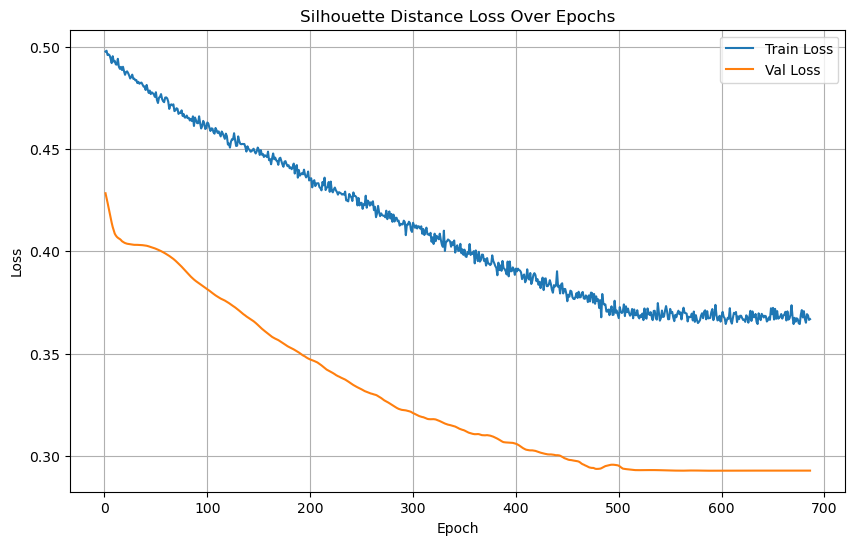

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/154], Loss: 0.2384


Test Batch [20/154], Loss: 0.2908
Test Batch [30/154], Loss: 0.3257


Test Batch [40/154], Loss: 0.2572


Test Batch [50/154], Loss: 0.4243
Test Batch [60/154], Loss: 0.2870


Test Batch [70/154], Loss: 0.2424
Test Batch [80/154], Loss: 0.2339


Test Batch [90/154], Loss: 0.2247
Test Batch [100/154], Loss: 0.1694
Test Batch [110/154], Loss: 0.2333


Test Batch [120/154], Loss: 0.1350
Test Batch [130/154], Loss: 0.2828


Test Batch [140/154], Loss: 0.4141


Test Batch [150/154], Loss: 0.3668

Test Loss: 0.3021


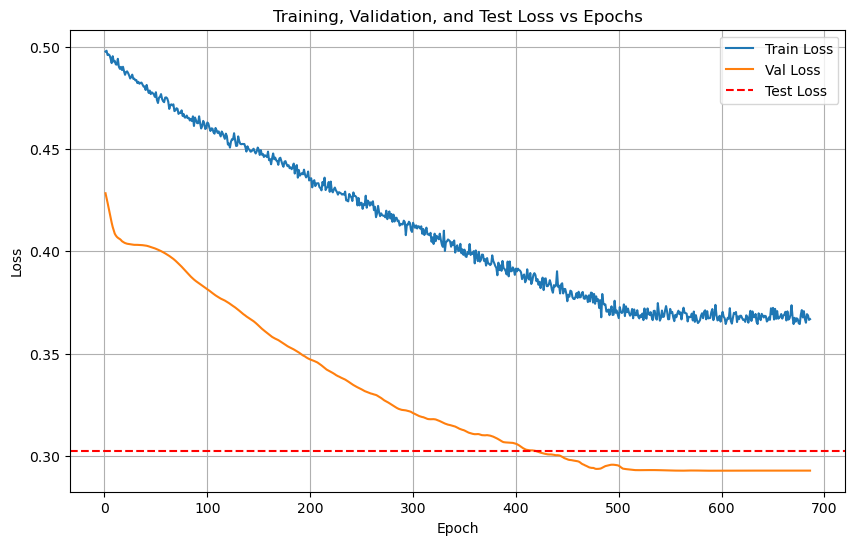

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/154 for test dataset.


  Processed batch 20/154 for test dataset.
  Processed batch 30/154 for test dataset.


  Processed batch 40/154 for test dataset.


  Processed batch 50/154 for test dataset.
  Processed batch 60/154 for test dataset.


  Processed batch 70/154 for test dataset.
  Processed batch 80/154 for test dataset.
  Processed batch 90/154 for test dataset.


  Processed batch 100/154 for test dataset.
  Processed batch 110/154 for test dataset.
  Processed batch 120/154 for test dataset.
  Processed batch 130/154 for test dataset.


  Processed batch 140/154 for test dataset.
  Processed batch 150/154 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 65.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.20      0.20      0.20         5
           2       0.40      0.40      0.40         5
           3       0.40      0.40      0.40         5
           4       1.00      1.00      1.00         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       0.50      0.80      0.62         5
           8       0.00      0.00      0.00         0
           9       0.60      0.60      0.60         5
          10       0.25      0.20      0.22         5
          11       0.40      0.40      0.40         5
          12       1.00      1.00      1.00         5
          13       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8605  |  Val Loss: 2.8383
Validation loss improved from inf to 2.8383.
[Epoch 2/1000] Train Loss: 2.8334  |  Val Loss: 2.8102
Validation loss improved from 2.8383 to 2.8102.
[Epoch 3/1000] Train Loss: 2.8022  |  Val Loss: 2.7849
Validation loss improved from 2.8102 to 2.7849.
[Epoch 4/1000] Train Loss: 2.7776  |  Val Loss: 2.7611
Validation loss improved from 2.7849 to 2.7611.
[Epoch 5/1000] Train Loss: 2.7542  |  Val Loss: 2.7395
Validation loss improved from 2.7611 to 2.7395.


[Epoch 6/1000] Train Loss: 2.7331  |  Val Loss: 2.7193
Validation loss improved from 2.7395 to 2.7193.
[Epoch 7/1000] Train Loss: 2.7121  |  Val Loss: 2.7020
Validation loss improved from 2.7193 to 2.7020.
[Epoch 8/1000] Train Loss: 2.6955  |  Val Loss: 2.6848
Validation loss improved from 2.7020 to 2.6848.
[Epoch 9/1000] Train Loss: 2.6782  |  Val Loss: 2.6688
Validation loss improved from 2.6848 to 2.6688.
[Epoch 10/1000] Train Loss: 2.6619  |  Val Loss: 2.6538
Validation loss improved from 2.6688 to 2.6538.
[Epoch 11/1000] Train Loss: 2.6463  |  Val Loss: 2.6392
Validation loss improved from 2.6538 to 2.6392.
[Epoch 12/1000] Train Loss: 2.6304  |  Val Loss: 2.6254
Validation loss improved from 2.6392 to 2.6254.
[Epoch 13/1000] Train Loss: 2.6151  |  Val Loss: 2.6112
Validation loss improved from 2.6254 to 2.6112.
[Epoch 14/1000] Train Loss: 2.5997  |  Val Loss: 2.5968
Validation loss improved from 2.6112 to 2.5968.
[Epoch 15/1000] Train Loss: 2.5842  |  Val Loss: 2.5831
Validation l

[Epoch 16/1000] Train Loss: 2.5682  |  Val Loss: 2.5696
Validation loss improved from 2.5831 to 2.5696.


[Epoch 17/1000] Train Loss: 2.5524  |  Val Loss: 2.5553
Validation loss improved from 2.5696 to 2.5553.
[Epoch 18/1000] Train Loss: 2.5342  |  Val Loss: 2.5379
Validation loss improved from 2.5553 to 2.5379.
[Epoch 19/1000] Train Loss: 2.5146  |  Val Loss: 2.5183
Validation loss improved from 2.5379 to 2.5183.
[Epoch 20/1000] Train Loss: 2.4931  |  Val Loss: 2.4985
Validation loss improved from 2.5183 to 2.4985.
[Epoch 21/1000] Train Loss: 2.4717  |  Val Loss: 2.4788
Validation loss improved from 2.4985 to 2.4788.
[Epoch 22/1000] Train Loss: 2.4498  |  Val Loss: 2.4593
Validation loss improved from 2.4788 to 2.4593.
[Epoch 23/1000] Train Loss: 2.4295  |  Val Loss: 2.4403
Validation loss improved from 2.4593 to 2.4403.
[Epoch 24/1000] Train Loss: 2.4084  |  Val Loss: 2.4215
Validation loss improved from 2.4403 to 2.4215.


[Epoch 25/1000] Train Loss: 2.3886  |  Val Loss: 2.4027
Validation loss improved from 2.4215 to 2.4027.
[Epoch 26/1000] Train Loss: 2.3677  |  Val Loss: 2.3841
Validation loss improved from 2.4027 to 2.3841.
[Epoch 27/1000] Train Loss: 2.3477  |  Val Loss: 2.3657
Validation loss improved from 2.3841 to 2.3657.
[Epoch 28/1000] Train Loss: 2.3275  |  Val Loss: 2.3474
Validation loss improved from 2.3657 to 2.3474.
[Epoch 29/1000] Train Loss: 2.3074  |  Val Loss: 2.3293
Validation loss improved from 2.3474 to 2.3293.
[Epoch 30/1000] Train Loss: 2.2873  |  Val Loss: 2.3114
Validation loss improved from 2.3293 to 2.3114.
[Epoch 31/1000] Train Loss: 2.2675  |  Val Loss: 2.2934
Validation loss improved from 2.3114 to 2.2934.
[Epoch 32/1000] Train Loss: 2.2479  |  Val Loss: 2.2750
Validation loss improved from 2.2934 to 2.2750.
[Epoch 33/1000] Train Loss: 2.2280  |  Val Loss: 2.2567
Validation loss improved from 2.2750 to 2.2567.
[Epoch 34/1000] Train Loss: 2.2080  |  Val Loss: 2.2384
Validati

[Epoch 36/1000] Train Loss: 2.1675  |  Val Loss: 2.2021
Validation loss improved from 2.2205 to 2.2021.
[Epoch 37/1000] Train Loss: 2.1467  |  Val Loss: 2.1839
Validation loss improved from 2.2021 to 2.1839.
[Epoch 38/1000] Train Loss: 2.1263  |  Val Loss: 2.1659
Validation loss improved from 2.1839 to 2.1659.
[Epoch 39/1000] Train Loss: 2.1061  |  Val Loss: 2.1479
Validation loss improved from 2.1659 to 2.1479.
[Epoch 40/1000] Train Loss: 2.0854  |  Val Loss: 2.1305
Validation loss improved from 2.1479 to 2.1305.
[Epoch 41/1000] Train Loss: 2.0649  |  Val Loss: 2.1134
Validation loss improved from 2.1305 to 2.1134.


[Epoch 42/1000] Train Loss: 2.0448  |  Val Loss: 2.0962
Validation loss improved from 2.1134 to 2.0962.
[Epoch 43/1000] Train Loss: 2.0249  |  Val Loss: 2.0789
Validation loss improved from 2.0962 to 2.0789.
[Epoch 44/1000] Train Loss: 2.0040  |  Val Loss: 2.0618
Validation loss improved from 2.0789 to 2.0618.
[Epoch 45/1000] Train Loss: 1.9832  |  Val Loss: 2.0451
Validation loss improved from 2.0618 to 2.0451.
[Epoch 46/1000] Train Loss: 1.9630  |  Val Loss: 2.0281
Validation loss improved from 2.0451 to 2.0281.
[Epoch 47/1000] Train Loss: 1.9421  |  Val Loss: 2.0110
Validation loss improved from 2.0281 to 2.0110.
[Epoch 48/1000] Train Loss: 1.9215  |  Val Loss: 1.9944
Validation loss improved from 2.0110 to 1.9944.
[Epoch 49/1000] Train Loss: 1.9004  |  Val Loss: 1.9778
Validation loss improved from 1.9944 to 1.9778.
[Epoch 50/1000] Train Loss: 1.8798  |  Val Loss: 1.9613
Validation loss improved from 1.9778 to 1.9613.
[Epoch 51/1000] Train Loss: 1.8580  |  Val Loss: 1.9449
Validati

[Epoch 54/1000] Train Loss: 1.7957  |  Val Loss: 1.8953
Validation loss improved from 1.9118 to 1.8953.
[Epoch 55/1000] Train Loss: 1.7749  |  Val Loss: 1.8785
Validation loss improved from 1.8953 to 1.8785.
[Epoch 56/1000] Train Loss: 1.7537  |  Val Loss: 1.8618
Validation loss improved from 1.8785 to 1.8618.
[Epoch 57/1000] Train Loss: 1.7331  |  Val Loss: 1.8456
Validation loss improved from 1.8618 to 1.8456.
[Epoch 58/1000] Train Loss: 1.7118  |  Val Loss: 1.8294
Validation loss improved from 1.8456 to 1.8294.
[Epoch 59/1000] Train Loss: 1.6913  |  Val Loss: 1.8131
Validation loss improved from 1.8294 to 1.8131.


[Epoch 60/1000] Train Loss: 1.6705  |  Val Loss: 1.7967
Validation loss improved from 1.8131 to 1.7967.
[Epoch 61/1000] Train Loss: 1.6495  |  Val Loss: 1.7805
Validation loss improved from 1.7967 to 1.7805.
[Epoch 62/1000] Train Loss: 1.6288  |  Val Loss: 1.7647
Validation loss improved from 1.7805 to 1.7647.
[Epoch 63/1000] Train Loss: 1.6079  |  Val Loss: 1.7484
Validation loss improved from 1.7647 to 1.7484.
[Epoch 64/1000] Train Loss: 1.5873  |  Val Loss: 1.7333
Validation loss improved from 1.7484 to 1.7333.
[Epoch 65/1000] Train Loss: 1.5668  |  Val Loss: 1.7175
Validation loss improved from 1.7333 to 1.7175.
[Epoch 66/1000] Train Loss: 1.5464  |  Val Loss: 1.7023
Validation loss improved from 1.7175 to 1.7023.
[Epoch 67/1000] Train Loss: 1.5258  |  Val Loss: 1.6871
Validation loss improved from 1.7023 to 1.6871.
[Epoch 68/1000] Train Loss: 1.5055  |  Val Loss: 1.6722
Validation loss improved from 1.6871 to 1.6722.
[Epoch 69/1000] Train Loss: 1.4852  |  Val Loss: 1.6571
Validati

[Epoch 74/1000] Train Loss: 1.3848  |  Val Loss: 1.5824
Validation loss improved from 1.5973 to 1.5824.
[Epoch 75/1000] Train Loss: 1.3654  |  Val Loss: 1.5680
Validation loss improved from 1.5824 to 1.5680.
[Epoch 76/1000] Train Loss: 1.3455  |  Val Loss: 1.5533
Validation loss improved from 1.5680 to 1.5533.
[Epoch 77/1000] Train Loss: 1.3264  |  Val Loss: 1.5384
Validation loss improved from 1.5533 to 1.5384.


[Epoch 78/1000] Train Loss: 1.3074  |  Val Loss: 1.5237
Validation loss improved from 1.5384 to 1.5237.
[Epoch 79/1000] Train Loss: 1.2886  |  Val Loss: 1.5093
Validation loss improved from 1.5237 to 1.5093.
[Epoch 80/1000] Train Loss: 1.2704  |  Val Loss: 1.4955
Validation loss improved from 1.5093 to 1.4955.
[Epoch 81/1000] Train Loss: 1.2527  |  Val Loss: 1.4815
Validation loss improved from 1.4955 to 1.4815.
[Epoch 82/1000] Train Loss: 1.2348  |  Val Loss: 1.4681
Validation loss improved from 1.4815 to 1.4681.
[Epoch 83/1000] Train Loss: 1.2173  |  Val Loss: 1.4548
Validation loss improved from 1.4681 to 1.4548.
[Epoch 84/1000] Train Loss: 1.2002  |  Val Loss: 1.4422
Validation loss improved from 1.4548 to 1.4422.
[Epoch 85/1000] Train Loss: 1.1834  |  Val Loss: 1.4297
Validation loss improved from 1.4422 to 1.4297.
[Epoch 86/1000] Train Loss: 1.1666  |  Val Loss: 1.4166
Validation loss improved from 1.4297 to 1.4166.
[Epoch 87/1000] Train Loss: 1.1501  |  Val Loss: 1.4035
Validati

[Epoch 91/1000] Train Loss: 1.0870  |  Val Loss: 1.3546
Validation loss improved from 1.3663 to 1.3546.
[Epoch 92/1000] Train Loss: 1.0727  |  Val Loss: 1.3431
Validation loss improved from 1.3546 to 1.3431.
[Epoch 93/1000] Train Loss: 1.0582  |  Val Loss: 1.3322
Validation loss improved from 1.3431 to 1.3322.
[Epoch 94/1000] Train Loss: 1.0449  |  Val Loss: 1.3222
Validation loss improved from 1.3322 to 1.3222.
[Epoch 95/1000] Train Loss: 1.0307  |  Val Loss: 1.3118
Validation loss improved from 1.3222 to 1.3118.
[Epoch 96/1000] Train Loss: 1.0176  |  Val Loss: 1.3017
Validation loss improved from 1.3118 to 1.3017.
[Epoch 97/1000] Train Loss: 1.0043  |  Val Loss: 1.2918
Validation loss improved from 1.3017 to 1.2918.


[Epoch 98/1000] Train Loss: 0.9921  |  Val Loss: 1.2825
Validation loss improved from 1.2918 to 1.2825.
[Epoch 99/1000] Train Loss: 0.9793  |  Val Loss: 1.2734
Validation loss improved from 1.2825 to 1.2734.
[Epoch 100/1000] Train Loss: 0.9672  |  Val Loss: 1.2641
Validation loss improved from 1.2734 to 1.2641.
[Epoch 101/1000] Train Loss: 0.9554  |  Val Loss: 1.2555
Validation loss improved from 1.2641 to 1.2555.
[Epoch 102/1000] Train Loss: 0.9440  |  Val Loss: 1.2460
Validation loss improved from 1.2555 to 1.2460.
[Epoch 103/1000] Train Loss: 0.9323  |  Val Loss: 1.2381
Validation loss improved from 1.2460 to 1.2381.
[Epoch 104/1000] Train Loss: 0.9211  |  Val Loss: 1.2301
Validation loss improved from 1.2381 to 1.2301.
[Epoch 105/1000] Train Loss: 0.9100  |  Val Loss: 1.2221
Validation loss improved from 1.2301 to 1.2221.
[Epoch 106/1000] Train Loss: 0.8994  |  Val Loss: 1.2143
Validation loss improved from 1.2221 to 1.2143.
[Epoch 107/1000] Train Loss: 0.8891  |  Val Loss: 1.2061


[Epoch 112/1000] Train Loss: 0.8403  |  Val Loss: 1.1714
Validation loss improved from 1.1786 to 1.1714.
[Epoch 113/1000] Train Loss: 0.8308  |  Val Loss: 1.1650
Validation loss improved from 1.1714 to 1.1650.
[Epoch 114/1000] Train Loss: 0.8223  |  Val Loss: 1.1596
Validation loss improved from 1.1650 to 1.1596.
[Epoch 115/1000] Train Loss: 0.8134  |  Val Loss: 1.1534
Validation loss improved from 1.1596 to 1.1534.
[Epoch 116/1000] Train Loss: 0.8049  |  Val Loss: 1.1478
Validation loss improved from 1.1534 to 1.1478.


[Epoch 117/1000] Train Loss: 0.7964  |  Val Loss: 1.1418
Validation loss improved from 1.1478 to 1.1418.
[Epoch 118/1000] Train Loss: 0.7884  |  Val Loss: 1.1360
Validation loss improved from 1.1418 to 1.1360.
[Epoch 119/1000] Train Loss: 0.7802  |  Val Loss: 1.1309
Validation loss improved from 1.1360 to 1.1309.
[Epoch 120/1000] Train Loss: 0.7726  |  Val Loss: 1.1253
Validation loss improved from 1.1309 to 1.1253.
[Epoch 121/1000] Train Loss: 0.7648  |  Val Loss: 1.1198
Validation loss improved from 1.1253 to 1.1198.
[Epoch 122/1000] Train Loss: 0.7575  |  Val Loss: 1.1148
Validation loss improved from 1.1198 to 1.1148.
[Epoch 123/1000] Train Loss: 0.7501  |  Val Loss: 1.1100
Validation loss improved from 1.1148 to 1.1100.
[Epoch 124/1000] Train Loss: 0.7432  |  Val Loss: 1.1058
Validation loss improved from 1.1100 to 1.1058.
[Epoch 125/1000] Train Loss: 0.7361  |  Val Loss: 1.1013
Validation loss improved from 1.1058 to 1.1013.
[Epoch 126/1000] Train Loss: 0.7292  |  Val Loss: 1.096

[Epoch 133/1000] Train Loss: 0.6854  |  Val Loss: 1.0695
Validation loss improved from 1.0736 to 1.0695.


[Epoch 134/1000] Train Loss: 0.6797  |  Val Loss: 1.0661
Validation loss improved from 1.0695 to 1.0661.
[Epoch 135/1000] Train Loss: 0.6742  |  Val Loss: 1.0634
Validation loss improved from 1.0661 to 1.0634.
[Epoch 136/1000] Train Loss: 0.6688  |  Val Loss: 1.0592
Validation loss improved from 1.0634 to 1.0592.
[Epoch 137/1000] Train Loss: 0.6632  |  Val Loss: 1.0554
Validation loss improved from 1.0592 to 1.0554.
[Epoch 138/1000] Train Loss: 0.6580  |  Val Loss: 1.0530
Validation loss improved from 1.0554 to 1.0530.
[Epoch 139/1000] Train Loss: 0.6530  |  Val Loss: 1.0500
Validation loss improved from 1.0530 to 1.0500.
[Epoch 140/1000] Train Loss: 0.6484  |  Val Loss: 1.0471
Validation loss improved from 1.0500 to 1.0471.
[Epoch 141/1000] Train Loss: 0.6433  |  Val Loss: 1.0446
Validation loss improved from 1.0471 to 1.0446.
[Epoch 142/1000] Train Loss: 0.6385  |  Val Loss: 1.0425
Validation loss improved from 1.0446 to 1.0425.
[Epoch 143/1000] Train Loss: 0.6337  |  Val Loss: 1.039

[Epoch 152/1000] Train Loss: 0.5953  |  Val Loss: 1.0222
Validation loss improved from 1.0231 to 1.0222.
[Epoch 153/1000] Train Loss: 0.5913  |  Val Loss: 1.0205
Validation loss improved from 1.0222 to 1.0205.
[Epoch 154/1000] Train Loss: 0.5880  |  Val Loss: 1.0182
Validation loss improved from 1.0205 to 1.0182.
[Epoch 155/1000] Train Loss: 0.5838  |  Val Loss: 1.0171
Validation loss improved from 1.0182 to 1.0171.
[Epoch 156/1000] Train Loss: 0.5804  |  Val Loss: 1.0160
Validation loss improved from 1.0171 to 1.0160.
[Epoch 157/1000] Train Loss: 0.5768  |  Val Loss: 1.0146
Validation loss improved from 1.0160 to 1.0146.
[Epoch 158/1000] Train Loss: 0.5731  |  Val Loss: 1.0141
Validation loss improved from 1.0146 to 1.0141.
[Epoch 159/1000] Train Loss: 0.5699  |  Val Loss: 1.0121
Validation loss improved from 1.0141 to 1.0121.
[Epoch 160/1000] Train Loss: 0.5663  |  Val Loss: 1.0104
Validation loss improved from 1.0121 to 1.0104.
[Epoch 161/1000] Train Loss: 0.5627  |  Val Loss: 1.009

[Epoch 170/1000] Train Loss: 0.5350  |  Val Loss: 0.9992
Validation loss improved from 1.0002 to 0.9992.
[Epoch 171/1000] Train Loss: 0.5320  |  Val Loss: 0.9978
Validation loss improved from 0.9992 to 0.9978.
[Epoch 172/1000] Train Loss: 0.5294  |  Val Loss: 0.9975
Validation loss improved from 0.9978 to 0.9975.
[Epoch 173/1000] Train Loss: 0.5264  |  Val Loss: 0.9962
Validation loss improved from 0.9975 to 0.9962.
[Epoch 174/1000] Train Loss: 0.5237  |  Val Loss: 0.9953
Validation loss improved from 0.9962 to 0.9953.
[Epoch 175/1000] Train Loss: 0.5213  |  Val Loss: 0.9947
Validation loss improved from 0.9953 to 0.9947.
[Epoch 176/1000] Train Loss: 0.5187  |  Val Loss: 0.9943
Validation loss improved from 0.9947 to 0.9943.
[Epoch 177/1000] Train Loss: 0.5156  |  Val Loss: 0.9925
Validation loss improved from 0.9943 to 0.9925.
[Epoch 178/1000] Train Loss: 0.5131  |  Val Loss: 0.9926
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 179/1000] Train Loss: 0.5110  |  Val Loss:

[Epoch 188/1000] Train Loss: 0.4893  |  Val Loss: 0.9853
Validation loss improved from 0.9854 to 0.9853.
[Epoch 189/1000] Train Loss: 0.4873  |  Val Loss: 0.9839
Validation loss improved from 0.9853 to 0.9839.
[Epoch 190/1000] Train Loss: 0.4851  |  Val Loss: 0.9828
Validation loss improved from 0.9839 to 0.9828.
[Epoch 191/1000] Train Loss: 0.4827  |  Val Loss: 0.9827
Validation loss improved from 0.9828 to 0.9827.
[Epoch 192/1000] Train Loss: 0.4805  |  Val Loss: 0.9822
Validation loss improved from 0.9827 to 0.9822.
[Epoch 193/1000] Train Loss: 0.4784  |  Val Loss: 0.9810
Validation loss improved from 0.9822 to 0.9810.
[Epoch 194/1000] Train Loss: 0.4767  |  Val Loss: 0.9818
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 0.4742  |  Val Loss: 0.9813
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 0.4724  |  Val Loss: 0.9802
Validation loss improved from 0.9810 to 0.9802.
[Epoch 197/1000] Train Loss: 0.4709  |  Val

[Epoch 207/1000] Train Loss: 0.4511  |  Val Loss: 0.9743
Validation loss improved from 0.9751 to 0.9743.
[Epoch 208/1000] Train Loss: 0.4494  |  Val Loss: 0.9743
Validation loss improved from 0.9743 to 0.9743.
[Epoch 209/1000] Train Loss: 0.4477  |  Val Loss: 0.9745
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 0.4458  |  Val Loss: 0.9730
Validation loss improved from 0.9743 to 0.9730.
[Epoch 211/1000] Train Loss: 0.4439  |  Val Loss: 0.9727
Validation loss improved from 0.9730 to 0.9727.
[Epoch 212/1000] Train Loss: 0.4425  |  Val Loss: 0.9716
Validation loss improved from 0.9727 to 0.9716.
[Epoch 213/1000] Train Loss: 0.4404  |  Val Loss: 0.9717
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 0.4389  |  Val Loss: 0.9717
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 215/1000] Train Loss: 0.4371  |  Val Loss: 0.9717
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 216/1000] Train Loss: 0.

[Epoch 226/1000] Train Loss: 0.4195  |  Val Loss: 0.9692
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 227/1000] Train Loss: 0.4179  |  Val Loss: 0.9682
Validation loss improved from 0.9685 to 0.9682.
[Epoch 228/1000] Train Loss: 0.4168  |  Val Loss: 0.9670
Validation loss improved from 0.9682 to 0.9670.
[Epoch 229/1000] Train Loss: 0.4153  |  Val Loss: 0.9672
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.4138  |  Val Loss: 0.9683
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 0.4127  |  Val Loss: 0.9687
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 232/1000] Train Loss: 0.4109  |  Val Loss: 0.9695
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 233/1000] Train Loss: 0.4094  |  Val Loss: 0.9689
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 234/1000] Train Loss: 0.4082  |  Val Loss: 0.9680
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 235/10

[Epoch 245/1000] Train Loss: 0.3936  |  Val Loss: 0.9675
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 246/1000] Train Loss: 0.3921  |  Val Loss: 0.9673
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 247/1000] Train Loss: 0.3908  |  Val Loss: 0.9671
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 248/1000] Train Loss: 0.3898  |  Val Loss: 0.9682
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 249/1000] Train Loss: 0.3886  |  Val Loss: 0.9694
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 250/1000] Train Loss: 0.3873  |  Val Loss: 0.9686
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 251/1000] Train Loss: 0.3858  |  Val Loss: 0.9677
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 252/1000] Train Loss: 0.3846  |  Val Loss: 0.9675
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 253/1000] Train Loss: 0.3835  |  Val Loss: 0.9675
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 263/1000] Train Loss: 0.3716  |  Val Loss: 0.9698
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 264/1000] Train Loss: 0.3708  |  Val Loss: 0.9691
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 265/1000] Train Loss: 0.3692  |  Val Loss: 0.9687
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 266/1000] Train Loss: 0.3680  |  Val Loss: 0.9683
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 267/1000] Train Loss: 0.3676  |  Val Loss: 0.9681
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 268/1000] Train Loss: 0.3659  |  Val Loss: 0.9689
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 269/1000] Train Loss: 0.3647  |  Val Loss: 0.9697
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 270/1000] Train Loss: 0.3634  |  Val Loss: 0.9697
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 271/1000] Train Loss: 0.3628  |  Val Loss: 0.9696
!! Validation loss did NOT improve !! Patience:

[Epoch 282/1000] Train Loss: 0.3508  |  Val Loss: 0.9710
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 283/1000] Train Loss: 0.3502  |  Val Loss: 0.9724
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 284/1000] Train Loss: 0.3491  |  Val Loss: 0.9730
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 285/1000] Train Loss: 0.3481  |  Val Loss: 0.9737
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 286/1000] Train Loss: 0.3468  |  Val Loss: 0.9729
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 287/1000] Train Loss: 0.3457  |  Val Loss: 0.9729
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 288/1000] Train Loss: 0.3450  |  Val Loss: 0.9732
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 289/1000] Train Loss: 0.3441  |  Val Loss: 0.9744
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 290/1000] Train Loss: 0.3433  |  Val Loss: 0.9737
!! Validation loss did NOT improve !! Patience:

[Epoch 300/1000] Train Loss: 0.3332  |  Val Loss: 0.9764
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 301/1000] Train Loss: 0.3320  |  Val Loss: 0.9771
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 302/1000] Train Loss: 0.3314  |  Val Loss: 0.9779
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 303/1000] Train Loss: 0.3303  |  Val Loss: 0.9775
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 304/1000] Train Loss: 0.3292  |  Val Loss: 0.9773
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 305/1000] Train Loss: 0.3282  |  Val Loss: 0.9776
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 306/1000] Train Loss: 0.3275  |  Val Loss: 0.9778
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 307/1000] Train Loss: 0.3267  |  Val Loss: 0.9799
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 308/1000] Train Loss: 0.3256  |  Val Loss: 0.9797
!! Validation loss did NOT improve !! Patience:

[Epoch 318/1000] Train Loss: 0.3168  |  Val Loss: 0.9857
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 319/1000] Train Loss: 0.3162  |  Val Loss: 0.9847
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 320/1000] Train Loss: 0.3153  |  Val Loss: 0.9838
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 321/1000] Train Loss: 0.3142  |  Val Loss: 0.9843
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 322/1000] Train Loss: 0.3138  |  Val Loss: 0.9871
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 323/1000] Train Loss: 0.3127  |  Val Loss: 0.9867
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 324/1000] Train Loss: 0.3115  |  Val Loss: 0.9883
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 325/1000] Train Loss: 0.3112  |  Val Loss: 0.9897
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 326/1000] Train Loss: 0.3102  |  Val Loss: 0.9902
!! Validation loss did NOT improve !! Patience:

[Epoch 337/1000] Train Loss: 0.3011  |  Val Loss: 0.9959
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 338/1000] Train Loss: 0.3004  |  Val Loss: 0.9957
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 339/1000] Train Loss: 0.2999  |  Val Loss: 0.9967
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 340/1000] Train Loss: 0.2989  |  Val Loss: 0.9975
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 340 !!
No improvement for 100 epochs.


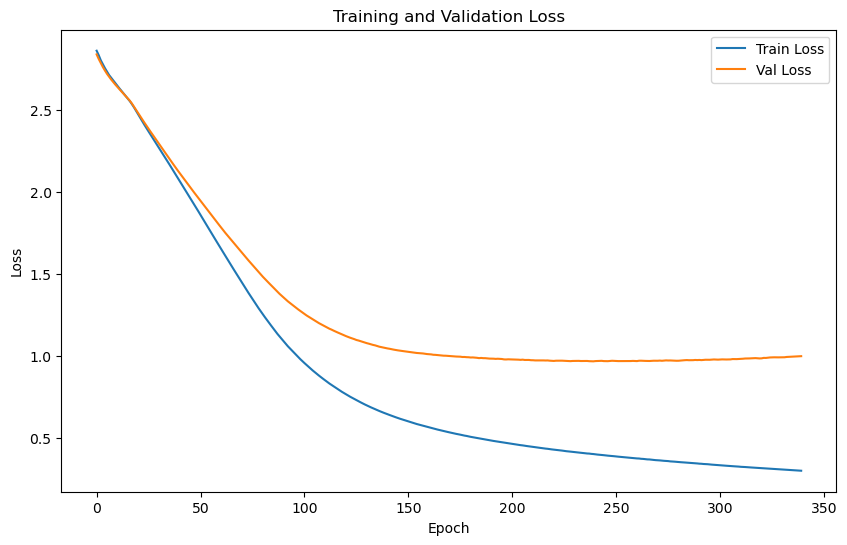

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.6285 | Test Accuracy: 54.72%


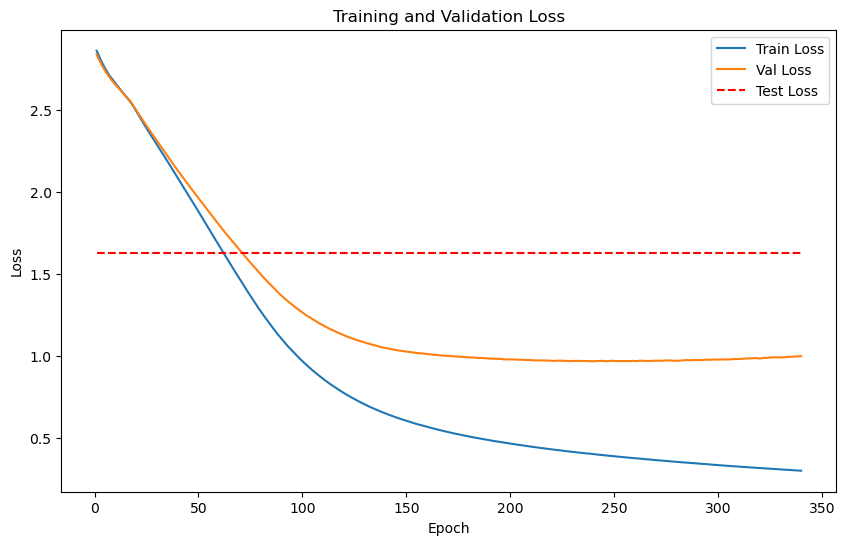

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


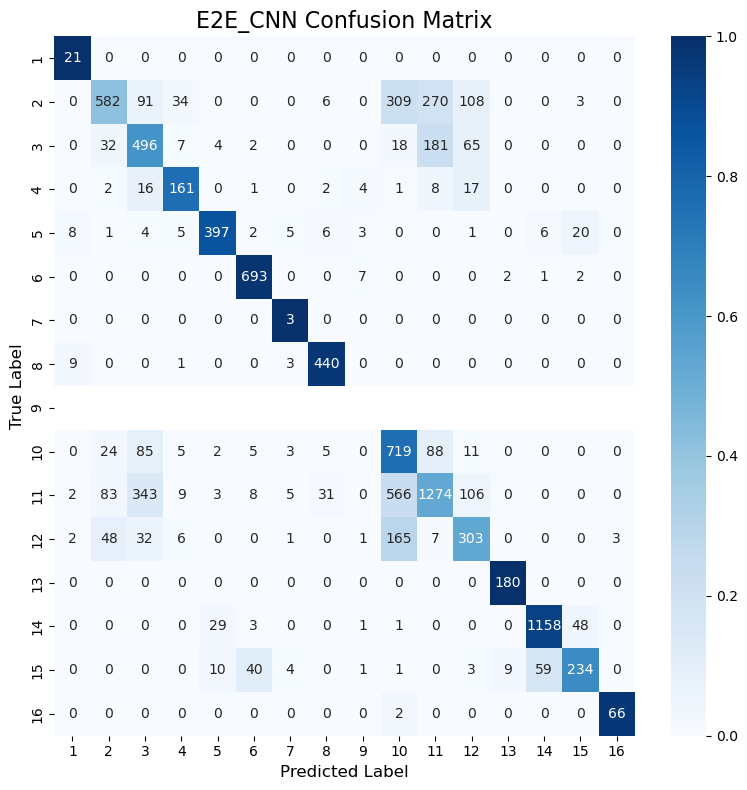

Classification Accuracy: 68.27%


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


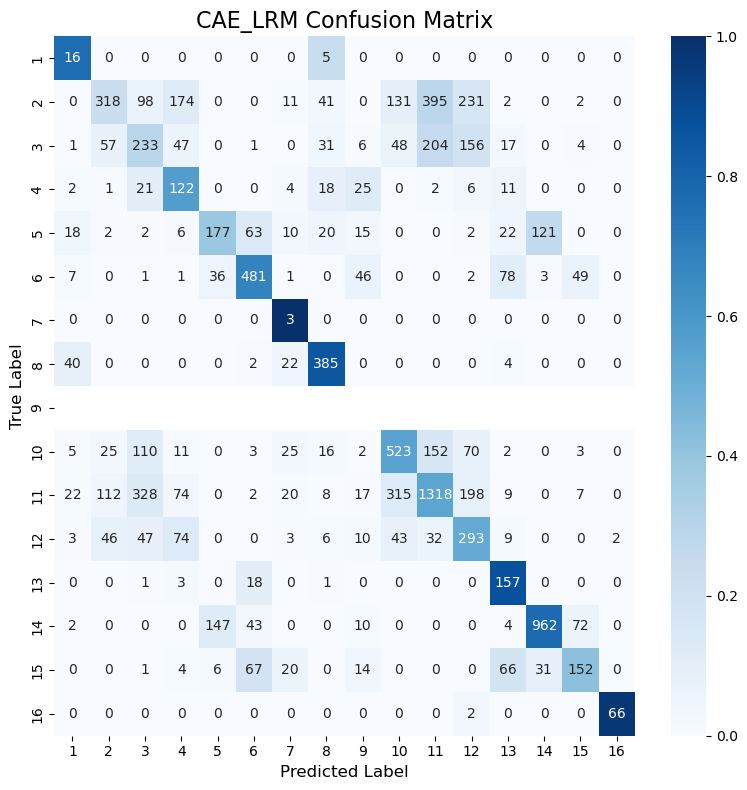

Classification Accuracy: 52.83%


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


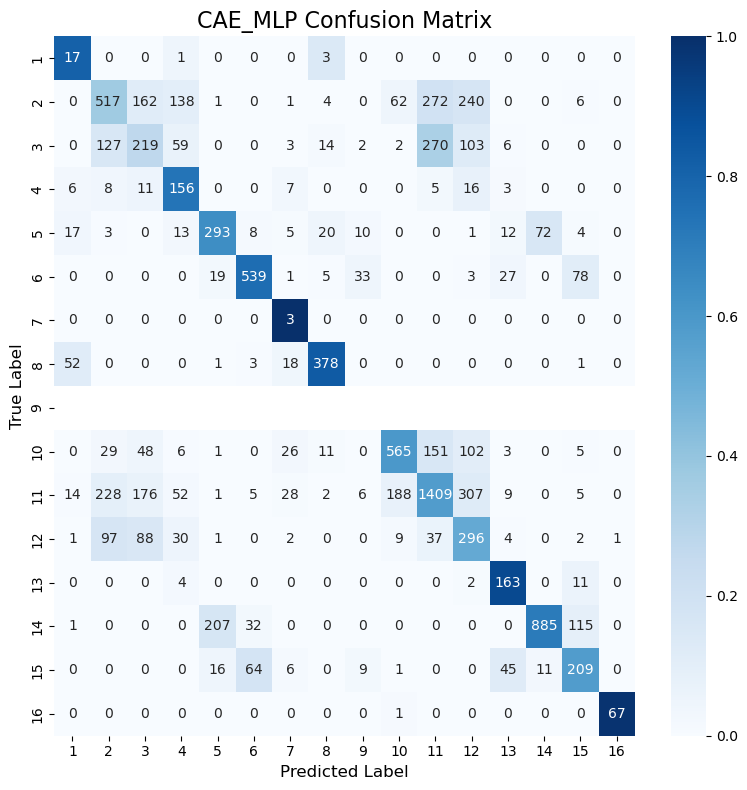

Classification Accuracy: 58.01%


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


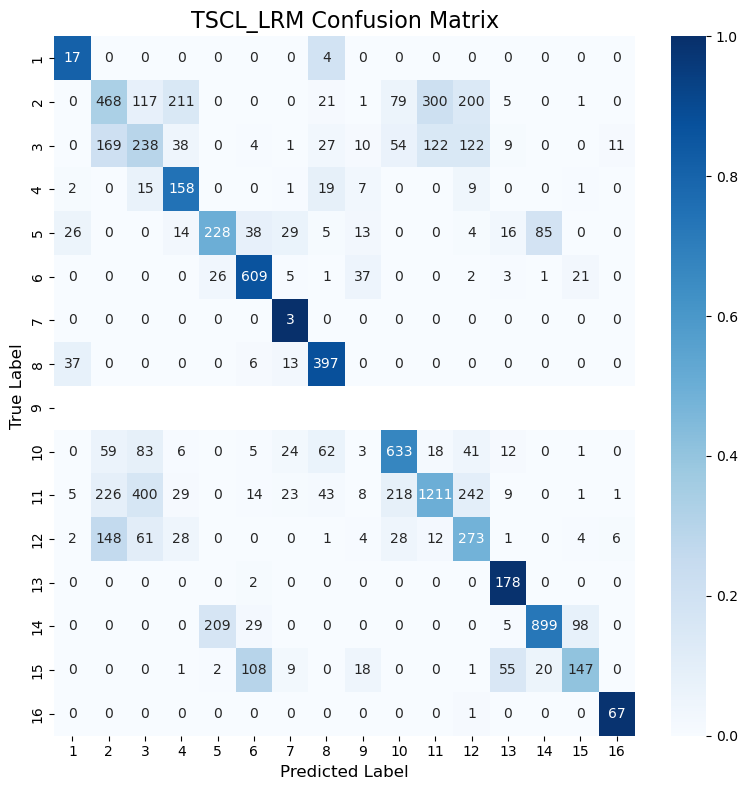

Classification Accuracy: 56.08%


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


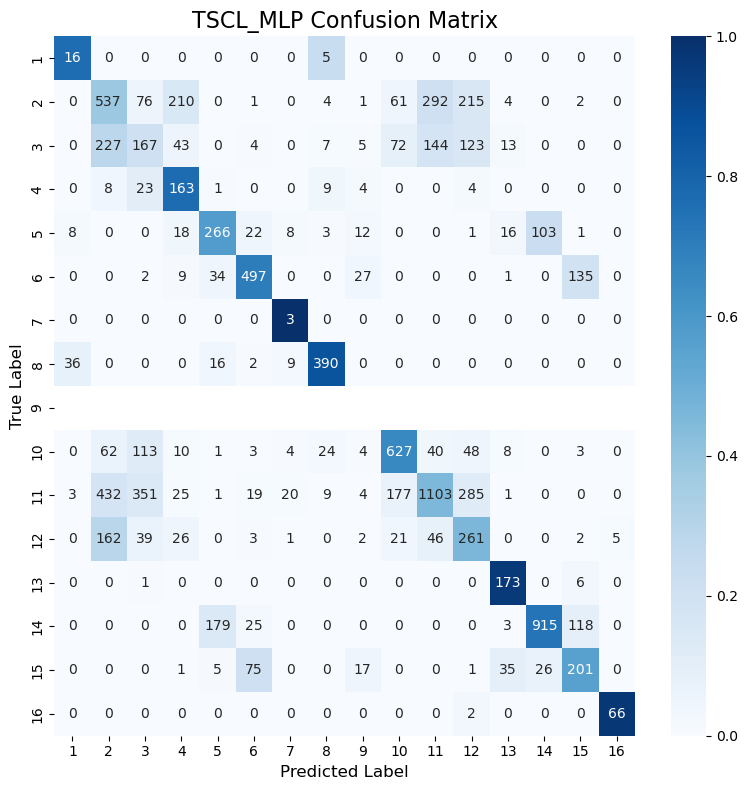

Classification Accuracy: 54.65%


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


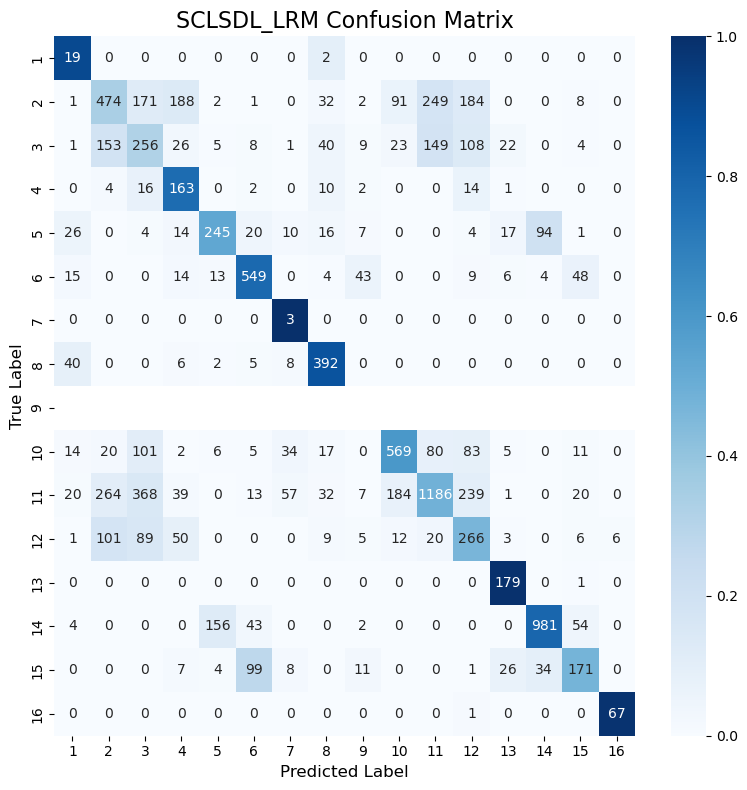

Classification Accuracy: 56.02%


C:\Users\vella\AppData\Local\Temp\ipykernel_11580\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


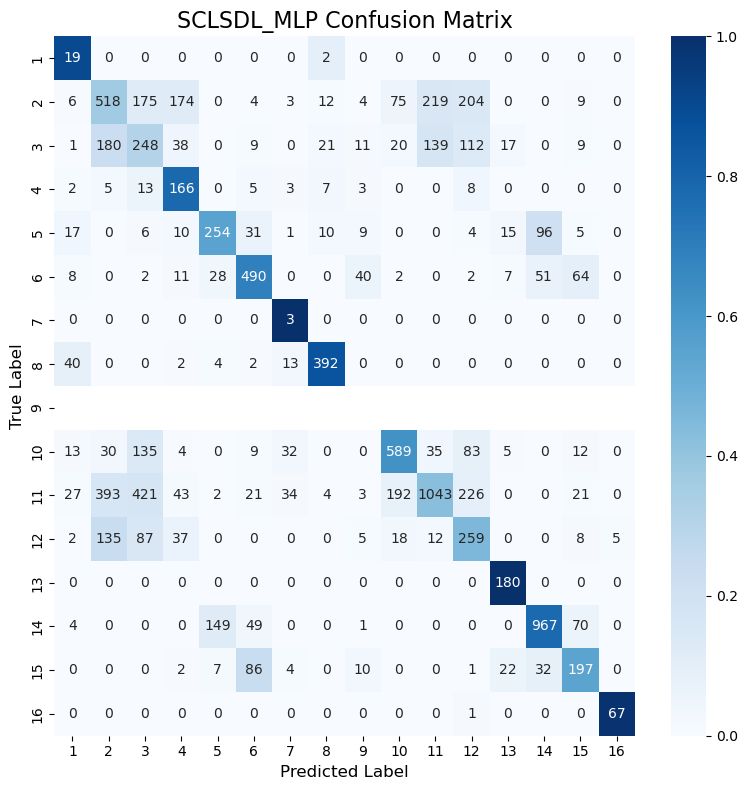

Classification Accuracy: 54.72%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          68.27
1    LRM (CAE)          52.83
2    MLP (CAE)          58.01
3     TSCL LRM          56.08
4     TSCL MLP          54.65
5  SCL_SDL LRM          56.02
6  SCL_SDL MLP          54.72

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          68.27
2    MLP (CAE)          58.01
3     TSCL LRM          56.08
5  SCL_SDL LRM          56.02
6  SCL_SDL MLP          54.72
4     TSCL MLP          54.65
1    LRM (CAE)          52.83
